In [2]:
from google.colab import drive
import os
%load_ext autoreload
%autoreload 2

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/data_preparation/')

Mounted at /content/gdrive


In [3]:
!pip install antspyx --quiet

     |████████████████████████████████| 300.4 MB 9.3 kB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 


# Imports

https://discuss.pytorch.org/t/loaded-model-returns-different-predictions/77588/2

https://discuss.pytorch.org/t/model-shows-different-predictions-after-training-without-weight-update/75877/5



In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [5]:
import os
import sys
import time
import random
import argparse
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from mri_augmentation import *
sys.path.append("./../utils")
from base_mri import *
from utils import *

def generate_mri_dataset_reference(mri_reference_path,
                                output_path,
                                orientation = 'coronal',
                                orientation_slice = 50,
                                num_sampled_images = 5,
                                sampling_range = 3,
                                num_rotations = 3,
                                save_reference_file = True):

    '''
    Execute MRI metadata preparation for training the deep learning model. The final image will be generated only during training/test/validation step.

    Main Steps:

    - Select orientation of training.
    
    - Select slice indication.

    - Executes Data Augmentation (optional) generating more images based on rotation and flipping. 

    Parameters
    ----------
 
    mri_reference_path: path of the processed MRI reference file.
    
    output_path: path to save the metadata reference file.
    
    orientation: Orientation to slice the image. Values can be "coronal", "sagittal" or "axial".
    
    orientation_slice: Mark to slice the 3D image. Values range from 0 to 100. TODO: fix future bug if sampling_range is outside of the image.
    
    num_sampled_images: Number of images to sample.
    
    sampling_range: Range to sample new images from original 3D image, with reference to the orientation_slice.

    num_rotations: Number of different rotations to augment original image.

    save_reference_file: Flag to save the reference file or not.
    
    '''

    df_mri_reference = pd.read_csv(mri_reference_path)

    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    df_mri_dataset = df_mri_reference.query("ORIENTATION == @orientation and VALID_IMAGE == True")
    df_mri_dataset['MAIN_SLICE'] = orientation_slice
    images= df_mri_reference['IMAGE_DATA_ID'].unique().tolist()
    
    print("Creating augmented samples...")
    df_samples = generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images = images)
    df_mri_dataset = df_mri_dataset.merge(df_samples,on=['IMAGE_DATA_ID','SLICE'],how='inner').reset_index(drop=True)
    df_mri_dataset['SLICE_ID'] = df_mri_dataset['IMAGE_DATA_ID'] + '_' + df_mri_dataset['SLICE'].astype(str)
    
    if num_rotations > 0:
        print("Creating 2d image rotations...")
        df_samples_rot = generate_augmented_rotations(num_rotations=num_rotations,preprocessed_images=df_mri_dataset['SLICE_ID'])
        df_mri_dataset = df_mri_dataset.merge(df_samples_rot,on='SLICE_ID')

    print("Creating final reference file for prepared images...")
    if save_reference_file:
        now = datetime.now().strftime("%Y%m%d_%H%M")
        reference_file_name = 'PROCESSED_MRI_REFERENCE_' + orientation + '_' + str(orientation_slice) + '_samples_around_slice_' + str(num_sampled_images) +'_num_rotations_' + str(num_rotations) + '_'+ now + '.csv'
        df_mri_dataset.to_csv(output_path+reference_file_name,index=False)
        print("Processed MRI reference file saved at:",output_path+reference_file_name)
    return df_mri_dataset

def generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images):
    random.seed(a=None, version=2)
    sampling_population = list(set(range(orientation_slice-sampling_range,orientation_slice+sampling_range+1)) - set([orientation_slice]))
    samples = [(img,random.sample(population= sampling_population,k=num_sampled_images)+[orientation_slice]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['IMAGE_DATA_ID','SLICE'])
    return df_samples.explode('SLICE').reset_index(drop=True)

def generate_augmented_rotations(num_rotations,preprocessed_images):
    random.seed(a=None, version=2)
    samples = [(img,random.sample(population= list(np.arange(-15,16,2)) ,k=num_rotations) + [0]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['SLICE_ID','ROTATION_ANGLE'])
    return df_samples.explode('ROTATION_ANGLE').reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import warnings
warnings.filterwarnings("ignore")

from scipy import ndimage
from torch.utils.data import Dataset
from torchvision import transforms as T

import numpy as np

class MRIDataset(Dataset):

     '''
     Builds a dataset loader component for PyTorch with the MRIs based on the filepath.
     '''

     def __init__(self, reference_table,target_column = 'MACRO_GROUP'):
          
          '''
          Initialization of the component

          Parameters
          ----------

          reference_table: Pandas DataFrame containing the reference for the subjects, images and their labels

          '''
          self.target_column = target_column
          self.reference_table = reference_table
          # self.transform_train = self.T.Compose([
          #      transforms.RandomCrop(32, padding=4),
          #      transforms.RandomRotation(degrees=15),
          #      transforms.ToTensor(),
          #      transforms.Normalize(rgb_mean, rgb_std),
          # ])
     def __len__(self):
          'Denotes the total number of samples'
          return self.reference_table.shape[0]

     def __getitem__(self, index):
          'Generates one sample of data'
          
          # Select sample
          sample = self.reference_table.iloc[index]

          # Load data and get label
          X = np.load(sample['IMAGE_PATH'])['arr_0']

          if 'ROTATION_ANGLE' in sample.index and sample['ROTATION_ANGLE'] != 0:
               X = ndimage.rotate(X, sample['ROTATION_ANGLE'], reshape=False)
                         
          X = X/X.max()
          y = sample[self.target_column]
          return X, y


In [7]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/model_training/')
# import mri_metadata_preparation

In [8]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class SuperShallowCNN(Module):
    def __init__(self):
        super(SuperShallowCNN, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=64),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =64, out_channels =128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(4, 4))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=128*4*4, out_features=128, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=128, out_features=64, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=64, out_features=64, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=64, out_features=1, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())

        # flattenning 
        x = x.view(-1,128*4*4)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

# nnn = SuperShallowCNN()
# nnn.forward(x)

In [9]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(8, 8))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=64*8*8, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=512, out_features=512, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())
        # flattenning 
        x = x.view(-1,64*8*8)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

In [10]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)
                if save_path != '' and save_path is not None:
                    df_results = pd.concat(results)
                    df_results.to_csv(save_path,index=False)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results

def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions

def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'early_stop_metric':'auc',
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        early_stopping_metric = additional_experiment_params['early_stop_metric'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        # model.load_state_dict(torch.load(model_path + model_name+'.pth'))
        model.eval()
        test_metrics = test(dataloader=prepared_data['test_dataloader'],
            model=model,
            loss_fn=criterion,
            return_predictions=False,
            compute_metrics=True)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,criterion,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), 
                        lr=additional_experiment_params['lr'],
                        momentum=additional_experiment_params['momentum'],
                        dampening=additional_experiment_params['dampening'],
                        weight_decay=additional_experiment_params['weight_decay'],
                        nesterov=additional_experiment_params['nesterov'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': False,
            'num_workers': 4,
            'pin_memory':True}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, **dataset_params)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, **dataset_params)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    df_train = df_mri_reference.query("DATASET not in ('validation','test')")

    neg_class = df_train.query("MACRO_GROUP == 0").shape[0]
    pos_class = df_train.query("MACRO_GROUP == 1").shape[0]
    pos_weight = torch.ones([1]) * (neg_class/pos_class)
    criterion = BCEWithLogitsLoss(pos_weight=pos_weight,reduction='mean')
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,criterion,threshold=0.5):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        predict_probs,test_metrics = test(dataloader=data_loader,
        model=model,
        loss_fn=criterion,
        compute_metrics=False,
        return_predictions=True)
        predicted_labels = predict_probs >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predict_probs

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)
    
    elif model_type == 'vgg13':
        vgg13_bn = adapt_vgg(models.vgg13())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)

    elif model_type == 'vgg19':
        vgg19 = adapt_vgg(models.vgg19())
        model = vgg19.to(device)


    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model

def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    # vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    vgg.classifier = Sequential(
    Linear(in_features=7*7*512, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=1, bias=True)
    )
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            early_stopping_metric = 'auc',
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    train_f1s = []
    validation_f1s = []
        
    best_epoch = 0
    best_validation_metric = -np.inf
    early_stopping_marker = -np.inf
    best_model_params = model.state_dict()
    best_validation_metrics = np.inf
    best_validation_loss = np.inf
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss,train_metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        validation_loss, validation_metrics = validate_one_epoch(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])
        train_f1s.append(train_metrics['f1score'])
        validation_f1s.append(validation_metrics['f1score'])

        if best_validation_metric >= validation_metrics[early_stopping_metric]:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_metric = validation_metrics[early_stopping_metric]
            early_stopping_marker = 0
            best_model_params = model.state_dict()
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metric = train_metrics[early_stopping_metric]
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation '+ early_stopping_metric + ' so far: %1.4f' % best_validation_metrics[early_stopping_metric])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                print("Saving model at:",model_path)
                # torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            print("Saving model at:",model_path,'\n')
            # torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    print('')
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('')
    plot_metric(metric='F1 Score',train_metric=train_f1s,validation_metric= validation_f1s)    
    print('\n-------------------------------')
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    print(f"Metrics for train set on Epoch {best_epoch}:")
    print_metrics(best_train_metrics,best_train_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def test(dataloader,model,loss_fn,compute_metrics = True, return_predictions = False,dataset_type = 'test'):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)
    y_predict_probabilities = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)
            y_pred = model(X)
            y = y.type_as(y_pred)

            test_loss += loss_fn(y_pred, y).item()
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)
            if return_predictions:
                y_predict_proba = torch.sigmoid(y_pred)
                y_predict_probabilities = torch.cat((y_predict_probabilities,y_predict_proba),0)

        test_metrics = None
        if compute_metrics:
            test_loss /= size
            print(f"Performance for {dataset_type} set:")
            test_metrics = compute_metrics_binary(y_true = true_labels, y_pred = predicted_labels,threshold = 0.5,verbose=0)
            print_metrics(test_metrics,test_loss,validation_metrics = None)

        if return_predictions:
            return y_predict_probabilities.cpu().detach().numpy().ravel(),test_metrics
        
        return test_metrics

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)

        # y = one_hot(y, num_classes)
        # y = y.view(-1,num_classes)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 

        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)

    train_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
    running_loss = running_loss/size
    return running_loss, train_metrics

def validate_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)

        validation_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
        running_loss = running_loss/size
        
        return running_loss, validation_metrics

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor, y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):
    
    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
        print("\nTrain Confusion Matrix:\n", train_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

Using cuda device


# Experimenting only with Coronal 95 to find best architecture

## VGG19


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderI

Loss::      Train 0.0082      Validation 0.0080
AUC::       Train 0.4987      Validation 0.4683
Accuracy::  Train 0.3560      Validation 0.2793
F1::        Train 0.4283      Validation 0.3418
Precision:: Train 0.2879      Validation 0.2161
Recall::    Train 0.8360      Validation 0.8171
Validation Confusion Matrix:
 [[ 33 243]
 [ 15  67]]

Train Confusion Matrix:
 [[ 199 1034]
 [  82  418]]

Epoch 1 took 5.96 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.4683

---------------------------------------------------------------------
Running Epoch 2 of  150
Loss::      Train 0.0081      Validation 0.0079
AUC::       Train 0.4871      Validation 0.4738
Accuracy::  Train 0.3878      Validation 0.4134
F1::        Train 0.4049      Validation 0.3137
Precision:: Train 0.2814      Validation 0.2143
Recall::    Train 0.7220      Validation 0.5854
Validation Confusion Matrix:
 [[100 176]
 [ 34  48]]

Train Confusion Matrix:
 [[311 922]
 

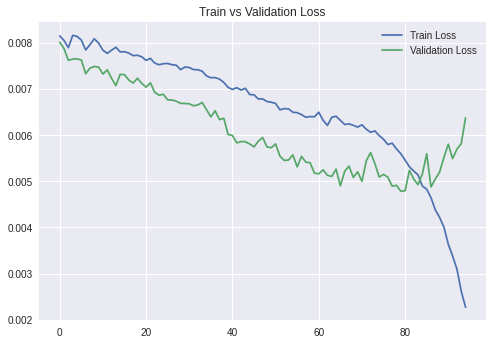

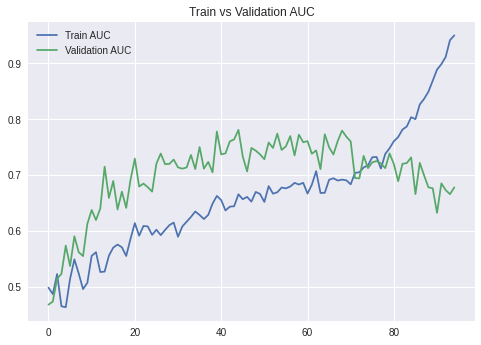

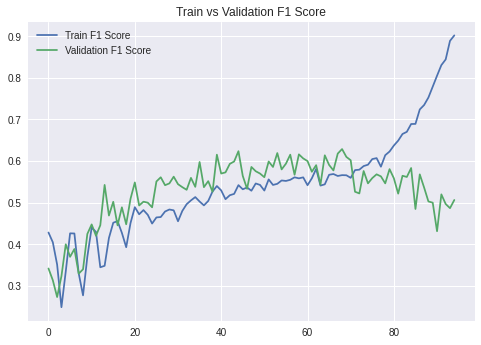


-------------------------------
Best metrics for validation set on Epoch 45:
Loss::      0.0058
AUC::       0.7809
Accuracy::  0.7877
F1::        0.6238
Precision:: 0.5250
Recall::    0.7683
Confusion Matrix:
 [[219  57]
 [ 19  63]]
-------------------------------

Metrics for train set on Epoch 45:
Loss::      0.0069
AUC::       0.6657
Accuracy::  0.5995
F1::        0.5422
Precision:: 0.4045
Recall::    0.8220
Confusion Matrix:
 [[628 605]
 [ 89 411]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet50',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 


-------------------------------
Best metrics for validation set on Epoch 28:
Loss::      0.0129
AUC::       0.8587
Accuracy::  0.7821
F1::        0.6777
Precision:: 0.5125
Recall::    1.0000
Confusion Matrix:
 [[198  78]
 [  0  82]]
-------------------------------

Metrics for train set on Epoch 28:
Loss::      0.0067
AUC::       0.7874
Accuracy::  0.8142
F1::        0.6922
Precision:: 0.6630
Recall::    0.7240
Confusion Matrix:
 [[1049  184]
 [ 138  362]]
-------------------------------




--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0073      Validation 0.0071
AUC::       Train 0.7883      Validation 0.7966
Accuracy::  Train 0.7098      Validation 0.7458
F1::        Train 0.6594      Validation 0.6160
Precision:: Train 0.4985      Validation 0.4710
Recall::    Train 0.9740      Validation 0.8902
Validation Confusion Matrix:
 [[194  82]
 [  9  73]]

Train Confusion Matrix:
 [[743 490]
 [ 13 487]]

Epoch 11 took 7.00 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7966

---------------------------------------------------------------------
Running Epoch 12 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0072      Validation 0.0071
AUC::       Train 0.8109      Validation 0.7748
Accuracy::  Train 0.7461      Validation 0.7849
F1::        Train 0.6866      Validation 0.6169
Precision:: Train 0.5332      Validation 0.5210
Recall::    Train 0.9640      Validation 0.7561
Validation Confusion Matrix:
 [[219  57]
 [ 20  62]]

Train Confusion Matrix:
 [[811 422]
 [ 18 482]]

Epoch 12 took 7.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0071      Validation 0.0070
AUC::       Train 0.8543      Validation 0.7051
Accuracy::  Train 0.8240      Validation 0.7765
F1::        Train 0.7522      Validation 0.5402
Precision:: Train 0.6334      Validation 0.5109
Recall::    Train 0.9260      Validation 0.5732
Validation Confusion Matrix:
 [[231  45]
 [ 35  47]]

Train Confusion Matrix:
 [[965 268]
 [ 37 463]]

Epoch 13 took 7.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0071      Validation 0.0069
AUC::       Train 0.8693      Validation 0.6586
Accuracy::  Train 0.8707      Validation 0.7709
F1::        Train 0.7945      Validation 0.4744
Precision:: Train 0.7339      Validation 0.5000
Recall::    Train 0.8660      Validation 0.4512
Validation Confusion Matrix:
 [[239  37]
 [ 45  37]]

Train Confusion Matrix:
 [[1076  157]
 [  67  433]]

Epoch 14 took 7.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  150
Loss::      Train 0.0070      Validation 0.0068
AUC::       Train 0.8686      Validation 0.6561
Accuracy::  Train 0.8857      Validation 0.7737
F1::        Train 0.8070      Validation 0.4706
Precision:: Train 0.7871      Validation 0.5070
Recall::    Train 0.8280      Validation 0.4390
Validation Confusion Matrix:
 [[241  35]
 [ 46  36]]

Train Confusion Matrix:
 [[1121  112]
 [  86  414]]

Epoch 15 took 6.6

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0030      Validation 0.0052
AUC::       Train 0.9974      Validation 0.6277
Accuracy::  Train 0.9971      Validation 0.7961
F1::        Train 0.9950      Validation 0.4160
Precision:: Train 0.9920      Validation 0.6047
Recall::    Train 0.9980      Validation 0.3171
Validation Confusion Matrix:
 [[259  17]
 [ 56  26]]

Train Confusion Matrix:
 [[1229    4]
 [   1  499]]

Epoch 38 took 6.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0028      Validation 0.0051
AUC::       Train 0.9982      Validation 0.6528
Accuracy::  Train 0.9983      Validation 0.8017
F1::        Train 0.9970      Validation 0.4662
Precision:: Train 0.9960      Validation 0.6078
Recall::    Train 0.9980      Validation 0.3780
Validation Confusion Matrix:
 [[256  20]
 [ 51  31]]

Train Confusion Matrix:
 [[1231    2]
 [   1  499]]

Epoch 39 took 6.65 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0026      Validation 0.0050
AUC::       Train 0.9992      Validation 0.6596
Accuracy::  Train 0.9988      Validation 0.7989
F1::        Train 0.9980      Validation 0.4783
Precision:: Train 0.9960      Validation 0.5893
Recall::    Train 1.0000      Validation 0.4024
Validation Confusion Matrix:
 [[253  23]
 [ 49  33]]

Train Confusion Matrix:
 [[1231    2]
 [   0  500]]

Epoch 40 took 6.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0023      Validation 0.0051
AUC::       Train 0.9988      Validation 0.6564
Accuracy::  Train 0.9983      Validation 0.8073
F1::        Train 0.9970      Validation 0.4733
Precision:: Train 0.9940      Validation 0.6327
Recall::    Train 1.0000      Validation 0.3780
Validation Confusion Matrix:
 [[258  18]
 [ 51  31]]

Train Confusion Matrix:
 [[1230    3]
 [   0  500]]

Epoch 41 took 6.62 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0021      Validation 0.0052
AUC::       Train 0.9992      Validation 0.6070
Accuracy::  Train 0.9988      Validation 0.7905
F1::        Train 0.9980      Validation 0.3697
Precision:: Train 0.9960      Validation 0.5946
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[261  15]
 [ 60  22]]

Train Confusion Matrix:
 [[1231    2]
 [   0  500]]

Epoch 42 took 6.77 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0021      Validation 0.0052
AUC::       Train 0.9992      Validation 0.6174
Accuracy::  Train 0.9988      Validation 0.7933
F1::        Train 0.9980      Validation 0.3934
Precision:: Train 0.9960      Validation 0.6000
Recall::    Train 1.0000      Validation 0.2927
Validation Confusion Matrix:
 [[260  16]
 [ 58  24]]

Train Confusion Matrix:
 [[1231    2]
 [   0  500]]

Epoch 43 took 6.67 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0021      Validation 0.0050
AUC::       Train 0.9988      Validation 0.6480
Accuracy::  Train 0.9983      Validation 0.7877
F1::        Train 0.9970      Validation 0.4571
Precision:: Train 0.9940      Validation 0.5517
Recall::    Train 1.0000      Validation 0.3902
Validation Confusion Matrix:
 [[250  26]
 [ 50  32]]

Train Confusion Matrix:
 [[1230    3]
 [   0  500]]

Epoch 44 took 6.65 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0018      Validation 0.0050
AUC::       Train 0.9992      Validation 0.6681
Accuracy::  Train 0.9988      Validation 0.7989
F1::        Train 0.9980      Validation 0.4930
Precision:: Train 0.9960      Validation 0.5833
Recall::    Train 1.0000      Validation 0.4268
Validation Confusion Matrix:
 [[251  25]
 [ 47  35]]

Train Confusion Matrix:
 [[1231    2]
 [   0  500]]

Epoch 45 took 6.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0017      Validation 0.0053
AUC::       Train 0.9988      Validation 0.6185
Accuracy::  Train 0.9983      Validation 0.8017
F1::        Train 0.9970      Validation 0.3932
Precision:: Train 0.9940      Validation 0.6571
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[264  12]
 [ 59  23]]

Train Confusion Matrix:
 [[1230    3]
 [   0  500]]

Epoch 46 took 6.64 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0014      Validation 0.0055
AUC::       Train 0.9992      Validation 0.5855
Accuracy::  Train 0.9988      Validation 0.7905
F1::        Train 0.9980      Validation 0.3119
Precision:: Train 0.9960      Validation 0.6296
Recall::    Train 1.0000      Validation 0.2073
Validation Confusion Matrix:
 [[266  10]
 [ 65  17]]

Train Confusion Matrix:
 [[1231    2]
 [   0  500]]

Epoch 47 took 6.65 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 48 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can o

Loss::      Train 0.0010      Validation 0.0056
AUC::       Train 0.9996      Validation 0.5837
Accuracy::  Train 0.9994      Validation 0.7877
F1::        Train 0.9990      Validation 0.3091
Precision:: Train 0.9980      Validation 0.6071
Recall::    Train 1.0000      Validation 0.2073
Validation Confusion Matrix:
 [[265  11]
 [ 65  17]]

Train Confusion Matrix:
 [[1232    1]
 [   0  500]]

Epoch 48 took 6.70 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/tor

Loss::      Train 0.0008      Validation 0.0059
AUC::       Train 1.0000      Validation 0.5691
Accuracy::  Train 1.0000      Validation 0.7849
F1::        Train 1.0000      Validation 0.2667
Precision:: Train 1.0000      Validation 0.6087
Recall::    Train 1.0000      Validation 0.1707
Validation Confusion Matrix:
 [[267   9]
 [ 68  14]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 49 took 6.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 50 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0008      Validation 0.0057
AUC::       Train 1.0000      Validation 0.5977
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3423
Precision:: Train 1.0000      Validation 0.6552
Recall::    Train 1.0000      Validation 0.2317
Validation Confusion Matrix:
 [[266  10]
 [ 63  19]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 50 took 6.71 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0007      Validation 0.0058
AUC::       Train 1.0000      Validation 0.5977
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3423
Precision:: Train 1.0000      Validation 0.6552
Recall::    Train 1.0000      Validation 0.2317
Validation Confusion Matrix:
 [[266  10]
 [ 63  19]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 51 took 6.72 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 52 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0005      Validation 0.0060
AUC::       Train 1.0000      Validation 0.5672
Accuracy::  Train 1.0000      Validation 0.7821
F1::        Train 1.0000      Validation 0.2642
Precision:: Train 1.0000      Validation 0.5833
Recall::    Train 1.0000      Validation 0.1707
Validation Confusion Matrix:
 [[266  10]
 [ 68  14]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 52 took 7.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0004      Validation 0.0062
AUC::       Train 1.0000      Validation 0.5630
Accuracy::  Train 1.0000      Validation 0.7821
F1::        Train 1.0000      Validation 0.2500
Precision:: Train 1.0000      Validation 0.5909
Recall::    Train 1.0000      Validation 0.1585
Validation Confusion Matrix:
 [[267   9]
 [ 69  13]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 53 took 7.81 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0004      Validation 0.0063
AUC::       Train 1.0000      Validation 0.5752
Accuracy::  Train 1.0000      Validation 0.7877
F1::        Train 1.0000      Validation 0.2830
Precision:: Train 1.0000      Validation 0.6250
Recall::    Train 1.0000      Validation 0.1829
Validation Confusion Matrix:
 [[267   9]
 [ 67  15]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 54 took 7.77 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0003      Validation 0.0066
AUC::       Train 1.0000      Validation 0.5569
Accuracy::  Train 1.0000      Validation 0.7793
F1::        Train 1.0000      Validation 0.2330
Precision:: Train 1.0000      Validation 0.5714
Recall::    Train 1.0000      Validation 0.1463
Validation Confusion Matrix:
 [[267   9]
 [ 70  12]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 55 took 7.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0003      Validation 0.0066
AUC::       Train 1.0000      Validation 0.5569
Accuracy::  Train 1.0000      Validation 0.7793
F1::        Train 1.0000      Validation 0.2330
Precision:: Train 1.0000      Validation 0.5714
Recall::    Train 1.0000      Validation 0.1463
Validation Confusion Matrix:
 [[267   9]
 [ 70  12]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 56 took 7.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  150
Loss::      Train 0.0003      Validation 0.0064
AUC::       Train 1.0000      Validation 0.5752
Accuracy::  Train 1.0000      Validation 0.7877
F1::        Train 1.0000      Validation 0.2830
Precision:: Train 1.0000      Validation 0.6250
Recall::    Train 1.0000      Validation 0.1829
Validation Confusion Matrix:
 [[267   9]
 [ 67  15]]

Train Confusion Matrix:
 [[1233    0]
 [   0  500]]

Epoch 57 took 6.6

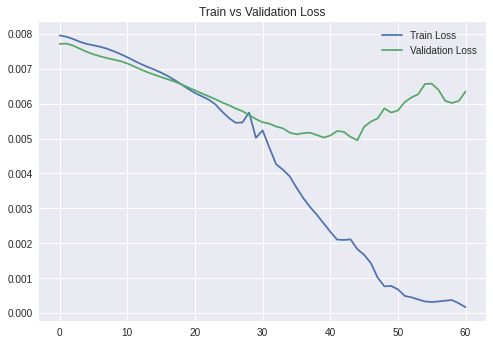

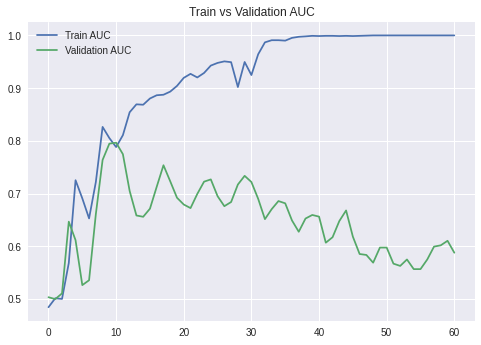

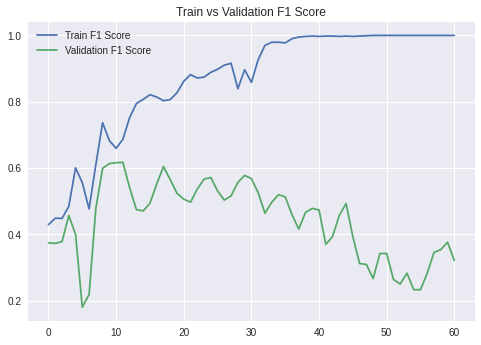


-------------------------------
Best metrics for validation set on Epoch 11:
Loss::      0.0071
AUC::       0.7966
Accuracy::  0.7458
F1::        0.6160
Precision:: 0.4710
Recall::    0.8902
Confusion Matrix:
 [[194  82]
 [  9  73]]
-------------------------------

Metrics for train set on Epoch 11:
Loss::      0.0073
AUC::       0.7883
Accuracy::  0.7098
F1::        0.6594
Precision:: 0.4985
Recall::    0.9740
Confusion Matrix:
 [[743 490]
 [ 13 487]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0083      Validation 0.0082
AUC::       Train 0.4104      Validation 0.5000
Accuracy::  Train 0.3716      Validation 0.2291
F1::        Train 0.3155      Validation 0.3727
Precision:: Train 0.2301      Validation 0.2291
Recall::    Train 0.5020      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[1179 2520]
 [ 747  753]]

Epoch 1 took 15.42 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0076      Validation 0.0075
AUC::       Train 0.5128      Validation 0.6436
Accuracy::  Train 0.3068      Validation 0.6620
F1::        Train 0.4543      Validation 0.4525
Precision:: Train 0.2939      Validation 0.3597
Recall::    Train 1.0000      Validation 0.6098
Validation Confusion Matrix:
 [[187  89]
 [ 32  50]]

Train Confusion Matrix:
 [[  95 3604]
 [   0 1500]]

Epoch 2 took 15.39 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.6436

---------------------------------------------------------------------
Running Epoch 3 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0078      Validation 0.0074
AUC::       Train 0.5239      Validation 0.4982
Accuracy::  Train 0.7201      Validation 0.7682
F1::        Train 0.1101      Validation 0.0000
Precision:: Train 0.6667      Validation 0.0000
Recall::    Train 0.0600      Validation 0.0000
Validation Confusion Matrix:
 [[275   1]
 [ 82   0]]

Train Confusion Matrix:
 [[3654   45]
 [1410   90]]

Epoch 3 took 15.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0079      Validation 0.0075
AUC::       Train 0.4175      Validation 0.5707
Accuracy::  Train 0.4684      Validation 0.3380
F1::        Train 0.2440      Validation 0.4090
Precision:: Train 0.2069      Validation 0.2571
Recall::    Train 0.2973      Validation 1.0000
Validation Confusion Matrix:
 [[ 39 237]
 [  0  82]]

Train Confusion Matrix:
 [[1989 1710]
 [1054  446]]

Epoch 4 took 15.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0075      Validation 0.0073
AUC::       Train 0.5869      Validation 0.7783
Accuracy::  Train 0.4122      Validation 0.6648
F1::        Train 0.4954      Validation 0.5745
Precision:: Train 0.3292      Validation 0.4050
Recall::    Train 1.0000      Validation 0.9878
Validation Confusion Matrix:
 [[157 119]
 [  1  81]]

Train Confusion Matrix:
 [[ 643 3056]
 [   0 1500]]

Epoch 5 took 15.52 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7783

---------------------------------------------------------------------
Running Epoch 6 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0074      Validation 0.0071
AUC::       Train 0.7386      Validation 0.5875
Accuracy::  Train 0.7501      Validation 0.7737
F1::        Train 0.6216      Validation 0.3306
Precision:: Train 0.5520      Validation 0.5128
Recall::    Train 0.7113      Validation 0.2439
Validation Confusion Matrix:
 [[257  19]
 [ 62  20]]

Train Confusion Matrix:
 [[2833  866]
 [ 433 1067]]

Epoch 6 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 7 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0075      Validation 0.0070
AUC::       Train 0.6360      Validation 0.8033
Accuracy::  Train 0.7374      Validation 0.7430
F1::        Train 0.4653      Validation 0.6198
Precision:: Train 0.5641      Validation 0.4688
Recall::    Train 0.3960      Validation 0.9146
Validation Confusion Matrix:
 [[191  85]
 [  7  75]]

Train Confusion Matrix:
 [[3240  459]
 [ 906  594]]

Epoch 7 took 15.45 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8033

---------------------------------------------------------------------
Running Epoch 8 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0073      Validation 0.0069
AUC::       Train 0.7172      Validation 0.8035
Accuracy::  Train 0.6092      Validation 0.7235
F1::        Train 0.5895      Validation 0.6118
Precision:: Train 0.4229      Validation 0.4509
Recall::    Train 0.9727      Validation 0.9512
Validation Confusion Matrix:
 [[181  95]
 [  4  78]]

Train Confusion Matrix:
 [[1708 1991]
 [  41 1459]]

Epoch 8 took 15.48 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8035

---------------------------------------------------------------------
Running Epoch 9 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0070      Validation 0.0067
AUC::       Train 0.7878      Validation 0.7252
Accuracy::  Train 0.7336      Validation 0.7877
F1::        Train 0.6649      Validation 0.5682
Precision:: Train 0.5218      Validation 0.5319
Recall::    Train 0.9160      Validation 0.6098
Validation Confusion Matrix:
 [[232  44]
 [ 32  50]]

Train Confusion Matrix:
 [[2440 1259]
 [ 126 1374]]

Epoch 9 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 10 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0070      Validation 0.0066
AUC::       Train 0.7993      Validation 0.8231
Accuracy::  Train 0.8111      Validation 0.7933
F1::        Train 0.7021      Validation 0.6606
Precision:: Train 0.6442      Validation 0.5294
Recall::    Train 0.7713      Validation 0.8780
Validation Confusion Matrix:
 [[212  64]
 [ 10  72]]

Train Confusion Matrix:
 [[3060  639]
 [ 343 1157]]

Epoch 10 took 15.39 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8231

---------------------------------------------------------------------
Running Epoch 11 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0068      Validation 0.0064
AUC::       Train 0.7899      Validation 0.8127
Accuracy::  Train 0.7176      Validation 0.7905
F1::        Train 0.6625      Validation 0.6512
Precision:: Train 0.5056      Validation 0.5263
Recall::    Train 0.9607      Validation 0.8537
Validation Confusion Matrix:
 [[213  63]
 [ 12  70]]

Train Confusion Matrix:
 [[2290 1409]
 [  59 1441]]

Epoch 11 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0067      Validation 0.0062
AUC::       Train 0.8250      Validation 0.7479
Accuracy::  Train 0.7950      Validation 0.7765
F1::        Train 0.7160      Validation 0.5876
Precision:: Train 0.5963      Validation 0.5089
Recall::    Train 0.8960      Validation 0.6951
Validation Confusion Matrix:
 [[221  55]
 [ 25  57]]

Train Confusion Matrix:
 [[2789  910]
 [ 156 1344]]

Epoch 12 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0065      Validation 0.0060
AUC::       Train 0.8321      Validation 0.7797
Accuracy::  Train 0.7909      Validation 0.7793
F1::        Train 0.7195      Validation 0.6184
Precision:: Train 0.5869      Validation 0.5120
Recall::    Train 0.9293      Validation 0.7805
Validation Confusion Matrix:
 [[215  61]
 [ 18  64]]

Train Confusion Matrix:
 [[2718  981]
 [ 106 1394]]

Epoch 13 took 15.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0062      Validation 0.0058
AUC::       Train 0.8395      Validation 0.7387
Accuracy::  Train 0.7936      Validation 0.7821
F1::        Train 0.7261      Validation 0.5806
Precision:: Train 0.5883      Validation 0.5192
Recall::    Train 0.9480      Validation 0.6585
Validation Confusion Matrix:
 [[226  50]
 [ 28  54]]

Train Confusion Matrix:
 [[2704  995]
 [  78 1422]]

Epoch 14 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0061      Validation 0.0056
AUC::       Train 0.8451      Validation 0.7626
Accuracy::  Train 0.8092      Validation 0.7793
F1::        Train 0.7377      Validation 0.6030
Precision:: Train 0.6113      Validation 0.5128
Recall::    Train 0.9300      Validation 0.7317
Validation Confusion Matrix:
 [[219  57]
 [ 22  60]]

Train Confusion Matrix:
 [[2812  887]
 [ 105 1395]]

Epoch 15 took 15.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0054
AUC::       Train 0.8410      Validation 0.7337
Accuracy::  Train 0.7890      Validation 0.7877
F1::        Train 0.7250      Validation 0.5778
Precision:: Train 0.5810      Validation 0.5306
Recall::    Train 0.9640      Validation 0.6341
Validation Confusion Matrix:
 [[230  46]
 [ 30  52]]

Train Confusion Matrix:
 [[2656 1043]
 [  54 1446]]

Epoch 16 took 15.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 17 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0054      Validation 0.0052
AUC::       Train 0.8909      Validation 0.7430
Accuracy::  Train 0.8580      Validation 0.7821
F1::        Train 0.7975      Validation 0.5851
Precision:: Train 0.6777      Validation 0.5189
Recall::    Train 0.9687      Validation 0.6707
Validation Confusion Matrix:
 [[225  51]
 [ 27  55]]

Train Confusion Matrix:
 [[3008  691]
 [  47 1453]]

Epoch 17 took 15.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 18 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0049      Validation 0.0052
AUC::       Train 0.9092      Validation 0.7245
Accuracy::  Train 0.8750      Validation 0.7933
F1::        Train 0.8204      Validation 0.5698
Precision:: Train 0.7005      Validation 0.5444
Recall::    Train 0.9900      Validation 0.5976
Validation Confusion Matrix:
 [[235  41]
 [ 33  49]]

Train Confusion Matrix:
 [[3064  635]
 [  15 1485]]

Epoch 18 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 19 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0048      Validation 0.0051
AUC::       Train 0.9129      Validation 0.7168
Accuracy::  Train 0.8825      Validation 0.7682
F1::        Train 0.8286      Validation 0.5514
Precision:: Train 0.7153      Validation 0.4951
Recall::    Train 0.9847      Validation 0.6220
Validation Confusion Matrix:
 [[224  52]
 [ 31  51]]

Train Confusion Matrix:
 [[3111  588]
 [  23 1477]]

Epoch 19 took 15.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0046      Validation 0.0051
AUC::       Train 0.9043      Validation 0.7100
Accuracy::  Train 0.8736      Validation 0.7709
F1::        Train 0.8168      Validation 0.5444
Precision:: Train 0.7020      Validation 0.5000
Recall::    Train 0.9767      Validation 0.5976
Validation Confusion Matrix:
 [[227  49]
 [ 33  49]]

Train Confusion Matrix:
 [[3077  622]
 [  35 1465]]

Epoch 20 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 21 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0041      Validation 0.0052
AUC::       Train 0.9458      Validation 0.6996
Accuracy::  Train 0.9258      Validation 0.7682
F1::        Train 0.8853      Validation 0.5311
Precision:: Train 0.7985      Validation 0.4947
Recall::    Train 0.9933      Validation 0.5732
Validation Confusion Matrix:
 [[228  48]
 [ 35  47]]

Train Confusion Matrix:
 [[3323  376]
 [  10 1490]]

Epoch 21 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0035      Validation 0.0055
AUC::       Train 0.9702      Validation 0.6653
Accuracy::  Train 0.9579      Validation 0.7682
F1::        Train 0.9319      Validation 0.4845
Precision:: Train 0.8730      Validation 0.4937
Recall::    Train 0.9993      Validation 0.4756
Validation Confusion Matrix:
 [[236  40]
 [ 43  39]]

Train Confusion Matrix:
 [[3481  218]
 [   1 1499]]

Epoch 22 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 23 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0031      Validation 0.0056
AUC::       Train 0.9785      Validation 0.6793
Accuracy::  Train 0.9700      Validation 0.7765
F1::        Train 0.9505      Validation 0.5062
Precision:: Train 0.9068      Validation 0.5125
Recall::    Train 0.9987      Validation 0.5000
Validation Confusion Matrix:
 [[237  39]
 [ 41  41]]

Train Confusion Matrix:
 [[3545  154]
 [   2 1498]]

Epoch 23 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0028      Validation 0.0058
AUC::       Train 0.9836      Validation 0.6550
Accuracy::  Train 0.9775      Validation 0.7654
F1::        Train 0.9624      Validation 0.4684
Precision:: Train 0.9292      Validation 0.4868
Recall::    Train 0.9980      Validation 0.4512
Validation Confusion Matrix:
 [[237  39]
 [ 45  37]]

Train Confusion Matrix:
 [[3585  114]
 [   3 1497]]

Epoch 24 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0026      Validation 0.0058
AUC::       Train 0.9862      Validation 0.6915
Accuracy::  Train 0.9812      Validation 0.7821
F1::        Train 0.9683      Validation 0.5244
Precision:: Train 0.9403      Validation 0.5244
Recall::    Train 0.9980      Validation 0.5244
Validation Confusion Matrix:
 [[237  39]
 [ 39  43]]

Train Confusion Matrix:
 [[3604   95]
 [   3 1497]]

Epoch 25 took 15.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0022      Validation 0.0058
AUC::       Train 0.9896      Validation 0.6678
Accuracy::  Train 0.9858      Validation 0.7654
F1::        Train 0.9759      Validation 0.4878
Precision:: Train 0.9541      Validation 0.4878
Recall::    Train 0.9987      Validation 0.4878
Validation Confusion Matrix:
 [[234  42]
 [ 42  40]]

Train Confusion Matrix:
 [[3627   72]
 [   2 1498]]

Epoch 26 took 15.54 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0020      Validation 0.0059
AUC::       Train 0.9894      Validation 0.6922
Accuracy::  Train 0.9852      Validation 0.7765
F1::        Train 0.9750      Validation 0.5238
Precision:: Train 0.9517      Validation 0.5116
Recall::    Train 0.9993      Validation 0.5366
Validation Confusion Matrix:
 [[234  42]
 [ 38  44]]

Train Confusion Matrix:
 [[3623   76]
 [   1 1499]]

Epoch 27 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0016      Validation 0.0061
AUC::       Train 0.9934      Validation 0.7184
Accuracy::  Train 0.9912      Validation 0.7905
F1::        Train 0.9849      Validation 0.5614
Precision:: Train 0.9715      Validation 0.5393
Recall::    Train 0.9987      Validation 0.5854
Validation Confusion Matrix:
 [[235  41]
 [ 34  48]]

Train Confusion Matrix:
 [[3655   44]
 [   2 1498]]

Epoch 28 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0011      Validation 0.0070
AUC::       Train 0.9984      Validation 0.6268
Accuracy::  Train 0.9977      Validation 0.7682
F1::        Train 0.9960      Validation 0.4196
Precision:: Train 0.9921      Validation 0.4918
Recall::    Train 1.0000      Validation 0.3659
Validation Confusion Matrix:
 [[245  31]
 [ 52  30]]

Train Confusion Matrix:
 [[3687   12]
 [   0 1500]]

Epoch 29 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0007      Validation 0.0084
AUC::       Train 0.9995      Validation 0.6011
Accuracy::  Train 0.9992      Validation 0.7682
F1::        Train 0.9987      Validation 0.3664
Precision:: Train 0.9973      Validation 0.4898
Recall::    Train 1.0000      Validation 0.2927
Validation Confusion Matrix:
 [[251  25]
 [ 58  24]]

Train Confusion Matrix:
 [[3695    4]
 [   0 1500]]

Epoch 30 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0005      Validation 0.0069
AUC::       Train 1.0000      Validation 0.6854
Accuracy::  Train 1.0000      Validation 0.7793
F1::        Train 1.0000      Validation 0.5153
Precision:: Train 1.0000      Validation 0.5185
Recall::    Train 1.0000      Validation 0.5122
Validation Confusion Matrix:
 [[237  39]
 [ 40  42]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 31 took 15.78 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-pa

Loss::      Train 0.0003      Validation 0.0099
AUC::       Train 1.0000      Validation 0.5643
Accuracy::  Train 1.0000      Validation 0.7709
F1::        Train 1.0000      Validation 0.2679
Precision:: Train 1.0000      Validation 0.5000
Recall::    Train 1.0000      Validation 0.1829
Validation Confusion Matrix:
 [[261  15]
 [ 67  15]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 32 took 15.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0002      Validation 0.0072
AUC::       Train 1.0000      Validation 0.6854
Accuracy::  Train 1.0000      Validation 0.7793
F1::        Train 1.0000      Validation 0.5153
Precision:: Train 1.0000      Validation 0.5185
Recall::    Train 1.0000      Validation 0.5122
Validation Confusion Matrix:
 [[237  39]
 [ 40  42]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 33 took 16.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0002      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5674
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.2857
Precision:: Train 1.0000      Validation 0.4595
Recall::    Train 1.0000      Validation 0.2073
Validation Confusion Matrix:
 [[256  20]
 [ 65  17]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 34 took 16.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0002      Validation 0.0088
AUC::       Train 1.0000      Validation 0.6225
Accuracy::  Train 1.0000      Validation 0.7682
F1::        Train 1.0000      Validation 0.4113
Precision:: Train 1.0000      Validation 0.4915
Recall::    Train 1.0000      Validation 0.3537
Validation Confusion Matrix:
 [[246  30]
 [ 53  29]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 35 took 16.63 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0082
AUC::       Train 1.0000      Validation 0.6335
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.4324
Precision:: Train 1.0000      Validation 0.4848
Recall::    Train 1.0000      Validation 0.3902
Validation Confusion Matrix:
 [[242  34]
 [ 50  32]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 36 took 16.04 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0106
AUC::       Train 1.0000      Validation 0.5821
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.3226
Precision:: Train 1.0000      Validation 0.4762
Recall::    Train 1.0000      Validation 0.2439
Validation Confusion Matrix:
 [[254  22]
 [ 62  20]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 37 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5943
Accuracy::  Train 1.0000      Validation 0.7709
F1::        Train 1.0000      Validation 0.3492
Precision:: Train 1.0000      Validation 0.5000
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[254  22]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 38 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0090
AUC::       Train 1.0000      Validation 0.6207
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.4085
Precision:: Train 1.0000      Validation 0.4833
Recall::    Train 1.0000      Validation 0.3537
Validation Confusion Matrix:
 [[245  31]
 [ 53  29]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 39 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0092
AUC::       Train 1.0000      Validation 0.6121
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.3913
Precision:: Train 1.0000      Validation 0.4821
Recall::    Train 1.0000      Validation 0.3293
Validation Confusion Matrix:
 [[247  29]
 [ 55  27]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 40 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0103
AUC::       Train 1.0000      Validation 0.5986
Accuracy::  Train 1.0000      Validation 0.7709
F1::        Train 1.0000      Validation 0.3594
Precision:: Train 1.0000      Validation 0.5000
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[253  23]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 41 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0107
AUC::       Train 1.0000      Validation 0.5943
Accuracy::  Train 1.0000      Validation 0.7709
F1::        Train 1.0000      Validation 0.3492
Precision:: Train 1.0000      Validation 0.5000
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[254  22]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 42 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0104
AUC::       Train 1.0000      Validation 0.5968
Accuracy::  Train 1.0000      Validation 0.7682
F1::        Train 1.0000      Validation 0.3566
Precision:: Train 1.0000      Validation 0.4894
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[252  24]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 43 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0100
AUC::       Train 1.0000      Validation 0.6017
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3704
Precision:: Train 1.0000      Validation 0.4717
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[248  28]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 44 took 15.59 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0101
AUC::       Train 1.0000      Validation 0.6017
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3704
Precision:: Train 1.0000      Validation 0.4717
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[248  28]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 45 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0103
AUC::       Train 1.0000      Validation 0.6035
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.3731
Precision:: Train 1.0000      Validation 0.4808
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[249  27]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 46 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 47 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 48 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0106
AUC::       Train 1.0000      Validation 0.5907
Accuracy::  Train 1.0000      Validation 0.7654
F1::        Train 1.0000      Validation 0.3438
Precision:: Train 1.0000      Validation 0.4783
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[252  24]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 48 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0106
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 49 took 15.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 50 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5913
Accuracy::  Train 1.0000      Validation 0.7598
F1::        Train 1.0000      Validation 0.3485
Precision:: Train 1.0000      Validation 0.4600
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[249  27]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 50 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5913
Accuracy::  Train 1.0000      Validation 0.7598
F1::        Train 1.0000      Validation 0.3485
Precision:: Train 1.0000      Validation 0.4600
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[249  27]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 51 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 52 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0105
AUC::       Train 1.0000      Validation 0.5931
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3511
Precision:: Train 1.0000      Validation 0.4694
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[250  26]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 52 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0107
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 53 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0107
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 54 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0107
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 55 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0107
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 56 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0108
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 57 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 58 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0108
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 58 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 59 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0108
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 59 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 60 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0000      Validation 0.0108
AUC::       Train 1.0000      Validation 0.5889
Accuracy::  Train 1.0000      Validation 0.7626
F1::        Train 1.0000      Validation 0.3411
Precision:: Train 1.0000      Validation 0.4681
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[251  25]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 60 took 15.45 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 50 epochs
Saving model at: 


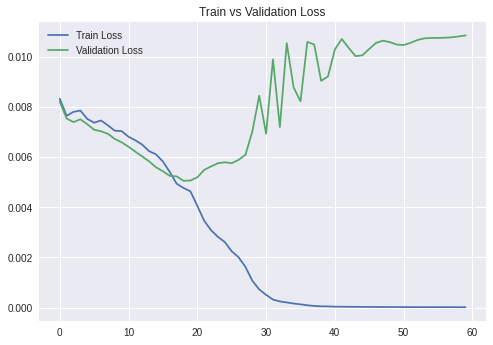

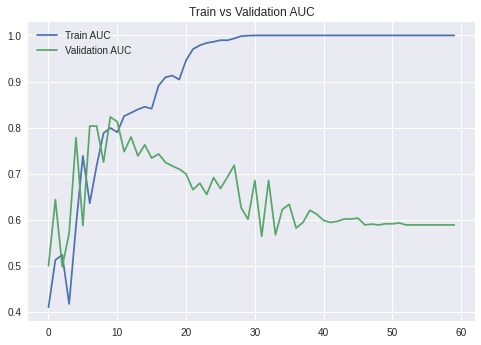

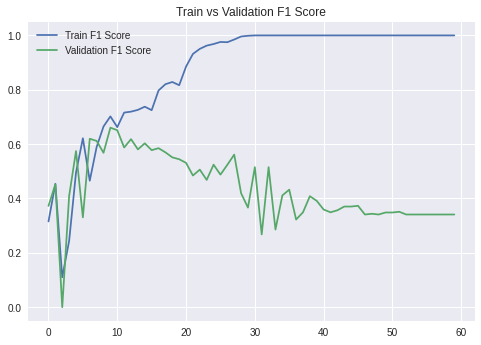


-------------------------------
Best metrics for validation set on Epoch 10:
Loss::      0.0066
AUC::       0.8231
Accuracy::  0.7933
F1::        0.6606
Precision:: 0.5294
Recall::    0.8780
Confusion Matrix:
 [[212  64]
 [ 10  72]]
-------------------------------

Metrics for train set on Epoch 10:
Loss::      0.0070
AUC::       0.7993
Accuracy::  0.8111
F1::        0.7021
Precision:: 0.6442
Recall::    0.7713
Confusion Matrix:
 [[3060  639]
 [ 343 1157]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0081      Validation 0.0080
AUC::       Train 0.4822      Validation 0.5000
Accuracy::  Train 0.3012      Validation 0.2291
F1::        Train 0.4290      Validation 0.3727
Precision:: Train 0.2807      Validation 0.2291
Recall::    Train 0.9100      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[ 201 3498]
 [ 135 1365]]

Epoch 1 took 15.45 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0076
AUC::       Train 0.5019      Validation 0.5589
Accuracy::  Train 0.2912      Validation 0.3464
F1::        Train 0.4488      Validation 0.4000
Precision:: Train 0.2893      Validation 0.2532
Recall::    Train 1.0000      Validation 0.9512
Validation Confusion Matrix:
 [[ 46 230]
 [  4  78]]

Train Confusion Matrix:
 [[  14 3685]
 [   0 1500]]

Epoch 2 took 15.49 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5589

---------------------------------------------------------------------
Running Epoch 3 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0074
AUC::       Train 0.5453      Validation 0.4964
Accuracy::  Train 0.7051      Validation 0.7654
F1::        Train 0.2467      Validation 0.0000
Precision:: Train 0.4692      Validation 0.0000
Recall::    Train 0.1673      Validation 0.0000
Validation Confusion Matrix:
 [[274   2]
 [ 82   0]]

Train Confusion Matrix:
 [[3415  284]
 [1249  251]]

Epoch 3 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0078      Validation 0.0075
AUC::       Train 0.4505      Validation 0.7245
Accuracy::  Train 0.5915      Validation 0.5950
F1::        Train 0.1422      Validation 0.5215
Precision:: Train 0.1803      Validation 0.3575
Recall::    Train 0.1173      Validation 0.9634
Validation Confusion Matrix:
 [[134 142]
 [  3  79]]

Train Confusion Matrix:
 [[2899  800]
 [1324  176]]

Epoch 4 took 15.43 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7245

---------------------------------------------------------------------
Running Epoch 5 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0076      Validation 0.0074
AUC::       Train 0.5676      Validation 0.7083
Accuracy::  Train 0.3878      Validation 0.5503
F1::        Train 0.4834      Validation 0.5046
Precision:: Train 0.3195      Validation 0.3374
Recall::    Train 0.9927      Validation 1.0000
Validation Confusion Matrix:
 [[115 161]
 [  0  82]]

Train Confusion Matrix:
 [[ 527 3172]
 [  11 1489]]

Epoch 5 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0075      Validation 0.0072
AUC::       Train 0.6731      Validation 0.7262
Accuracy::  Train 0.5509      Validation 0.7430
F1::        Train 0.5528      Validation 0.5534
Precision:: Train 0.3878      Validation 0.4597
Recall::    Train 0.9620      Validation 0.6951
Validation Confusion Matrix:
 [[209  67]
 [ 25  57]]

Train Confusion Matrix:
 [[1421 2278]
 [  57 1443]]

Epoch 6 took 15.55 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7262

---------------------------------------------------------------------
Running Epoch 7 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0075      Validation 0.0072
AUC::       Train 0.6905      Validation 0.6807
Accuracy::  Train 0.7586      Validation 0.7654
F1::        Train 0.5586      Validation 0.5059
Precision:: Train 0.5912      Validation 0.4886
Recall::    Train 0.5293      Validation 0.5244
Validation Confusion Matrix:
 [[231  45]
 [ 39  43]]

Train Confusion Matrix:
 [[3150  549]
 [ 706  794]]

Epoch 7 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0074      Validation 0.0071
AUC::       Train 0.7170      Validation 0.7809
Accuracy::  Train 0.7169      Validation 0.7151
F1::        Train 0.5938      Validation 0.5920
Precision:: Train 0.5066      Validation 0.4405
Recall::    Train 0.7173      Validation 0.9024
Validation Confusion Matrix:
 [[182  94]
 [  8  74]]

Train Confusion Matrix:
 [[2651 1048]
 [ 424 1076]]

Epoch 8 took 15.49 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7809

---------------------------------------------------------------------
Running Epoch 9 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0073      Validation 0.0070
AUC::       Train 0.7195      Validation 0.7808
Accuracy::  Train 0.6245      Validation 0.7346
F1::        Train 0.5920      Validation 0.5992
Precision:: Train 0.4312      Validation 0.4581
Recall::    Train 0.9440      Validation 0.8659
Validation Confusion Matrix:
 [[192  84]
 [ 11  71]]

Train Confusion Matrix:
 [[1831 1868]
 [  84 1416]]

Epoch 9 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 10 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0072      Validation 0.0069
AUC::       Train 0.7711      Validation 0.7150
Accuracy::  Train 0.7321      Validation 0.7654
F1::        Train 0.6503      Validation 0.5484
Precision:: Train 0.5215      Validation 0.4904
Recall::    Train 0.8633      Validation 0.6220
Validation Confusion Matrix:
 [[223  53]
 [ 31  51]]

Train Confusion Matrix:
 [[2511 1188]
 [ 205 1295]]

Epoch 10 took 15.64 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 11 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0071      Validation 0.0068
AUC::       Train 0.7845      Validation 0.7432
Accuracy::  Train 0.7805      Validation 0.7626
F1::        Train 0.6761      Validation 0.5771
Precision:: Train 0.5887      Validation 0.4874
Recall::    Train 0.7940      Validation 0.7073
Validation Confusion Matrix:
 [[215  61]
 [ 24  58]]

Train Confusion Matrix:
 [[2867  832]
 [ 309 1191]]

Epoch 11 took 15.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0070      Validation 0.0067
AUC::       Train 0.7821      Validation 0.7883
Accuracy::  Train 0.7317      Validation 0.7793
F1::        Train 0.6597      Validation 0.6256
Precision:: Train 0.5202      Validation 0.5116
Recall::    Train 0.9013      Validation 0.8049
Validation Confusion Matrix:
 [[213  63]
 [ 16  66]]

Train Confusion Matrix:
 [[2452 1247]
 [ 148 1352]]

Epoch 12 took 15.77 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7883

---------------------------------------------------------------------
Running Epoch 13 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0069      Validation 0.0066
AUC::       Train 0.8062      Validation 0.7150
Accuracy::  Train 0.7653      Validation 0.7654
F1::        Train 0.6894      Validation 0.5484
Precision:: Train 0.5577      Validation 0.4904
Recall::    Train 0.9027      Validation 0.6220
Validation Confusion Matrix:
 [[223  53]
 [ 31  51]]

Train Confusion Matrix:
 [[2625 1074]
 [ 146 1354]]

Epoch 13 took 16.31 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0068      Validation 0.0065
AUC::       Train 0.8320      Validation 0.7265
Accuracy::  Train 0.8134      Validation 0.7765
F1::        Train 0.7304      Validation 0.5652
Precision:: Train 0.6263      Validation 0.5098
Recall::    Train 0.8760      Validation 0.6341
Validation Confusion Matrix:
 [[226  50]
 [ 30  52]]

Train Confusion Matrix:
 [[2915  784]
 [ 186 1314]]

Epoch 14 took 16.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0066      Validation 0.0064
AUC::       Train 0.8320      Validation 0.7606
Accuracy::  Train 0.7953      Validation 0.7961
F1::        Train 0.7215      Validation 0.6096
Precision:: Train 0.5940      Validation 0.5429
Recall::    Train 0.9187      Validation 0.6951
Validation Confusion Matrix:
 [[228  48]
 [ 25  57]]

Train Confusion Matrix:
 [[2757  942]
 [ 122 1378]]

Epoch 15 took 16.57 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0065      Validation 0.0062
AUC::       Train 0.8455      Validation 0.7252
Accuracy::  Train 0.8148      Validation 0.7877
F1::        Train 0.7409      Validation 0.5682
Precision:: Train 0.6211      Validation 0.5319
Recall::    Train 0.9180      Validation 0.6098
Validation Confusion Matrix:
 [[232  44]
 [ 32  50]]

Train Confusion Matrix:
 [[2859  840]
 [ 123 1377]]

Epoch 16 took 16.11 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 17 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0064      Validation 0.0061
AUC::       Train 0.8473      Validation 0.7459
Accuracy::  Train 0.8182      Validation 0.7933
F1::        Train 0.7441      Validation 0.5934
Precision:: Train 0.6265      Validation 0.5400
Recall::    Train 0.9160      Validation 0.6585
Validation Confusion Matrix:
 [[230  46]
 [ 28  54]]

Train Confusion Matrix:
 [[2880  819]
 [ 126 1374]]

Epoch 17 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 18 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0062      Validation 0.0059
AUC::       Train 0.8523      Validation 0.7234
Accuracy::  Train 0.8188      Validation 0.7849
F1::        Train 0.7479      Validation 0.5650
Precision:: Train 0.6248      Validation 0.5263
Recall::    Train 0.9313      Validation 0.6098
Validation Confusion Matrix:
 [[231  45]
 [ 32  50]]

Train Confusion Matrix:
 [[2860  839]
 [ 103 1397]]

Epoch 18 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 19 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0060      Validation 0.0058
AUC::       Train 0.8684      Validation 0.7392
Accuracy::  Train 0.8386      Validation 0.7961
F1::        Train 0.7705      Validation 0.5876
Precision:: Train 0.6534      Validation 0.5474
Recall::    Train 0.9387      Validation 0.6341
Validation Confusion Matrix:
 [[233  43]
 [ 30  52]]

Train Confusion Matrix:
 [[2952  747]
 [  92 1408]]

Epoch 19 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0057      Validation 0.0057
AUC::       Train 0.8864      Validation 0.7306
Accuracy::  Train 0.8575      Validation 0.7961
F1::        Train 0.7945      Validation 0.5780
Precision:: Train 0.6803      Validation 0.5495
Recall::    Train 0.9547      Validation 0.6098
Validation Confusion Matrix:
 [[235  41]
 [ 32  50]]

Train Confusion Matrix:
 [[3026  673]
 [  68 1432]]

Epoch 20 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 21 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0056      Validation 0.0055
AUC::       Train 0.8867      Validation 0.7288
Accuracy::  Train 0.8596      Validation 0.7933
F1::        Train 0.7962      Validation 0.5747
Precision:: Train 0.6849      Validation 0.5435
Recall::    Train 0.9507      Validation 0.6098
Validation Confusion Matrix:
 [[234  42]
 [ 32  50]]

Train Confusion Matrix:
 [[3043  656]
 [  74 1426]]

Epoch 21 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0051      Validation 0.0055
AUC::       Train 0.9225      Validation 0.7110
Accuracy::  Train 0.9009      Validation 0.7989
F1::        Train 0.8501      Validation 0.5556
Precision:: Train 0.7545      Validation 0.5625
Recall::    Train 0.9733      Validation 0.5488
Validation Confusion Matrix:
 [[241  35]
 [ 37  45]]

Train Confusion Matrix:
 [[3224  475]
 [  40 1460]]

Epoch 22 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 23 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0050      Validation 0.0053
AUC::       Train 0.9207      Validation 0.7453
Accuracy::  Train 0.9002      Validation 0.7989
F1::        Train 0.8486      Validation 0.5955
Precision:: Train 0.7545      Validation 0.5521
Recall::    Train 0.9693      Validation 0.6463
Validation Confusion Matrix:
 [[233  43]
 [ 29  53]]

Train Confusion Matrix:
 [[3226  473]
 [  46 1454]]

Epoch 23 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0047      Validation 0.0053
AUC::       Train 0.9306      Validation 0.7135
Accuracy::  Train 0.9094      Validation 0.7961
F1::        Train 0.8620      Validation 0.5576
Precision:: Train 0.7689      Validation 0.5542
Recall::    Train 0.9807      Validation 0.5610
Validation Confusion Matrix:
 [[239  37]
 [ 36  46]]

Train Confusion Matrix:
 [[3257  442]
 [  29 1471]]

Epoch 24 took 15.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0045      Validation 0.0051
AUC::       Train 0.9421      Validation 0.7532
Accuracy::  Train 0.9256      Validation 0.8045
F1::        Train 0.8838      Validation 0.6067
Precision:: Train 0.8039      Validation 0.5625
Recall::    Train 0.9813      Validation 0.6585
Validation Confusion Matrix:
 [[234  42]
 [ 28  54]]

Train Confusion Matrix:
 [[3340  359]
 [  28 1472]]

Epoch 25 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0041      Validation 0.0053
AUC::       Train 0.9544      Validation 0.6915
Accuracy::  Train 0.9396      Validation 0.7821
F1::        Train 0.9043      Validation 0.5244
Precision:: Train 0.8328      Validation 0.5244
Recall::    Train 0.9893      Validation 0.5244
Validation Confusion Matrix:
 [[237  39]
 [ 39  43]]

Train Confusion Matrix:
 [[3401  298]
 [  16 1484]]

Epoch 26 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0037      Validation 0.0053
AUC::       Train 0.9697      Validation 0.7196
Accuracy::  Train 0.9583      Validation 0.7989
F1::        Train 0.9323      Validation 0.5663
Precision:: Train 0.8758      Validation 0.5595
Recall::    Train 0.9967      Validation 0.5732
Validation Confusion Matrix:
 [[239  37]
 [ 35  47]]

Train Confusion Matrix:
 [[3487  212]
 [   5 1495]]

Epoch 27 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0035      Validation 0.0054
AUC::       Train 0.9768      Validation 0.6866
Accuracy::  Train 0.9685      Validation 0.7877
F1::        Train 0.9480      Validation 0.5190
Precision:: Train 0.9039      Validation 0.5395
Recall::    Train 0.9967      Validation 0.5000
Validation Confusion Matrix:
 [[241  35]
 [ 41  41]]

Train Confusion Matrix:
 [[3540  159]
 [   5 1495]]

Epoch 28 took 15.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0032      Validation 0.0054
AUC::       Train 0.9800      Validation 0.6896
Accuracy::  Train 0.9721      Validation 0.7989
F1::        Train 0.9538      Validation 0.5263
Precision:: Train 0.9129      Validation 0.5714
Recall::    Train 0.9987      Validation 0.4878
Validation Confusion Matrix:
 [[246  30]
 [ 42  40]]

Train Confusion Matrix:
 [[3556  143]
 [   2 1498]]

Epoch 29 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0027      Validation 0.0057
AUC::       Train 0.9905      Validation 0.6889
Accuracy::  Train 0.9867      Validation 0.8045
F1::        Train 0.9775      Validation 0.5270
Precision:: Train 0.9566      Validation 0.5909
Recall::    Train 0.9993      Validation 0.4756
Validation Confusion Matrix:
 [[249  27]
 [ 43  39]]

Train Confusion Matrix:
 [[3631   68]
 [   1 1499]]

Epoch 30 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0027      Validation 0.0057
AUC::       Train 0.9868      Validation 0.6871
Accuracy::  Train 0.9812      Validation 0.8017
F1::        Train 0.9684      Validation 0.5235
Precision:: Train 0.9387      Validation 0.5821
Recall::    Train 1.0000      Validation 0.4756
Validation Confusion Matrix:
 [[248  28]
 [ 43  39]]

Train Confusion Matrix:
 [[3601   98]
 [   0 1500]]

Epoch 31 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0024      Validation 0.0056
AUC::       Train 0.9895      Validation 0.6988
Accuracy::  Train 0.9867      Validation 0.7933
F1::        Train 0.9774      Validation 0.5375
Precision:: Train 0.9595      Validation 0.5513
Recall::    Train 0.9960      Validation 0.5244
Validation Confusion Matrix:
 [[241  35]
 [ 39  43]]

Train Confusion Matrix:
 [[3636   63]
 [   6 1494]]

Epoch 32 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0022      Validation 0.0060
AUC::       Train 0.9922      Validation 0.6932
Accuracy::  Train 0.9888      Validation 0.8045
F1::        Train 0.9810      Validation 0.5333
Precision:: Train 0.9628      Validation 0.5882
Recall::    Train 1.0000      Validation 0.4878
Validation Confusion Matrix:
 [[248  28]
 [ 42  40]]

Train Confusion Matrix:
 [[3641   58]
 [   0 1500]]

Epoch 33 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0018      Validation 0.0060
AUC::       Train 0.9964      Validation 0.6950
Accuracy::  Train 0.9948      Validation 0.8073
F1::        Train 0.9911      Validation 0.5369
Precision:: Train 0.9823      Validation 0.5970
Recall::    Train 1.0000      Validation 0.4878
Validation Confusion Matrix:
 [[249  27]
 [ 42  40]]

Train Confusion Matrix:
 [[3672   27]
 [   0 1500]]

Epoch 34 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0014      Validation 0.0066
AUC::       Train 0.9982      Validation 0.6413
Accuracy::  Train 0.9975      Validation 0.7905
F1::        Train 0.9957      Validation 0.4444
Precision:: Train 0.9914      Validation 0.5660
Recall::    Train 1.0000      Validation 0.3659
Validation Confusion Matrix:
 [[253  23]
 [ 52  30]]

Train Confusion Matrix:
 [[3686   13]
 [   0 1500]]

Epoch 35 took 15.56 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0011      Validation 0.0066
AUC::       Train 1.0000      Validation 0.6657
Accuracy::  Train 1.0000      Validation 0.8017
F1::        Train 1.0000      Validation 0.4892
Precision:: Train 1.0000      Validation 0.5965
Recall::    Train 1.0000      Validation 0.4146
Validation Confusion Matrix:
 [[253  23]
 [ 48  34]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 36 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0008      Validation 0.0069
AUC::       Train 0.9999      Validation 0.6558
Accuracy::  Train 0.9998      Validation 0.8128
F1::        Train 0.9997      Validation 0.4724
Precision:: Train 0.9993      Validation 0.6667
Recall::    Train 1.0000      Validation 0.3659
Validation Confusion Matrix:
 [[261  15]
 [ 52  30]]

Train Confusion Matrix:
 [[3698    1]
 [   0 1500]]

Epoch 37 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0007      Validation 0.0068
AUC::       Train 1.0000      Validation 0.6754
Accuracy::  Train 1.0000      Validation 0.8101
F1::        Train 1.0000      Validation 0.5072
Precision:: Train 1.0000      Validation 0.6250
Recall::    Train 1.0000      Validation 0.4268
Validation Confusion Matrix:
 [[255  21]
 [ 47  35]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 38 took 15.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0005      Validation 0.0074
AUC::       Train 1.0000      Validation 0.6350
Accuracy::  Train 1.0000      Validation 0.8073
F1::        Train 1.0000      Validation 0.4298
Precision:: Train 1.0000      Validation 0.6667
Recall::    Train 1.0000      Validation 0.3171
Validation Confusion Matrix:
 [[263  13]
 [ 56  26]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 39 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0004      Validation 0.0071
AUC::       Train 1.0000      Validation 0.6521
Accuracy::  Train 1.0000      Validation 0.8073
F1::        Train 1.0000      Validation 0.4651
Precision:: Train 1.0000      Validation 0.6383
Recall::    Train 1.0000      Validation 0.3659
Validation Confusion Matrix:
 [[259  17]
 [ 52  30]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 40 took 15.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0003      Validation 0.0079
AUC::       Train 1.0000      Validation 0.6314
Accuracy::  Train 1.0000      Validation 0.8017
F1::        Train 1.0000      Validation 0.4228
Precision:: Train 1.0000      Validation 0.6341
Recall::    Train 1.0000      Validation 0.3171
Validation Confusion Matrix:
 [[261  15]
 [ 56  26]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 41 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0002      Validation 0.0079
AUC::       Train 1.0000      Validation 0.6314
Accuracy::  Train 1.0000      Validation 0.8017
F1::        Train 1.0000      Validation 0.4228
Precision:: Train 1.0000      Validation 0.6341
Recall::    Train 1.0000      Validation 0.3171
Validation Confusion Matrix:
 [[261  15]
 [ 56  26]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 42 took 15.43 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0002      Validation 0.0079
AUC::       Train 1.0000      Validation 0.6393
Accuracy::  Train 1.0000      Validation 0.8073
F1::        Train 1.0000      Validation 0.4390
Precision:: Train 1.0000      Validation 0.6585
Recall::    Train 1.0000      Validation 0.3293
Validation Confusion Matrix:
 [[262  14]
 [ 55  27]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 43 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0002      Validation 0.0083
AUC::       Train 1.0000      Validation 0.6271
Accuracy::  Train 1.0000      Validation 0.8017
F1::        Train 1.0000      Validation 0.4132
Precision:: Train 1.0000      Validation 0.6410
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[262  14]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 44 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0001      Validation 0.0084
AUC::       Train 1.0000      Validation 0.6149
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3866
Precision:: Train 1.0000      Validation 0.6216
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[262  14]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 45 took 15.41 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0001      Validation 0.0084
AUC::       Train 1.0000      Validation 0.6289
Accuracy::  Train 1.0000      Validation 0.8045
F1::        Train 1.0000      Validation 0.4167
Precision:: Train 1.0000      Validation 0.6579
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[263  13]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 46 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0001      Validation 0.0084
AUC::       Train 1.0000      Validation 0.6271
Accuracy::  Train 1.0000      Validation 0.8017
F1::        Train 1.0000      Validation 0.4132
Precision:: Train 1.0000      Validation 0.6410
Recall::    Train 1.0000      Validation 0.3049
Validation Confusion Matrix:
 [[262  14]
 [ 57  25]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 47 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 48 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0001      Validation 0.0086
AUC::       Train 1.0000      Validation 0.6167
Accuracy::  Train 1.0000      Validation 0.7989
F1::        Train 1.0000      Validation 0.3898
Precision:: Train 1.0000      Validation 0.6389
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[263  13]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 48 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0087
AUC::       Train 1.0000      Validation 0.6088
Accuracy::  Train 1.0000      Validation 0.7933
F1::        Train 1.0000      Validation 0.3729
Precision:: Train 1.0000      Validation 0.6111
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[262  14]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 49 took 15.81 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 50 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0001      Validation 0.0087
AUC::       Train 1.0000      Validation 0.6167
Accuracy::  Train 1.0000      Validation 0.7989
F1::        Train 1.0000      Validation 0.3898
Precision:: Train 1.0000      Validation 0.6389
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[263  13]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 50 took 15.80 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0088
AUC::       Train 1.0000      Validation 0.6167
Accuracy::  Train 1.0000      Validation 0.7989
F1::        Train 1.0000      Validation 0.3898
Precision:: Train 1.0000      Validation 0.6389
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[263  13]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 51 took 16.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 52 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0001      Validation 0.0088
AUC::       Train 1.0000      Validation 0.6149
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3866
Precision:: Train 1.0000      Validation 0.6216
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[262  14]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 52 took 16.66 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0089
AUC::       Train 1.0000      Validation 0.6088
Accuracy::  Train 1.0000      Validation 0.7933
F1::        Train 1.0000      Validation 0.3729
Precision:: Train 1.0000      Validation 0.6111
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[262  14]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 53 took 16.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0090
AUC::       Train 1.0000      Validation 0.6027
Accuracy::  Train 1.0000      Validation 0.7905
F1::        Train 1.0000      Validation 0.3590
Precision:: Train 1.0000      Validation 0.6000
Recall::    Train 1.0000      Validation 0.2561
Validation Confusion Matrix:
 [[262  14]
 [ 61  21]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 54 took 16.11 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0001      Validation 0.0090
AUC::       Train 1.0000      Validation 0.6149
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3866
Precision:: Train 1.0000      Validation 0.6216
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[262  14]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 55 took 15.44 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0090
AUC::       Train 1.0000      Validation 0.6167
Accuracy::  Train 1.0000      Validation 0.7989
F1::        Train 1.0000      Validation 0.3898
Precision:: Train 1.0000      Validation 0.6389
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[263  13]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 56 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0090
AUC::       Train 1.0000      Validation 0.6167
Accuracy::  Train 1.0000      Validation 0.7989
F1::        Train 1.0000      Validation 0.3898
Precision:: Train 1.0000      Validation 0.6389
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[263  13]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 57 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 58 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0091
AUC::       Train 1.0000      Validation 0.6149
Accuracy::  Train 1.0000      Validation 0.7961
F1::        Train 1.0000      Validation 0.3866
Precision:: Train 1.0000      Validation 0.6216
Recall::    Train 1.0000      Validation 0.2805
Validation Confusion Matrix:
 [[262  14]
 [ 59  23]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 58 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 59 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0092
AUC::       Train 1.0000      Validation 0.6088
Accuracy::  Train 1.0000      Validation 0.7933
F1::        Train 1.0000      Validation 0.3729
Precision:: Train 1.0000      Validation 0.6111
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[262  14]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 59 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 60 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0092
AUC::       Train 1.0000      Validation 0.6027
Accuracy::  Train 1.0000      Validation 0.7905
F1::        Train 1.0000      Validation 0.3590
Precision:: Train 1.0000      Validation 0.6000
Recall::    Train 1.0000      Validation 0.2561
Validation Confusion Matrix:
 [[262  14]
 [ 61  21]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 60 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 61 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0092
AUC::       Train 1.0000      Validation 0.6045
Accuracy::  Train 1.0000      Validation 0.7933
F1::        Train 1.0000      Validation 0.3621
Precision:: Train 1.0000      Validation 0.6176
Recall::    Train 1.0000      Validation 0.2561
Validation Confusion Matrix:
 [[263  13]
 [ 61  21]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 61 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 62 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0000      Validation 0.0092
AUC::       Train 1.0000      Validation 0.6088
Accuracy::  Train 1.0000      Validation 0.7933
F1::        Train 1.0000      Validation 0.3729
Precision:: Train 1.0000      Validation 0.6111
Recall::    Train 1.0000      Validation 0.2683
Validation Confusion Matrix:
 [[262  14]
 [ 60  22]]

Train Confusion Matrix:
 [[3699    0]
 [   0 1500]]

Epoch 62 took 15.50 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 50 epochs
Saving model at: 


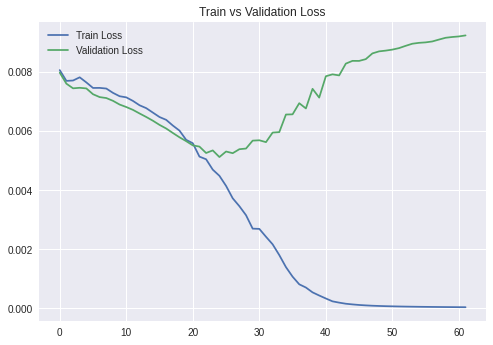

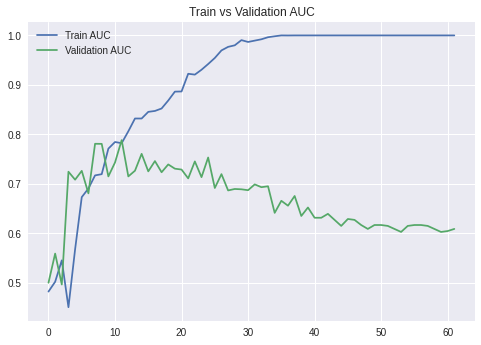

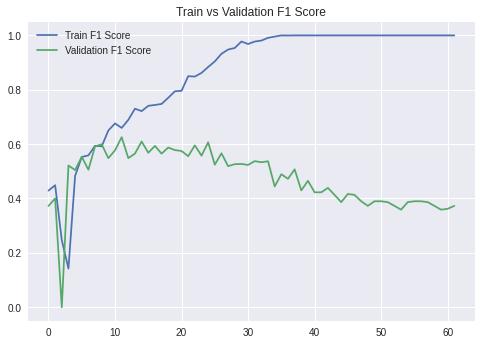


-------------------------------
Best metrics for validation set on Epoch 12:
Loss::      0.0067
AUC::       0.7883
Accuracy::  0.7793
F1::        0.6256
Precision:: 0.5116
Recall::    0.8049
Confusion Matrix:
 [[213  63]
 [ 16  66]]
-------------------------------

Metrics for train set on Epoch 12:
Loss::      0.0070
AUC::       0.7821
Accuracy::  0.7317
F1::        0.6597
Precision:: 0.5202
Recall::    0.9013
Confusion Matrix:
 [[2452 1247]
 [ 148 1352]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0080      Validation 0.0079
AUC::       Train 0.4798      Validation 0.5000
Accuracy::  Train 0.3031      Validation 0.2291
F1::        Train 0.4263      Validation 0.3727
Precision:: Train 0.2795      Validation 0.2291
Recall::    Train 0.8973      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[ 230 3469]
 [ 154 1346]]

Epoch 1 took 15.58 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0078      Validation 0.0077
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.2885      Validation 0.2291
F1::        Train 0.4478      Validation 0.3727
Precision:: Train 0.2885      Validation 0.2291
Recall::    Train 1.0000      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[   0 3699]
 [   0 1500]]

Epoch 2 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0075
AUC::       Train 0.6090      Validation 0.5386
Accuracy::  Train 0.6244      Validation 0.7709
F1::        Train 0.4680      Validation 0.1800
Precision:: Train 0.3957      Validation 0.5000
Recall::    Train 0.5727      Validation 0.1098
Validation Confusion Matrix:
 [[267   9]
 [ 73   9]]

Train Confusion Matrix:
 [[2387 1312]
 [ 641  859]]

Epoch 3 took 15.54 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5386

---------------------------------------------------------------------
Running Epoch 4 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0074
AUC::       Train 0.5026      Validation 0.6678
Accuracy::  Train 0.6892      Validation 0.7654
F1::        Train 0.1022      Validation 0.4878
Precision:: Train 0.3067      Validation 0.4878
Recall::    Train 0.0613      Validation 0.4878
Validation Confusion Matrix:
 [[234  42]
 [ 42  40]]

Train Confusion Matrix:
 [[3491  208]
 [1408   92]]

Epoch 4 took 15.49 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.6678

---------------------------------------------------------------------
Running Epoch 5 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0073
AUC::       Train 0.6429      Validation 0.7736
Accuracy::  Train 0.6061      Validation 0.6508
F1::        Train 0.5168      Validation 0.5675
Precision:: Train 0.3999      Validation 0.3961
Recall::    Train 0.7300      Validation 1.0000
Validation Confusion Matrix:
 [[151 125]
 [  0  82]]

Train Confusion Matrix:
 [[2056 1643]
 [ 405 1095]]

Epoch 5 took 15.49 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7736

---------------------------------------------------------------------
Running Epoch 6 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0075      Validation 0.0072
AUC::       Train 0.6342      Validation 0.8012
Accuracy::  Train 0.4826      Validation 0.7067
F1::        Train 0.5254      Validation 0.6038
Precision:: Train 0.3572      Validation 0.4372
Recall::    Train 0.9927      Validation 0.9756
Validation Confusion Matrix:
 [[173 103]
 [  2  80]]

Train Confusion Matrix:
 [[1020 2679]
 [  11 1489]]

Epoch 6 took 15.48 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8012

---------------------------------------------------------------------
Running Epoch 7 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0074      Validation 0.0071
AUC::       Train 0.7072      Validation 0.7899
Accuracy::  Train 0.6149      Validation 0.8017
F1::        Train 0.5810      Validation 0.6396
Precision:: Train 0.4234      Validation 0.5478
Recall::    Train 0.9253      Validation 0.7683
Validation Confusion Matrix:
 [[224  52]
 [ 19  63]]

Train Confusion Matrix:
 [[1809 1890]
 [ 112 1388]]

Epoch 7 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0074      Validation 0.0070
AUC::       Train 0.7359      Validation 0.7703
Accuracy::  Train 0.7505      Validation 0.8045
F1::        Train 0.6186      Validation 0.6237
Precision:: Train 0.5534      Validation 0.5577
Recall::    Train 0.7013      Validation 0.7073
Validation Confusion Matrix:
 [[230  46]
 [ 24  58]]

Train Confusion Matrix:
 [[2850  849]
 [ 448 1052]]

Epoch 8 took 15.54 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 9 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0073      Validation 0.0069
AUC::       Train 0.7471      Validation 0.8257
Accuracy::  Train 0.7080      Validation 0.7709
F1::        Train 0.6239      Validation 0.6496
Precision:: Train 0.4965      Validation 0.5000
Recall::    Train 0.8393      Validation 0.9268
Validation Confusion Matrix:
 [[200  76]
 [  6  76]]

Train Confusion Matrix:
 [[2422 1277]
 [ 241 1259]]

Epoch 9 took 15.51 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8257

---------------------------------------------------------------------
Running Epoch 10 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0072      Validation 0.0068
AUC::       Train 0.7308      Validation 0.8269
Accuracy::  Train 0.6372      Validation 0.7793
F1::        Train 0.6023      Validation 0.6550
Precision:: Train 0.4405      Validation 0.5102
Recall::    Train 0.9520      Validation 0.9146
Validation Confusion Matrix:
 [[204  72]
 [  7  75]]

Train Confusion Matrix:
 [[1885 1814]
 [  72 1428]]

Epoch 10 took 15.45 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8269

---------------------------------------------------------------------
Running Epoch 11 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0071      Validation 0.0066
AUC::       Train 0.7672      Validation 0.7990
Accuracy::  Train 0.6980      Validation 0.8156
F1::        Train 0.6401      Validation 0.6562
Precision:: Train 0.4878      Validation 0.5727
Recall::    Train 0.9307      Validation 0.7683
Validation Confusion Matrix:
 [[229  47]
 [ 19  63]]

Train Confusion Matrix:
 [[2233 1466]
 [ 104 1396]]

Epoch 11 took 15.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0070      Validation 0.0065
AUC::       Train 0.7921      Validation 0.7947
Accuracy::  Train 0.7550      Validation 0.8156
F1::        Train 0.6745      Validation 0.6526
Precision:: Train 0.5468      Validation 0.5741
Recall::    Train 0.8800      Validation 0.7561
Validation Confusion Matrix:
 [[230  46]
 [ 20  62]]

Train Confusion Matrix:
 [[2605 1094]
 [ 180 1320]]

Epoch 12 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0069      Validation 0.0064
AUC::       Train 0.7877      Validation 0.8254
Accuracy::  Train 0.7321      Validation 0.8101
F1::        Train 0.6644      Validation 0.6731
Precision:: Train 0.5202      Validation 0.5556
Recall::    Train 0.9193      Validation 0.8537
Validation Confusion Matrix:
 [[220  56]
 [ 12  70]]

Train Confusion Matrix:
 [[2427 1272]
 [ 121 1379]]

Epoch 13 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0068      Validation 0.0063
AUC::       Train 0.7877      Validation 0.7979
Accuracy::  Train 0.7205      Validation 0.8073
F1::        Train 0.6615      Validation 0.6497
Precision:: Train 0.5084      Validation 0.5565
Recall::    Train 0.9467      Validation 0.7805
Validation Confusion Matrix:
 [[225  51]
 [ 18  64]]

Train Confusion Matrix:
 [[2326 1373]
 [  80 1420]]

Epoch 14 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0067      Validation 0.0062
AUC::       Train 0.8100      Validation 0.7837
Accuracy::  Train 0.7567      Validation 0.8184
F1::        Train 0.6894      Validation 0.6448
Precision:: Train 0.5457      Validation 0.5842
Recall::    Train 0.9360      Validation 0.7195
Validation Confusion Matrix:
 [[234  42]
 [ 23  59]]

Train Confusion Matrix:
 [[2530 1169]
 [  96 1404]]

Epoch 15 took 15.66 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0066      Validation 0.0060
AUC::       Train 0.8202      Validation 0.7965
Accuracy::  Train 0.7703      Validation 0.8184
F1::        Train 0.7021      Validation 0.6561
Precision:: Train 0.5610      Validation 0.5794
Recall::    Train 0.9380      Validation 0.7561
Validation Confusion Matrix:
 [[231  45]
 [ 20  62]]

Train Confusion Matrix:
 [[2598 1101]
 [  93 1407]]

Epoch 16 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 17 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0065      Validation 0.0059
AUC::       Train 0.8157      Validation 0.7947
Accuracy::  Train 0.7580      Validation 0.8156
F1::        Train 0.6942      Validation 0.6526
Precision:: Train 0.5463      Validation 0.5741
Recall::    Train 0.9520      Validation 0.7561
Validation Confusion Matrix:
 [[230  46]
 [ 20  62]]

Train Confusion Matrix:
 [[2513 1186]
 [  72 1428]]

Epoch 17 took 15.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 18 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0064      Validation 0.0058
AUC::       Train 0.8133      Validation 0.7588
Accuracy::  Train 0.7569      Validation 0.7933
F1::        Train 0.6920      Validation 0.6064
Precision:: Train 0.5453      Validation 0.5377
Recall::    Train 0.9467      Validation 0.6951
Validation Confusion Matrix:
 [[227  49]
 [ 25  57]]

Train Confusion Matrix:
 [[2515 1184]
 [  80 1420]]

Epoch 18 took 15.53 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 19 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0062      Validation 0.0057
AUC::       Train 0.8325      Validation 0.7581
Accuracy::  Train 0.7786      Validation 0.7989
F1::        Train 0.7145      Validation 0.6087
Precision:: Train 0.5689      Validation 0.5490
Recall::    Train 0.9600      Validation 0.6829
Validation Confusion Matrix:
 [[230  46]
 [ 26  56]]

Train Confusion Matrix:
 [[2608 1091]
 [  60 1440]]

Epoch 19 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderI

Loss::      Train 0.0060      Validation 0.0056
AUC::       Train 0.8482      Validation 0.7435
Accuracy::  Train 0.7961      Validation 0.7961
F1::        Train 0.7333      Validation 0.5922
Precision:: Train 0.5889      Validation 0.5464
Recall::    Train 0.9713      Validation 0.6463
Validation Confusion Matrix:
 [[232  44]
 [ 29  53]]

Train Confusion Matrix:
 [[2682 1017]
 [  43 1457]]

Epoch 20 took 15.56 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 21 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0054
AUC::       Train 0.8652      Validation 0.7489
Accuracy::  Train 0.8173      Validation 0.8045
F1::        Train 0.7555      Validation 0.6023
Precision:: Train 0.6153      Validation 0.5638
Recall::    Train 0.9787      Validation 0.6463
Validation Confusion Matrix:
 [[235  41]
 [ 29  53]]

Train Confusion Matrix:
 [[2781  918]
 [  32 1468]]

Epoch 21 took 15.85 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0057      Validation 0.0053
AUC::       Train 0.8686      Validation 0.7502
Accuracy::  Train 0.8209      Validation 0.7933
F1::        Train 0.7597      Validation 0.5978
Precision:: Train 0.6198      Validation 0.5392
Recall::    Train 0.9813      Validation 0.6707
Validation Confusion Matrix:
 [[229  47]
 [ 27  55]]

Train Confusion Matrix:
 [[2796  903]
 [  28 1472]]

Epoch 22 took 16.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 23 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Loss::      Train 0.0055      Validation 0.0052
AUC::       Train 0.8637      Validation 0.7538
Accuracy::  Train 0.8136      Validation 0.7989
F1::        Train 0.7525      Validation 0.6044
Precision:: Train 0.6099      Validation 0.5500
Recall::    Train 0.9820      Validation 0.6707
Validation Confusion Matrix:
 [[231  45]
 [ 27  55]]

Train Confusion Matrix:
 [[2757  942]
 [  27 1473]]

Epoch 23 took 16.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0053      Validation 0.0052
AUC::       Train 0.8858      Validation 0.7496
Accuracy::  Train 0.8423      Validation 0.7989
F1::        Train 0.7834      Validation 0.6000
Precision:: Train 0.6487      Validation 0.5510
Recall::    Train 0.9887      Validation 0.6585
Validation Confusion Matrix:
 [[232  44]
 [ 28  54]]

Train Confusion Matrix:
 [[2896  803]
 [  17 1483]]

Epoch 24 took 16.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0052      Validation 0.0050
AUC::       Train 0.8834      Validation 0.7581
Accuracy::  Train 0.8417      Validation 0.7989
F1::        Train 0.7816      Validation 0.6087
Precision:: Train 0.6492      Validation 0.5490
Recall::    Train 0.9820      Validation 0.6829
Validation Confusion Matrix:
 [[230  46]
 [ 26  56]]

Train Confusion Matrix:
 [[2903  796]
 [  27 1473]]

Epoch 25 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0049      Validation 0.0051
AUC::       Train 0.9012      Validation 0.7105
Accuracy::  Train 0.8619      Validation 0.7849
F1::        Train 0.8059      Validation 0.5497
Precision:: Train 0.6777      Validation 0.5281
Recall::    Train 0.9940      Validation 0.5732
Validation Confusion Matrix:
 [[234  42]
 [ 35  47]]

Train Confusion Matrix:
 [[2990  709]
 [   9 1491]]

Epoch 26 took 15.57 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0048      Validation 0.0050
AUC::       Train 0.9213      Validation 0.7416
Accuracy::  Train 0.8917      Validation 0.7933
F1::        Train 0.8408      Validation 0.5889
Precision:: Train 0.7300      Validation 0.5408
Recall::    Train 0.9913      Validation 0.6463
Validation Confusion Matrix:
 [[231  45]
 [ 29  53]]

Train Confusion Matrix:
 [[3149  550]
 [  13 1487]]

Epoch 27 took 15.54 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0045      Validation 0.0051
AUC::       Train 0.9151      Validation 0.7123
Accuracy::  Train 0.8806      Validation 0.7877
F1::        Train 0.8280      Validation 0.5529
Precision:: Train 0.7082      Validation 0.5341
Recall::    Train 0.9967      Validation 0.5732
Validation Confusion Matrix:
 [[235  41]
 [ 35  47]]

Train Confusion Matrix:
 [[3083  616]
 [   5 1495]]

Epoch 28 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0044      Validation 0.0050
AUC::       Train 0.9390      Validation 0.7550
Accuracy::  Train 0.9158      Validation 0.8073
F1::        Train 0.8719      Validation 0.6102
Precision:: Train 0.7766      Validation 0.5684
Recall::    Train 0.9940      Validation 0.6585
Validation Confusion Matrix:
 [[235  41]
 [ 28  54]]

Train Confusion Matrix:
 [[3270  429]
 [   9 1491]]

Epoch 29 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0042      Validation 0.0051
AUC::       Train 0.9328      Validation 0.7159
Accuracy::  Train 0.9061      Validation 0.7933
F1::        Train 0.8596      Validation 0.5595
Precision:: Train 0.7561      Validation 0.5465
Recall::    Train 0.9960      Validation 0.5732
Validation Confusion Matrix:
 [[237  39]
 [ 35  47]]

Train Confusion Matrix:
 [[3217  482]
 [   6 1494]]

Epoch 30 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0041      Validation 0.0050
AUC::       Train 0.9491      Validation 0.7654
Accuracy::  Train 0.9304      Validation 0.8101
F1::        Train 0.8917      Validation 0.6222
Precision:: Train 0.8089      Validation 0.5714
Recall::    Train 0.9933      Validation 0.6829
Validation Confusion Matrix:
 [[234  42]
 [ 26  56]]

Train Confusion Matrix:
 [[3347  352]
 [  10 1490]]

Epoch 31 took 15.49 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0036      Validation 0.0054
AUC::       Train 0.9623      Validation 0.6573
Accuracy::  Train 0.9475      Validation 0.7821
F1::        Train 0.9164      Validation 0.4730
Precision:: Train 0.8476      Validation 0.5303
Recall::    Train 0.9973      Validation 0.4268
Validation Confusion Matrix:
 [[245  31]
 [ 47  35]]

Train Confusion Matrix:
 [[3430  269]
 [   4 1496]]

Epoch 32 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0034      Validation 0.0051
AUC::       Train 0.9788      Validation 0.7421
Accuracy::  Train 0.9710      Validation 0.8073
F1::        Train 0.9520      Validation 0.5965
Precision:: Train 0.9105      Validation 0.5730
Recall::    Train 0.9973      Validation 0.6220
Validation Confusion Matrix:
 [[238  38]
 [ 31  51]]

Train Confusion Matrix:
 [[3552  147]
 [   4 1496]]

Epoch 33 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0031      Validation 0.0058
AUC::       Train 0.9757      Validation 0.6340
Accuracy::  Train 0.9665      Validation 0.7793
F1::        Train 0.9450      Validation 0.4317
Precision:: Train 0.8980      Validation 0.5263
Recall::    Train 0.9973      Validation 0.3659
Validation Confusion Matrix:
 [[249  27]
 [ 52  30]]

Train Confusion Matrix:
 [[3529  170]
 [   4 1496]]

Epoch 34 took 15.51 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0030      Validation 0.0051
AUC::       Train 0.9856      Validation 0.7306
Accuracy::  Train 0.9804      Validation 0.7961
F1::        Train 0.9671      Validation 0.5780
Precision:: Train 0.9380      Validation 0.5495
Recall::    Train 0.9980      Validation 0.6098
Validation Confusion Matrix:
 [[235  41]
 [ 32  50]]

Train Confusion Matrix:
 [[3600   99]
 [   3 1497]]

Epoch 35 took 15.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0027      Validation 0.0062
AUC::       Train 0.9772      Validation 0.5717
Accuracy::  Train 0.9685      Validation 0.7626
F1::        Train 0.9481      Validation 0.2975
Precision:: Train 0.9029      Validation 0.4615
Recall::    Train 0.9980      Validation 0.2195
Validation Confusion Matrix:
 [[255  21]
 [ 64  18]]

Train Confusion Matrix:
 [[3538  161]
 [   3 1497]]

Epoch 36 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0026      Validation 0.0051
AUC::       Train 0.9905      Validation 0.7416
Accuracy::  Train 0.9873      Validation 0.7933
F1::        Train 0.9784      Validation 0.5889
Precision:: Train 0.9596      Validation 0.5408
Recall::    Train 0.9980      Validation 0.6463
Validation Confusion Matrix:
 [[231  45]
 [ 29  53]]

Train Confusion Matrix:
 [[3636   63]
 [   3 1497]]

Epoch 37 took 15.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0025      Validation 0.0066
AUC::       Train 0.9796      Validation 0.5607
Accuracy::  Train 0.9710      Validation 0.7654
F1::        Train 0.9521      Validation 0.2632
Precision:: Train 0.9085      Validation 0.4688
Recall::    Train 1.0000      Validation 0.1829
Validation Confusion Matrix:
 [[259  17]
 [ 67  15]]

Train Confusion Matrix:
 [[3548  151]
 [   0 1500]]

Epoch 38 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0023      Validation 0.0050
AUC::       Train 0.9911      Validation 0.7660
Accuracy::  Train 0.9885      Validation 0.8045
F1::        Train 0.9803      Validation 0.6196
Precision:: Train 0.9639      Validation 0.5588
Recall::    Train 0.9973      Validation 0.6951
Validation Confusion Matrix:
 [[231  45]
 [ 25  57]]

Train Confusion Matrix:
 [[3643   56]
 [   4 1496]]

Epoch 39 took 15.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0020      Validation 0.0077
AUC::       Train 0.9859      Validation 0.5185
Accuracy::  Train 0.9800      Validation 0.7598
F1::        Train 0.9665      Validation 0.1224
Precision:: Train 0.9352      Validation 0.3750
Recall::    Train 1.0000      Validation 0.0732
Validation Confusion Matrix:
 [[266  10]
 [ 76   6]]

Train Confusion Matrix:
 [[3595  104]
 [   0 1500]]

Epoch 40 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0017      Validation 0.0049
AUC::       Train 0.9971      Validation 0.7814
Accuracy::  Train 0.9962      Validation 0.8017
F1::        Train 0.9934      Validation 0.6321
Precision:: Train 0.9875      Validation 0.5495
Recall::    Train 0.9993      Validation 0.7439
Validation Confusion Matrix:
 [[226  50]
 [ 21  61]]

Train Confusion Matrix:
 [[3680   19]
 [   1 1499]]

Epoch 41 took 15.42 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0016      Validation 0.0093
AUC::       Train 0.9857      Validation 0.4989
Accuracy::  Train 0.9796      Validation 0.7626
F1::        Train 0.9659      Validation 0.0230
Precision:: Train 0.9340      Validation 0.2000
Recall::    Train 1.0000      Validation 0.0122
Validation Confusion Matrix:
 [[272   4]
 [ 81   1]]

Train Confusion Matrix:
 [[3593  106]
 [   0 1500]]

Epoch 42 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0015      Validation 0.0046
AUC::       Train 0.9981      Validation 0.7888
Accuracy::  Train 0.9979      Validation 0.7933
F1::        Train 0.9963      Validation 0.6337
Precision:: Train 0.9940      Validation 0.5333
Recall::    Train 0.9987      Validation 0.7805
Validation Confusion Matrix:
 [[220  56]
 [ 18  64]]

Train Confusion Matrix:
 [[3690    9]
 [   2 1498]]

Epoch 43 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0015      Validation 0.0121
AUC::       Train 0.9699      Validation 0.5043
Accuracy::  Train 0.9571      Validation 0.7709
F1::        Train 0.9308      Validation 0.0238
Precision:: Train 0.8706      Validation 0.5000
Recall::    Train 1.0000      Validation 0.0122
Validation Confusion Matrix:
 [[275   1]
 [ 81   1]]

Train Confusion Matrix:
 [[3476  223]
 [   0 1500]]

Epoch 44 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0014      Validation 0.0044
AUC::       Train 0.9964      Validation 0.8017
Accuracy::  Train 0.9971      Validation 0.7933
F1::        Train 0.9950      Validation 0.6442
Precision:: Train 0.9953      Validation 0.5317
Recall::    Train 0.9947      Validation 0.8171
Validation Confusion Matrix:
 [[217  59]
 [ 15  67]]

Train Confusion Matrix:
 [[3692    7]
 [   8 1492]]

Epoch 45 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0017      Validation 0.0169
AUC::       Train 0.9300      Validation 0.5000
Accuracy::  Train 0.9004      Validation 0.7709
F1::        Train 0.8528      Validation 0.0000
Precision:: Train 0.7433      Validation 0.0000
Recall::    Train 1.0000      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[3181  518]
 [   0 1500]]

Epoch 46 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0021      Validation 0.0049
AUC::       Train 0.9334      Validation 0.8366
Accuracy::  Train 0.9521      Validation 0.7877
F1::        Train 0.9146      Validation 0.6667
Precision:: Train 0.9414      Validation 0.5205
Recall::    Train 0.8893      Validation 0.9268
Validation Confusion Matrix:
 [[206  70]
 [  6  76]]

Train Confusion Matrix:
 [[3616   83]
 [ 166 1334]]

Epoch 47 took 15.55 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8366

---------------------------------------------------------------------
Running Epoch 48 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0028      Validation 0.0227
AUC::       Train 0.8765      Validation 0.5000
Accuracy::  Train 0.8242      Validation 0.7709
F1::        Train 0.7665      Validation 0.0000
Precision:: Train 0.6214      Validation 0.0000
Recall::    Train 1.0000      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2785  914]
 [   0 1500]]

Epoch 48 took 15.48 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0034      Validation 0.0065
AUC::       Train 0.8240      Validation 0.8659
Accuracy::  Train 0.8640      Validation 0.7933
F1::        Train 0.7558      Validation 0.6891
Precision:: Train 0.7842      Validation 0.5256
Recall::    Train 0.7293      Validation 1.0000
Validation Confusion Matrix:
 [[202  74]
 [  0  82]]

Train Confusion Matrix:
 [[3398  301]
 [ 406 1094]]

Epoch 49 took 15.46 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8659

---------------------------------------------------------------------
Running Epoch 50 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0053      Validation 0.0228
AUC::       Train 0.7890      Validation 0.5000
Accuracy::  Train 0.7428      Validation 0.7709
F1::        Train 0.6683      Validation 0.0000
Precision:: Train 0.5322      Validation 0.0000
Recall::    Train 0.8980      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2515 1184]
 [ 153 1347]]

Epoch 50 took 15.52 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0032      Validation 0.0064
AUC::       Train 0.8610      Validation 0.8549
Accuracy::  Train 0.8842      Validation 0.7961
F1::        Train 0.8007      Validation 0.6840
Precision:: Train 0.7954      Validation 0.5302
Recall::    Train 0.8060      Validation 0.9634
Validation Confusion Matrix:
 [[206  70]
 [  3  79]]

Train Confusion Matrix:
 [[3388  311]
 [ 291 1209]]

Epoch 51 took 15.61 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 52 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0235
AUC::       Train 0.7785      Validation 0.5000
Accuracy::  Train 0.7269      Validation 0.7709
F1::        Train 0.6555      Validation 0.0000
Precision:: Train 0.5153      Validation 0.0000
Recall::    Train 0.9007      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2428 1271]
 [ 149 1351]]

Epoch 52 took 15.50 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0040      Validation 0.0065
AUC::       Train 0.8225      Validation 0.8452
Accuracy::  Train 0.8577      Validation 0.7877
F1::        Train 0.7498      Validation 0.6724
Precision:: Train 0.7606      Validation 0.5200
Recall::    Train 0.7393      Validation 0.9512
Validation Confusion Matrix:
 [[204  72]
 [  4  78]]

Train Confusion Matrix:
 [[3350  349]
 [ 391 1109]]

Epoch 53 took 15.63 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0061      Validation 0.0237
AUC::       Train 0.7755      Validation 0.5000
Accuracy::  Train 0.7221      Validation 0.7709
F1::        Train 0.6519      Validation 0.0000
Precision:: Train 0.5104      Validation 0.0000
Recall::    Train 0.9020      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2401 1298]
 [ 147 1353]]

Epoch 54 took 15.64 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0066      Validation 0.0082
AUC::       Train 0.7134      Validation 0.8605
Accuracy::  Train 0.7701      Validation 0.7849
F1::        Train 0.5926      Validation 0.6805
Precision:: Train 0.6064      Validation 0.5157
Recall::    Train 0.5793      Validation 1.0000
Validation Confusion Matrix:
 [[199  77]
 [  0  82]]

Train Confusion Matrix:
 [[3135  564]
 [ 631  869]]

Epoch 55 took 15.46 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0071      Validation 0.0263
AUC::       Train 0.7741      Validation 0.5000
Accuracy::  Train 0.6797      Validation 0.7709
F1::        Train 0.6425      Validation 0.0000
Precision:: Train 0.4739      Validation 0.0000
Recall::    Train 0.9973      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2038 1661]
 [   4 1496]]

Epoch 56 took 15.47 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0115      Validation 0.0077
AUC::       Train 0.6205      Validation 0.8569
Accuracy::  Train 0.7725      Validation 0.7793
F1::        Train 0.3986      Validation 0.6749
Precision:: Train 0.8394      Validation 0.5093
Recall::    Train 0.2613      Validation 1.0000
Validation Confusion Matrix:
 [[197  79]
 [  0  82]]

Train Confusion Matrix:
 [[3624   75]
 [1108  392]]

Epoch 57 took 15.78 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 58 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0171      Validation 0.0066
AUC::       Train 0.6337      Validation 0.8460
Accuracy::  Train 0.4787      Validation 0.7626
F1::        Train 0.5254      Validation 0.6586
Precision:: Train 0.3563      Validation 0.4910
Recall::    Train 1.0000      Validation 1.0000
Validation Confusion Matrix:
 [[191  85]
 [  0  82]]

Train Confusion Matrix:
 [[ 989 2710]
 [   0 1500]]

Epoch 58 took 15.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 59 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0090
AUC::       Train 0.7502      Validation 0.5000
Accuracy::  Train 0.7063      Validation 0.7709
F1::        Train 0.6266      Validation 0.0000
Precision:: Train 0.4948      Validation 0.0000
Recall::    Train 0.8540      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[2391 1308]
 [ 219 1281]]

Epoch 59 took 15.89 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 60 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0090      Validation 0.0074
AUC::       Train 0.5020      Validation 0.5000
Accuracy::  Train 0.7126      Validation 0.7709
F1::        Train 0.0080      Validation 0.0000
Precision:: Train 1.0000      Validation 0.0000
Recall::    Train 0.0040      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[3699    0]
 [1494    6]]

Epoch 60 took 16.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 61 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0066      Validation 0.0053
AUC::       Train 0.6317      Validation 0.7876
Accuracy::  Train 0.7630      Validation 0.7849
F1::        Train 0.4390      Validation 0.6280
Precision:: Train 0.6925      Validation 0.5200
Recall::    Train 0.3213      Validation 0.7927
Validation Confusion Matrix:
 [[216  60]
 [ 17  65]]

Train Confusion Matrix:
 [[3485  214]
 [1018  482]]

Epoch 61 took 16.62 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 62 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0063      Validation 0.0053
AUC::       Train 0.6823      Validation 0.8458
Accuracy::  Train 0.5480      Validation 0.7821
F1::        Train 0.5607      Validation 0.6695
Precision:: Train 0.3896      Validation 0.5130
Recall::    Train 1.0000      Validation 0.9634
Validation Confusion Matrix:
 [[201  75]
 [  3  79]]

Train Confusion Matrix:
 [[1349 2350]
 [   0 1500]]

Epoch 62 took 16.66 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 63 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0059      Validation 0.0049
AUC::       Train 0.6936      Validation 0.7931
Accuracy::  Train 0.5640      Validation 0.7933
F1::        Train 0.5696      Validation 0.6373
Precision:: Train 0.3982      Validation 0.5328
Recall::    Train 1.0000      Validation 0.7927
Validation Confusion Matrix:
 [[219  57]
 [ 17  65]]

Train Confusion Matrix:
 [[1432 2267]
 [   0 1500]]

Epoch 63 took 16.84 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 64 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0051      Validation 0.0058
AUC::       Train 0.8366      Validation 0.6090
Accuracy::  Train 0.7969      Validation 0.7737
F1::        Train 0.7256      Validation 0.3817
Precision:: Train 0.5945      Validation 0.5102
Recall::    Train 0.9307      Validation 0.3049
Validation Confusion Matrix:
 [[252  24]
 [ 57  25]]

Train Confusion Matrix:
 [[2747  952]
 [ 104 1396]]

Epoch 64 took 16.82 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 65 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0050      Validation 0.0061
AUC::       Train 0.7886      Validation 0.6205
Accuracy::  Train 0.8565      Validation 0.7849
F1::        Train 0.7163      Validation 0.4031
Precision:: Train 0.8336      Validation 0.5532
Recall::    Train 0.6280      Validation 0.3171
Validation Confusion Matrix:
 [[255  21]
 [ 56  26]]

Train Confusion Matrix:
 [[3511  188]
 [ 558  942]]

Epoch 65 took 16.78 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 66 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0043      Validation 0.0052
AUC::       Train 0.8854      Validation 0.7148
Accuracy::  Train 0.8907      Validation 0.7849
F1::        Train 0.8217      Validation 0.5549
Precision:: Train 0.7764      Validation 0.5275
Recall::    Train 0.8727      Validation 0.5854
Validation Confusion Matrix:
 [[233  43]
 [ 34  48]]

Train Confusion Matrix:
 [[3322  377]
 [ 191 1309]]

Epoch 66 took 16.45 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 67 of  150
Loss::      Train 0.0039      Validation 0.0054
AUC::       Train 0.8833      Validation 0.7349
Accuracy::  Train 0.8359      Validation 0.7961
F1::        Train 0.7778      Validation 0.5829
Precision:: Train 0.6383      Validation 0.5484
Recall::    Train 0.9953      Validation 0.6220
Validation Confusion Matrix:
 [[234  42]
 [ 31  51]]

Train Confusion Matrix:
 [[2853  846]
 [   7 1493]]

Epoch 67 took 15

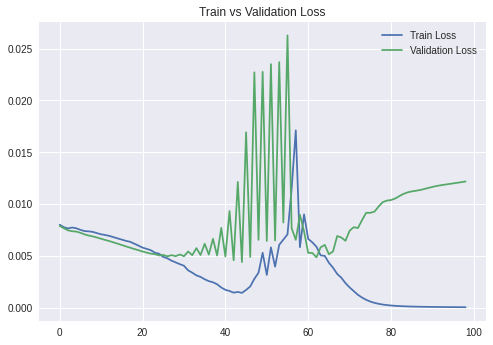

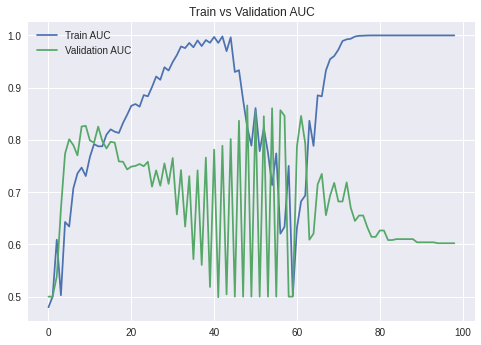

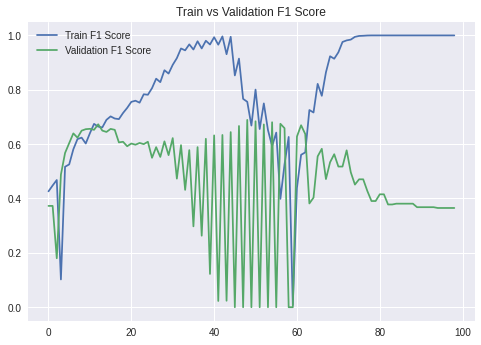


-------------------------------
Best metrics for validation set on Epoch 49:
Loss::      0.0065
AUC::       0.8659
Accuracy::  0.7933
F1::        0.6891
Precision:: 0.5256
Recall::    1.0000
Confusion Matrix:
 [[202  74]
 [  0  82]]
-------------------------------

Metrics for train set on Epoch 49:
Loss::      0.0034
AUC::       0.8240
Accuracy::  0.8640
F1::        0.7558
Precision:: 0.7842
Recall::    0.7293
Confusion Matrix:
 [[3398  301]
 [ 406 1094]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

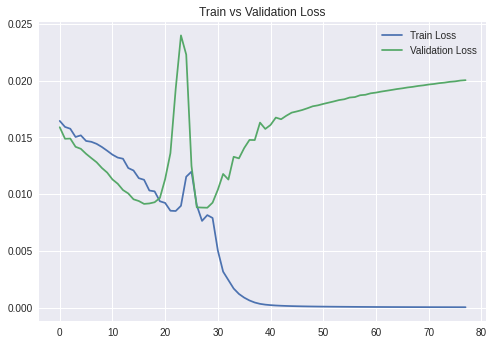

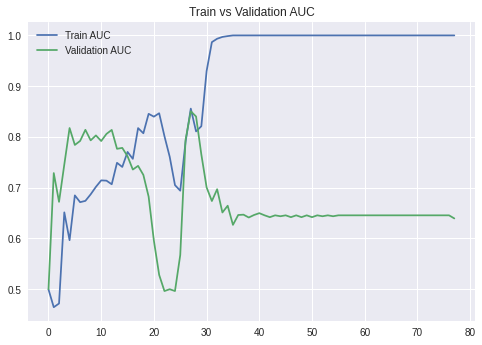

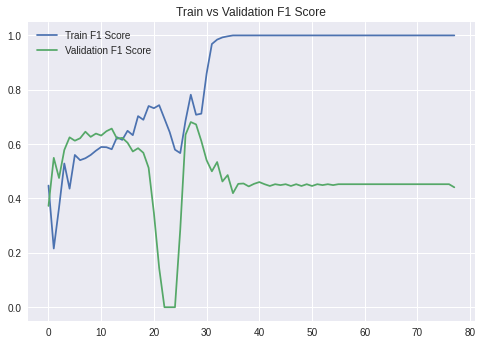


-------------------------------
Best metrics for validation set on Epoch 28:
Loss::      0.0088
AUC::       0.8506
Accuracy::  0.7961
F1::        0.6812
Precision:: 0.5306
Recall::    0.9512
Confusion Matrix:
 [[207  69]
 [  4  78]]
-------------------------------

Metrics for train set on Epoch 28:
Loss::      0.0076
AUC::       0.8558
Accuracy::  0.8661
F1::        0.7818
Precision:: 0.7379
Recall::    0.8313
Confusion Matrix:
 [[3256  443]
 [ 253 1247]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

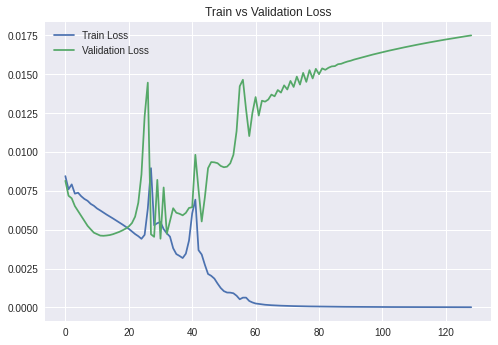

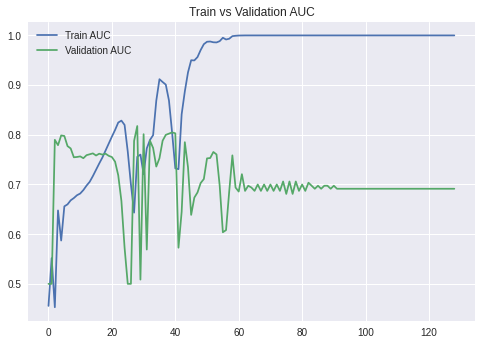

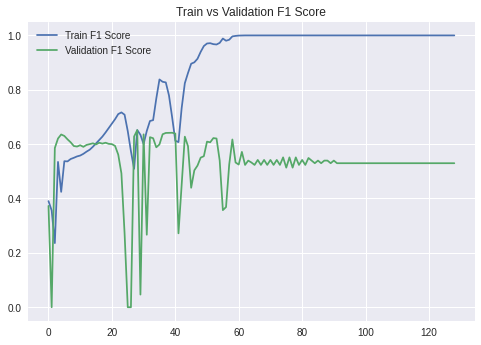


-------------------------------
Best metrics for validation set on Epoch 29:
Loss::      0.0045
AUC::       0.8176
Accuracy::  0.7849
F1::        0.6516
Precision:: 0.5180
Recall::    0.8780
Confusion Matrix:
 [[209  67]
 [ 10  72]]
-------------------------------

Metrics for train set on Epoch 29:
Loss::      0.0053
AUC::       0.7558
Accuracy::  0.7971
F1::        0.6517
Precision:: 0.6456
Recall::    0.6580
Confusion Matrix:
 [[5262  903]
 [ 855 1645]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg13_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

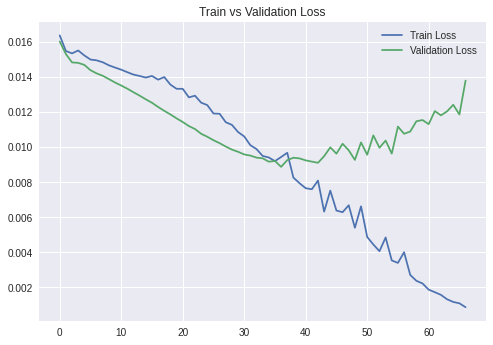

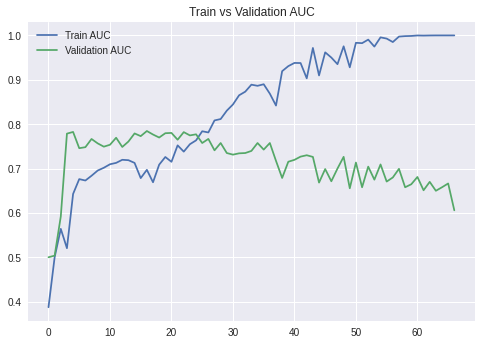

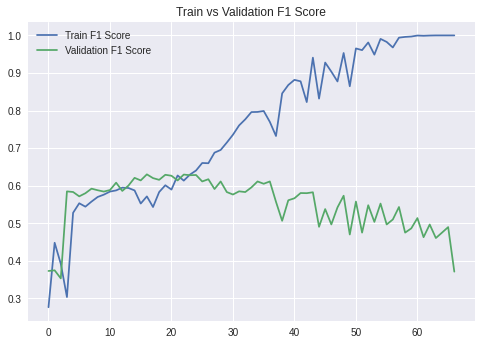


-------------------------------
Best metrics for validation set on Epoch 17:
Loss::      0.0123
AUC::       0.7845
Accuracy::  0.7933
F1::        0.6300
Precision:: 0.5339
Recall::    0.7683
Confusion Matrix:
 [[221  55]
 [ 19  63]]
-------------------------------

Metrics for train set on Epoch 17:
Loss::      0.0138
AUC::       0.6970
Accuracy::  0.6495
F1::        0.5713
Precision:: 0.4415
Recall::    0.8093
Confusion Matrix:
 [[2163 1536]
 [ 286 1214]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

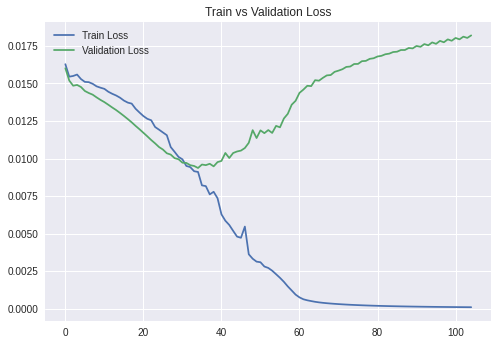

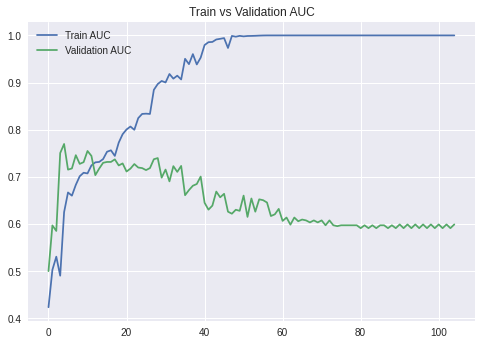

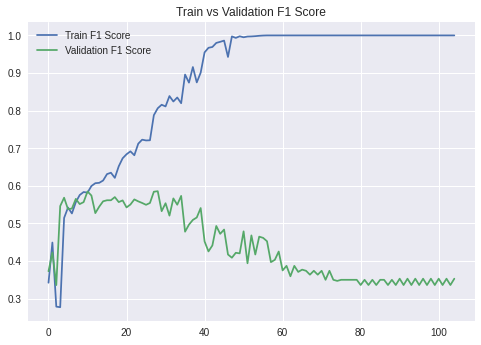


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      0.0148
AUC::       0.7698
Accuracy::  0.6648
F1::        0.5683
Precision:: 0.4031
Recall::    0.9634
Confusion Matrix:
 [[159 117]
 [  3  79]]
-------------------------------

Metrics for train set on Epoch 5:
Loss::      0.0153
AUC::       0.6251
Accuracy::  0.5055
F1::        0.5144
Precision:: 0.3589
Recall::    0.9080
Confusion Matrix:
 [[1266 2433]
 [ 138 1362]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

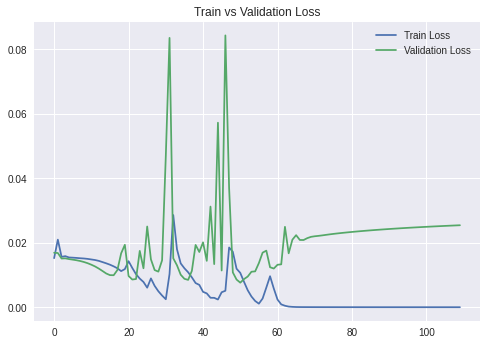

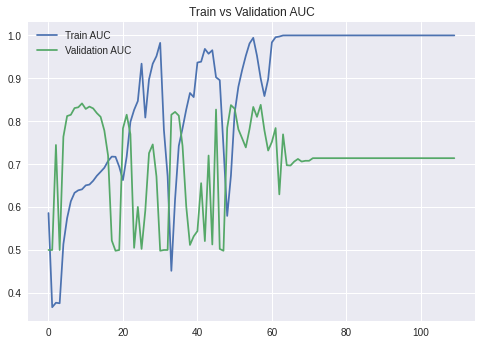


-------------------------------
Best metrics for validation set on Epoch 10:
Loss::      0.0136
AUC::       0.8416
Accuracy::  0.7821
F1::        0.6667
Precision:: 0.5132
Recall::    0.9512
Confusion Matrix:
 [[202  74]
 [  4  78]]
-------------------------------

Metrics for train set on Epoch 10:
Loss::      0.0150
AUC::       0.6413
Accuracy::  0.5860
F1::        0.5183
Precision:: 0.3901
Recall::    0.7720
Confusion Matrix:
 [[3148 3017]
 [ 570 1930]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

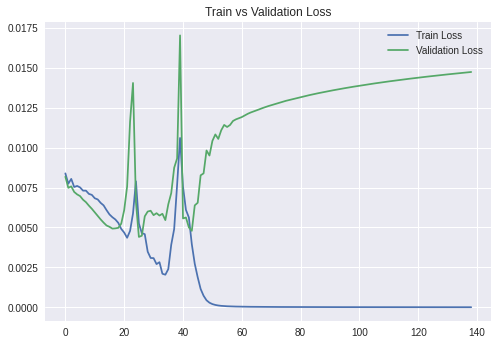

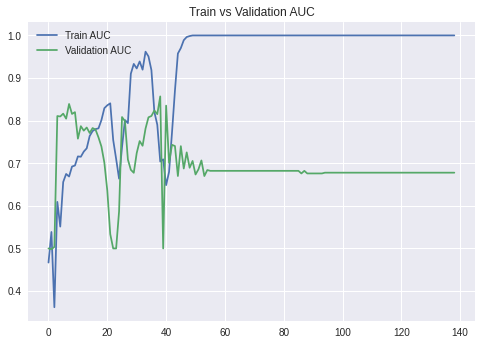

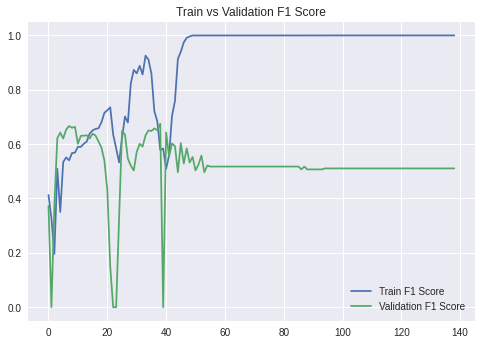


-------------------------------
Best metrics for validation set on Epoch 39:
Loss::      0.0093
AUC::       0.8569
Accuracy::  0.7793
F1::        0.6749
Precision:: 0.5093
Recall::    1.0000
Confusion Matrix:
 [[197  79]
 [  0  82]]
-------------------------------

Metrics for train set on Epoch 39:
Loss::      0.0077
AUC::       0.7041
Accuracy::  0.7102
F1::        0.5786
Precision:: 0.4984
Recall::    0.6896
Confusion Matrix:
 [[4430 1735]
 [ 776 1724]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

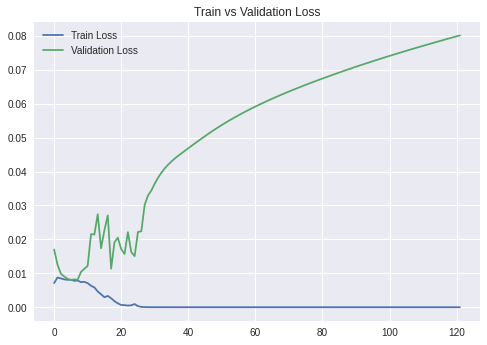

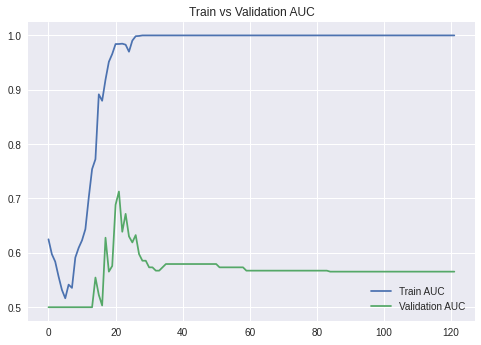

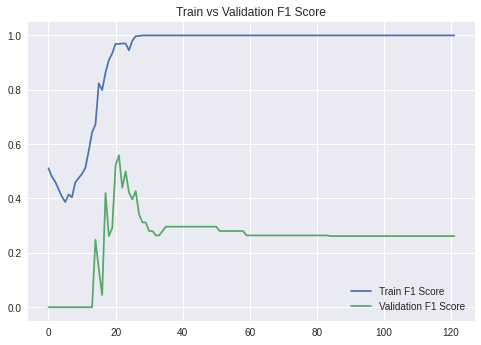


-------------------------------
Best metrics for validation set on Epoch 22:
Loss::      0.0157
AUC::       0.7128
Accuracy::  0.8017
F1::        0.5590
Precision:: 0.5696
Recall::    0.5488
Confusion Matrix:
 [[242  34]
 [ 37  45]]
-------------------------------

Metrics for train set on Epoch 22:
Loss::      0.0006
AUC::       0.9842
Accuracy::  0.9814
F1::        0.9685
Precision:: 0.9472
Recall::    0.9908
Confusion Matrix:
 [[6027  138]
 [  23 2477]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':128,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

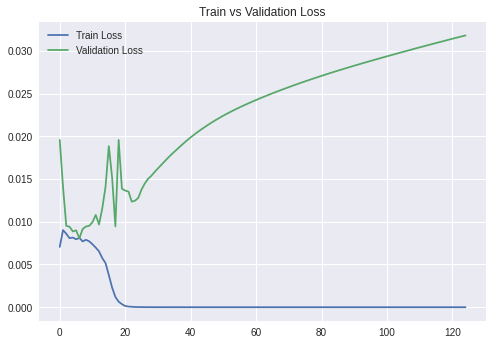

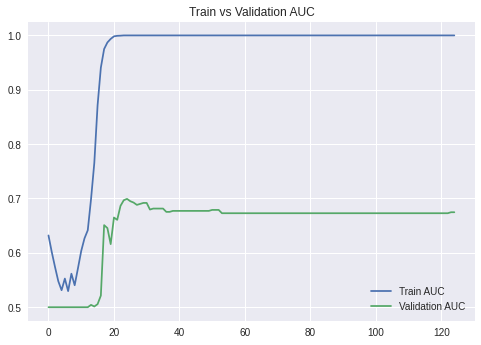

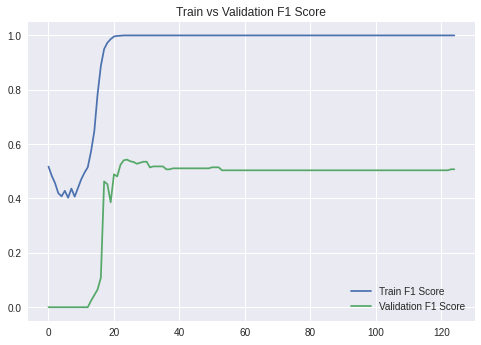


-------------------------------
Best metrics for validation set on Epoch 25:
Loss::      0.0128
AUC::       0.6993
Accuracy::  0.8073
F1::        0.5430
Precision:: 0.5942
Recall::    0.5000
Confusion Matrix:
 [[248  28]
 [ 41  41]]
-------------------------------

Metrics for train set on Epoch 25:
Loss::      0.0000
AUC::       1.0000
Accuracy::  1.0000
F1::        1.0000
Precision:: 1.0000
Recall::    1.0000
Confusion Matrix:
 [[7398    0]
 [   0 3000]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':5,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

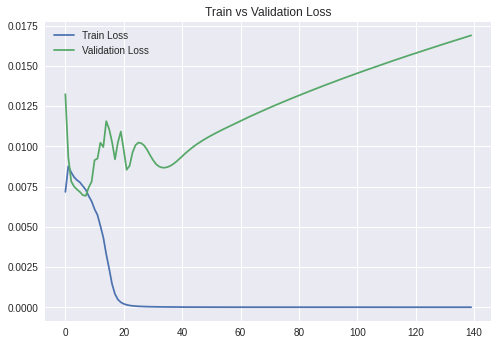

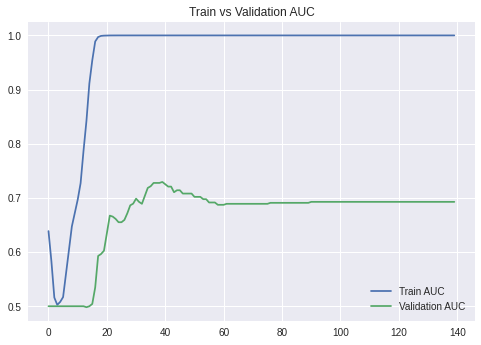

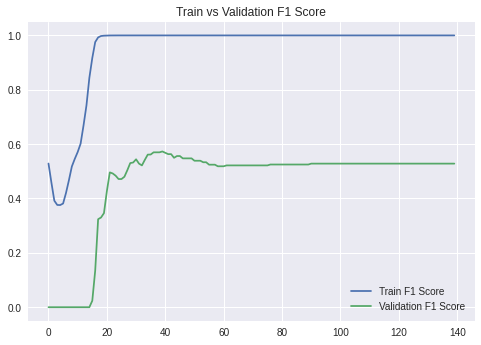


-------------------------------
Best metrics for validation set on Epoch 40:
Loss::      0.0092
AUC::       0.7295
Accuracy::  0.7877
F1::        0.5730
Precision:: 0.5312
Recall::    0.6220
Confusion Matrix:
 [[231  45]
 [ 31  51]]
-------------------------------

Metrics for train set on Epoch 40:
Loss::      0.0000
AUC::       1.0000
Accuracy::  1.0000
F1::        1.0000
Precision:: 1.0000
Recall::    1.0000
Confusion Matrix:
 [[6165    0]
 [   0 2500]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':128,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

Rodando a partir daqui


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

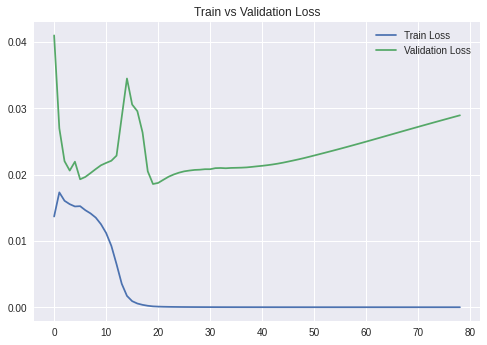

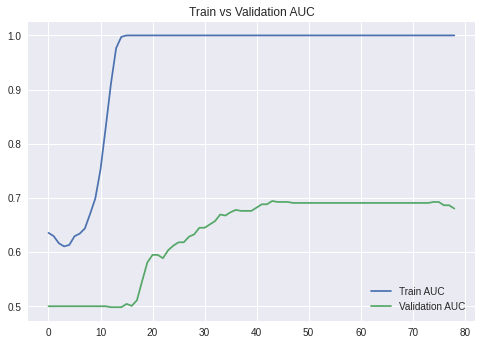

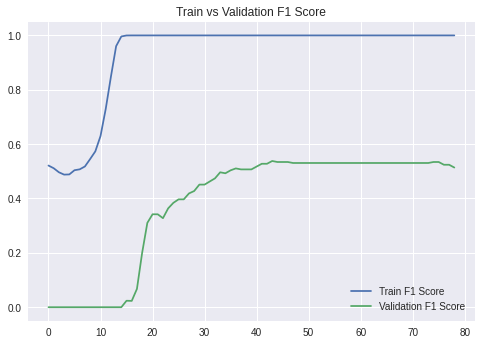


-------------------------------
Best metrics for validation set on Epoch 44:
Loss::      0.0216
AUC::       0.6943
Accuracy::  0.8128
F1::        0.5379
Precision:: 0.6190
Recall::    0.4756
Confusion Matrix:
 [[252  24]
 [ 43  39]]
-------------------------------

Metrics for train set on Epoch 44:
Loss::      0.0000
AUC::       1.0000
Accuracy::  1.0000
F1::        1.0000
Precision:: 1.0000
Recall::    1.0000
Confusion Matrix:
 [[6165    0]
 [   0 2500]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':64,
              'optimizer':'adam',
              'max_epochs':150,
              'early_stop':35,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

LR=0.000002 e BATCH_SIZE=32 também overfitam mt rapido com o adam

LR=0.000001 e BATCH_SIZE=16 também overfitam mt rapido com o adam



--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

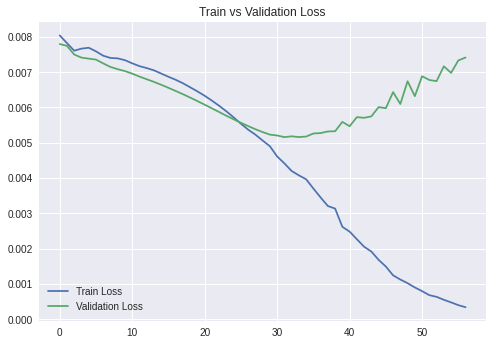

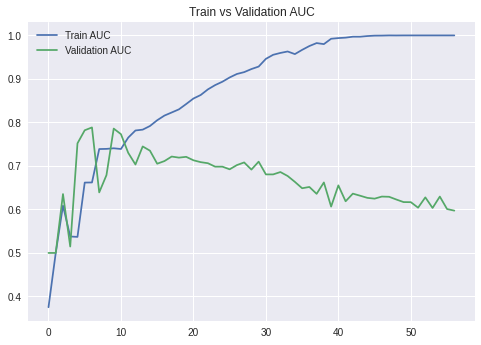

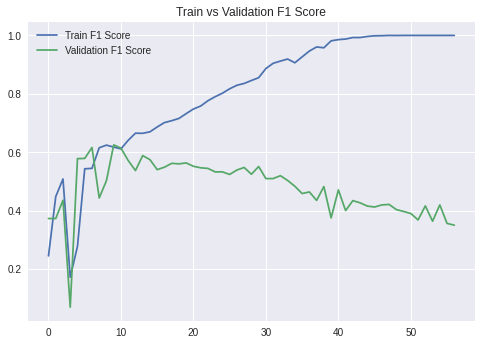


-------------------------------
Best metrics for validation set on Epoch 7:
Loss::      0.0072
AUC::       0.7885
Accuracy::  0.7598
F1::        0.6161
Precision:: 0.4859
Recall::    0.8415
Confusion Matrix:
 [[203  73]
 [ 13  69]]
-------------------------------

Metrics for train set on Epoch 7:
Loss::      0.0075
AUC::       0.6620
Accuracy::  0.5303
F1::        0.5446
Precision:: 0.3780
Recall::    0.9733
Confusion Matrix:
 [[1297 2402]
 [  40 1460]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.1,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

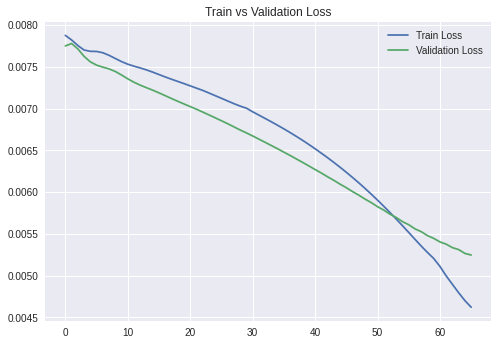

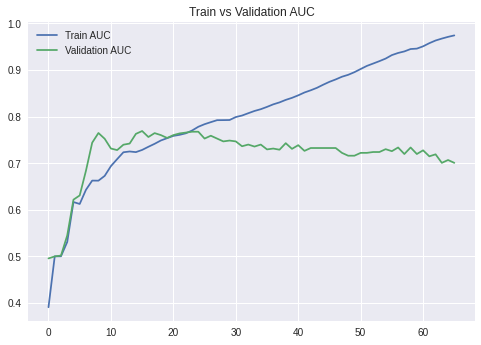


-------------------------------
Best metrics for validation set on Epoch 16:
Loss::      0.0072
AUC::       0.7689
Accuracy::  0.7626
F1::        0.6009
Precision:: 0.4885
Recall::    0.7805
Confusion Matrix:
 [[209  67]
 [ 18  64]]
-------------------------------

Metrics for train set on Epoch 16:
Loss::      0.0074
AUC::       0.7283
Accuracy::  0.6684
F1::        0.6022
Precision:: 0.4605
Recall::    0.8700
Confusion Matrix:
 [[2170 1529]
 [ 195 1305]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.1,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

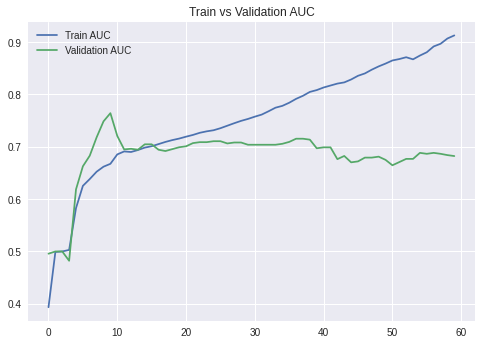

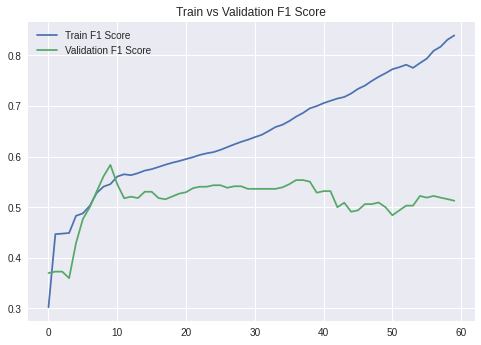


-------------------------------
Best metrics for validation set on Epoch 10:
Loss::      0.0074
AUC::       0.7643
Accuracy::  0.7291
F1::        0.5837
Precision:: 0.4503
Recall::    0.8293
Confusion Matrix:
 [[193  83]
 [ 14  68]]
-------------------------------

Metrics for train set on Epoch 10:
Loss::      0.0076
AUC::       0.6675
Accuracy::  0.5807
F1::        0.5456
Precision:: 0.3969
Recall::    0.8727
Confusion Matrix:
 [[1710 1989]
 [ 191 1309]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.01,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

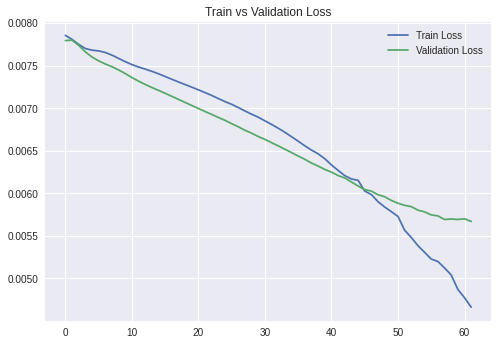

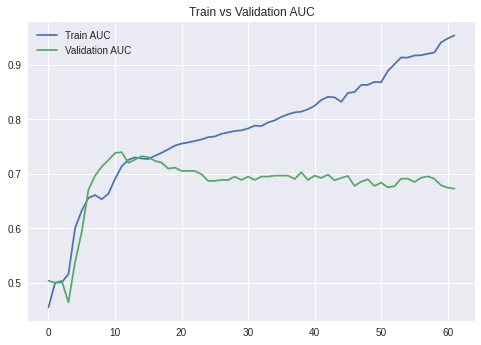

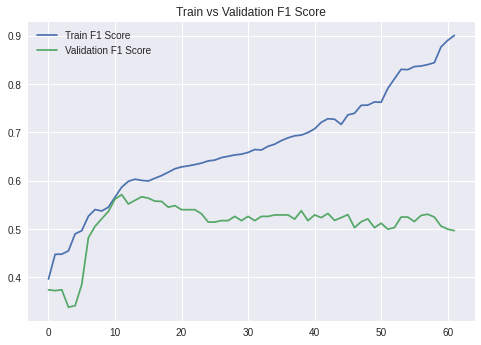


-------------------------------
Best metrics for validation set on Epoch 12:
Loss::      0.0073
AUC::       0.7395
Accuracy::  0.7570
F1::        0.5714
Precision:: 0.4793
Recall::    0.7073
Confusion Matrix:
 [[213  63]
 [ 24  58]]
-------------------------------

Metrics for train set on Epoch 12:
Loss::      0.0075
AUC::       0.7134
Accuracy::  0.6280
F1::        0.5868
Precision:: 0.4318
Recall::    0.9153
Confusion Matrix:
 [[1892 1807]
 [ 127 1373]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000002,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.01,
              'dampening':0.01,
              'nesterov':False},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

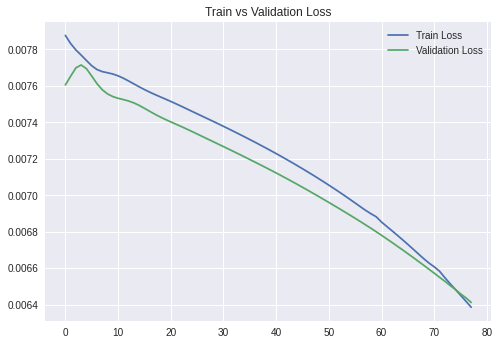

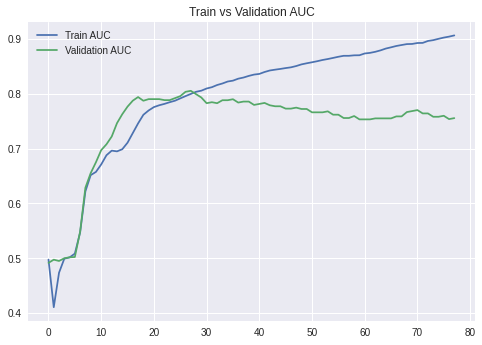

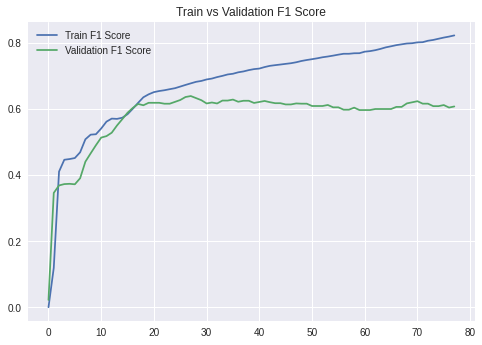


-------------------------------
Best metrics for validation set on Epoch 28:
Loss::      0.0073
AUC::       0.8055
Accuracy::  0.7793
F1::        0.6393
Precision:: 0.5109
Recall::    0.8537
Confusion Matrix:
 [[209  67]
 [ 12  70]]
-------------------------------

Metrics for train set on Epoch 28:
Loss::      0.0074
AUC::       0.7998
Accuracy::  0.7450
F1::        0.6777
Precision:: 0.5333
Recall::    0.9293
Confusion Matrix:
 [[2479 1220]
 [ 106 1394]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.01,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

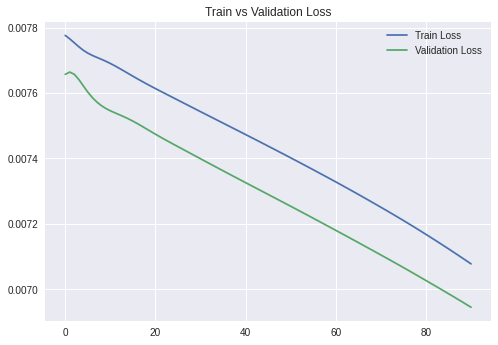

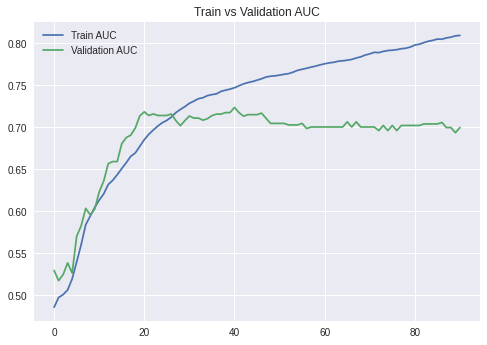

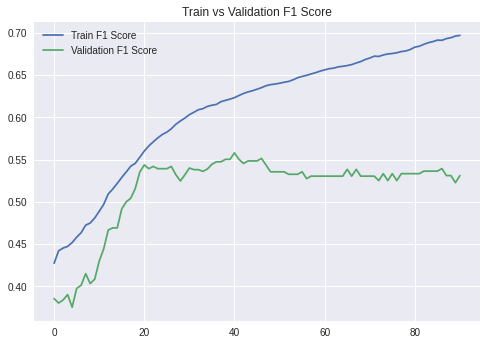


-------------------------------
Best metrics for validation set on Epoch 41:
Loss::      0.0073
AUC::       0.7235
Accuracy::  0.7654
F1::        0.5579
Precision:: 0.4907
Recall::    0.6463
Confusion Matrix:
 [[221  55]
 [ 29  53]]
-------------------------------

Metrics for train set on Epoch 41:
Loss::      0.0075
AUC::       0.7470
Accuracy::  0.7040
F1::        0.6233
Precision:: 0.4925
Recall::    0.8487
Confusion Matrix:
 [[2387 1312]
 [ 227 1273]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.0000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99,
              'weight_decay':0.01,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

Foi até aqui


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0076      Validation 0.0086
AUC::       Train 0.5897      Validation 0.5000
Accuracy::  Train 0.4164      Validation 0.7709
F1::        Train 0.4970      Validation 0.0000
Precision:: Train 0.3308      Validation 0.0000
Recall::    Train 0.9993      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[1998 9099]
 [   3 4497]]

Epoch 1 took 263.74 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3

Loss::      Train 0.0102      Validation 0.0081
AUC::       Train 0.3569      Validation 0.5000
Accuracy::  Train 0.3708      Validation 0.2291
F1::        Train 0.2291      Validation 0.3727
Precision:: Train 0.1772      Validation 0.2291
Recall::    Train 0.3240      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[4326 6771]
 [3042 1458]]

Epoch 2 took 41.55 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Loss::      Train 0.0079      Validation 0.0076
AUC::       Train 0.3574      Validation 0.5109
Accuracy::  Train 0.3622      Validation 0.2458
F1::        Train 0.2384      Validation 0.3779
Precision:: Train 0.1819      Validation 0.2330
Recall::    Train 0.3460      Validation 1.0000
Validation Confusion Matrix:
 [[  6 270]
 [  0  82]]

Train Confusion Matrix:
 [[4093 7004]
 [2943 1557]]

Epoch 3 took 42.03 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5109

---------------------------------------------------------------------
Running Epoch 4 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0079      Validation 0.0076
AUC::       Train 0.4073      Validation 0.5000
Accuracy::  Train 0.3592      Validation 0.2291
F1::        Train 0.3194      Validation 0.3727
Precision:: Train 0.2302      Validation 0.2291
Recall::    Train 0.5211      Validation 1.0000
Validation Confusion Matrix:
 [[  0 276]
 [  0  82]]

Train Confusion Matrix:
 [[3257 7840]
 [2155 2345]]

Epoch 4 took 42.17 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0074
AUC::       Train 0.5138      Validation 0.7754
Accuracy::  Train 0.3547      Validation 0.6536
F1::        Train 0.4431      Validation 0.5694
Precision:: Train 0.2950      Validation 0.3981
Recall::    Train 0.8898      Validation 1.0000
Validation Confusion Matrix:
 [[152 124]
 [  0  82]]

Train Confusion Matrix:
 [[1529 9568]
 [ 496 4004]]

Epoch 5 took 41.81 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7754

---------------------------------------------------------------------
Running Epoch 6 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0077      Validation 0.0074
AUC::       Train 0.5635      Validation 0.7935
Accuracy::  Train 0.4784      Validation 0.6816
F1::        Train 0.4583      Validation 0.5899
Precision:: Train 0.3272      Validation 0.4184
Recall::    Train 0.7649      Validation 1.0000
Validation Confusion Matrix:
 [[162 114]
 [  0  82]]

Train Confusion Matrix:
 [[4019 7078]
 [1058 3442]]

Epoch 6 took 41.19 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.7935

---------------------------------------------------------------------
Running Epoch 7 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0076      Validation 0.0072
AUC::       Train 0.5983      Validation 0.8109
Accuracy::  Train 0.4896      Validation 0.7151
F1::        Train 0.4916      Validation 0.6136
Precision:: Train 0.3449      Validation 0.4451
Recall::    Train 0.8551      Validation 0.9878
Validation Confusion Matrix:
 [[175 101]
 [  1  81]]

Train Confusion Matrix:
 [[3789 7308]
 [ 652 3848]]

Epoch 7 took 41.18 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8109

---------------------------------------------------------------------
Running Epoch 8 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0076      Validation 0.0071
AUC::       Train 0.6097      Validation 0.8259
Accuracy::  Train 0.5180      Validation 0.7514
F1::        Train 0.4973      Validation 0.6397
Precision:: Train 0.3557      Validation 0.4788
Recall::    Train 0.8262      Validation 0.9634
Validation Confusion Matrix:
 [[190  86]
 [  3  79]]

Train Confusion Matrix:
 [[4362 6735]
 [ 782 3718]]

Epoch 8 took 41.12 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8259

---------------------------------------------------------------------
Running Epoch 9 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0075      Validation 0.0069
AUC::       Train 0.6148      Validation 0.8094
Accuracy::  Train 0.5343      Validation 0.7458
F1::        Train 0.4993      Validation 0.6255
Precision:: Train 0.3619      Validation 0.4720
Recall::    Train 0.8049      Validation 0.9268
Validation Confusion Matrix:
 [[191  85]
 [  6  76]]

Train Confusion Matrix:
 [[4712 6385]
 [ 878 3622]]

Epoch 9 took 41.15 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 10 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0075      Validation 0.0067
AUC::       Train 0.6111      Validation 0.7952
Accuracy::  Train 0.5407      Validation 0.7570
F1::        Train 0.4941      Validation 0.6201
Precision:: Train 0.3621      Validation 0.4830
Recall::    Train 0.7773      Validation 0.8659
Validation Confusion Matrix:
 [[200  76]
 [ 11  71]]

Train Confusion Matrix:
 [[4936 6161]
 [1002 3498]]

Epoch 10 took 41.20 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 11 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0074      Validation 0.0065
AUC::       Train 0.6231      Validation 0.8023
Accuracy::  Train 0.5555      Validation 0.7877
F1::        Train 0.5041      Validation 0.6415
Precision:: Train 0.3717      Validation 0.5231
Recall::    Train 0.7831      Validation 0.8293
Validation Confusion Matrix:
 [[214  62]
 [ 14  68]]

Train Confusion Matrix:
 [[5140 5957]
 [ 976 3524]]

Epoch 11 took 41.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0073      Validation 0.0061
AUC::       Train 0.6287      Validation 0.7895
Accuracy::  Train 0.5656      Validation 0.7877
F1::        Train 0.5082      Validation 0.6311
Precision:: Train 0.3773      Validation 0.5242
Recall::    Train 0.7780      Validation 0.7927
Validation Confusion Matrix:
 [[217  59]
 [ 17  65]]

Train Confusion Matrix:
 [[5320 5777]
 [ 999 3501]]

Epoch 12 took 41.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0071      Validation 0.0058
AUC::       Train 0.6409      Validation 0.7992
Accuracy::  Train 0.5844      Validation 0.7961
F1::        Train 0.5181      Validation 0.6439
Precision:: Train 0.3893      Validation 0.5366
Recall::    Train 0.7744      Validation 0.8049
Validation Confusion Matrix:
 [[219  57]
 [ 16  66]]

Train Confusion Matrix:
 [[5630 5467]
 [1015 3485]]

Epoch 13 took 41.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0069      Validation 0.0054
AUC::       Train 0.6549      Validation 0.7888
Accuracy::  Train 0.5991      Validation 0.7933
F1::        Train 0.5311      Validation 0.6337
Precision:: Train 0.4008      Validation 0.5333
Recall::    Train 0.7869      Validation 0.7805
Validation Confusion Matrix:
 [[220  56]
 [ 18  64]]

Train Confusion Matrix:
 [[5803 5294]
 [ 959 3541]]

Epoch 14 took 41.19 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0067      Validation 0.0051
AUC::       Train 0.6670      Validation 0.7759
Accuracy::  Train 0.6140      Validation 0.7933
F1::        Train 0.5422      Validation 0.6224
Precision:: Train 0.4121      Validation 0.5351
Recall::    Train 0.7924      Validation 0.7439
Validation Confusion Matrix:
 [[223  53]
 [ 21  61]]

Train Confusion Matrix:
 [[6010 5087]
 [ 934 3566]]

Epoch 15 took 41.17 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0065      Validation 0.0050
AUC::       Train 0.6791      Validation 0.7394
Accuracy::  Train 0.6269      Validation 0.7765
F1::        Train 0.5538      Validation 0.5789
Precision:: Train 0.4228      Validation 0.5093
Recall::    Train 0.8024      Validation 0.6707
Validation Confusion Matrix:
 [[223  53]
 [ 27  55]]

Train Confusion Matrix:
 [[6167 4930]
 [ 889 3611]]

Epoch 16 took 41.19 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 17 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0062      Validation 0.0052
AUC::       Train 0.6935      Validation 0.6950
Accuracy::  Train 0.6392      Validation 0.8073
F1::        Train 0.5679      Validation 0.5369
Precision:: Train 0.4338      Validation 0.5970
Recall::    Train 0.8220      Validation 0.4878
Validation Confusion Matrix:
 [[249  27]
 [ 42  40]]

Train Confusion Matrix:
 [[6270 4827]
 [ 801 3699]]

Epoch 17 took 41.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 18 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0060      Validation 0.0065
AUC::       Train 0.7011      Validation 0.5110
Accuracy::  Train 0.6477      Validation 0.7682
F1::        Train 0.5754      Validation 0.0674
Precision:: Train 0.4411      Validation 0.4286
Recall::    Train 0.8273      Validation 0.0366
Validation Confusion Matrix:
 [[272   4]
 [ 79   3]]

Train Confusion Matrix:
 [[6379 4718]
 [ 777 3723]]

Epoch 18 took 41.12 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 19 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0061      Validation 0.0075
AUC::       Train 0.6808      Validation 0.4964
Accuracy::  Train 0.6322      Validation 0.7654
F1::        Train 0.5552      Validation 0.0000
Precision:: Train 0.4264      Validation 0.0000
Recall::    Train 0.7956      Validation 0.0000
Validation Confusion Matrix:
 [[274   2]
 [ 82   0]]

Train Confusion Matrix:
 [[6281 4816]
 [ 920 3580]]

Epoch 19 took 41.20 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0069      Validation 0.0050
AUC::       Train 0.6591      Validation 0.7992
Accuracy::  Train 0.6263      Validation 0.7961
F1::        Train 0.5321      Validation 0.6439
Precision:: Train 0.4165      Validation 0.5366
Recall::    Train 0.7364      Validation 0.8049
Validation Confusion Matrix:
 [[219  57]
 [ 16  66]]

Train Confusion Matrix:
 [[6455 4642]
 [1186 3314]]

Epoch 20 took 41.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 21 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0064      Validation 0.0042
AUC::       Train 0.6653      Validation 0.8005
Accuracy::  Train 0.6882      Validation 0.7849
F1::        Train 0.5307      Validation 0.6385
Precision:: Train 0.4690      Validation 0.5191
Recall::    Train 0.6111      Validation 0.8293
Validation Confusion Matrix:
 [[213  63]
 [ 14  68]]

Train Confusion Matrix:
 [[7984 3113]
 [1750 2750]]

Epoch 21 took 41.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0046
AUC::       Train 0.7197      Validation 0.7525
Accuracy::  Train 0.6510      Validation 0.8101
F1::        Train 0.5933      Validation 0.6092
Precision:: Train 0.4469      Validation 0.5761
Recall::    Train 0.8822      Validation 0.6463
Validation Confusion Matrix:
 [[237  39]
 [ 29  53]]

Train Confusion Matrix:
 [[6184 4913]
 [ 530 3970]]

Epoch 22 took 41.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 23 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0055      Validation 0.0077
AUC::       Train 0.7335      Validation 0.5117
Accuracy::  Train 0.6713      Validation 0.7626
F1::        Train 0.6072      Validation 0.0860
Precision:: Train 0.4633      Validation 0.3636
Recall::    Train 0.8807      Validation 0.0488
Validation Confusion Matrix:
 [[269   7]
 [ 78   4]]

Train Confusion Matrix:
 [[6507 4590]
 [ 537 3963]]

Epoch 23 took 41.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0056      Validation 0.0090
AUC::       Train 0.7232      Validation 0.5007
Accuracy::  Train 0.6894      Validation 0.7654
F1::        Train 0.5987      Validation 0.0233
Precision:: Train 0.4772      Validation 0.2500
Recall::    Train 0.8031      Validation 0.0122
Validation Confusion Matrix:
 [[273   3]
 [ 81   1]]

Train Confusion Matrix:
 [[7138 3959]
 [ 886 3614]]

Epoch 24 took 41.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0058      Validation 0.0099
AUC::       Train 0.7177      Validation 0.4982
Accuracy::  Train 0.6825      Validation 0.7682
F1::        Train 0.5928      Validation 0.0000
Precision:: Train 0.4705      Validation 0.0000
Recall::    Train 0.8009      Validation 0.0000
Validation Confusion Matrix:
 [[275   1]
 [ 82   0]]

Train Confusion Matrix:
 [[7041 4056]
 [ 896 3604]]

Epoch 25 took 41.26 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0068      Validation 0.0058
AUC::       Train 0.6786      Validation 0.5368
Accuracy::  Train 0.6289      Validation 0.7682
F1::        Train 0.5531      Validation 0.1782
Precision:: Train 0.4238      Validation 0.4737
Recall::    Train 0.7960      Validation 0.1098
Validation Confusion Matrix:
 [[266  10]
 [ 73   9]]

Train Confusion Matrix:
 [[6227 4870]
 [ 918 3582]]

Epoch 26 took 41.16 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0064      Validation 0.0041
AUC::       Train 0.6260      Validation 0.8373
Accuracy::  Train 0.6975      Validation 0.7821
F1::        Train 0.4657      Validation 0.6638
Precision:: Train 0.4748      Validation 0.5133
Recall::    Train 0.4569      Validation 0.9390
Validation Confusion Matrix:
 [[203  73]
 [  5  77]]

Train Confusion Matrix:
 [[8823 2274]
 [2444 2056]]

Epoch 27 took 41.27 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.8373

---------------------------------------------------------------------
Running Epoch 28 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0054      Validation 0.0044
AUC::       Train 0.7732      Validation 0.7281
Accuracy::  Train 0.7176      Validation 0.7989
F1::        Train 0.6489      Validation 0.5765
Precision:: Train 0.5060      Validation 0.5568
Recall::    Train 0.9044      Validation 0.5976
Validation Confusion Matrix:
 [[237  39]
 [ 33  49]]

Train Confusion Matrix:
 [[7123 3974]
 [ 430 4070]]

Epoch 28 took 41.58 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 29 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-pa

Loss::      Train 0.0046      Validation 0.0077
AUC::       Train 0.8170      Validation 0.5508
Accuracy::  Train 0.7807      Validation 0.7765
F1::        Train 0.7037      Validation 0.2157
Precision:: Train 0.5767      Validation 0.5500
Recall::    Train 0.9027      Validation 0.1341
Validation Confusion Matrix:
 [[267   9]
 [ 71  11]]

Train Confusion Matrix:
 [[8115 2982]
 [ 438 4062]]

Epoch 29 took 42.03 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0043      Validation 0.0075
AUC::       Train 0.8231      Validation 0.5794
Accuracy::  Train 0.8096      Validation 0.7877
F1::        Train 0.7215      Validation 0.2963
Precision:: Train 0.6241      Validation 0.6154
Recall::    Train 0.8551      Validation 0.1951
Validation Confusion Matrix:
 [[266  10]
 [ 66  16]]

Train Confusion Matrix:
 [[8779 2318]
 [ 652 3848]]

Epoch 30 took 42.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0041      Validation 0.0076
AUC::       Train 0.8431      Validation 0.5923
Accuracy::  Train 0.8220      Validation 0.7877
F1::        Train 0.7433      Validation 0.3333
Precision:: Train 0.6365      Validation 0.5938
Recall::    Train 0.8931      Validation 0.2317
Validation Confusion Matrix:
 [[263  13]
 [ 63  19]]

Train Confusion Matrix:
 [[8802 2295]
 [ 481 4019]]

Epoch 31 took 42.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0040      Validation 0.0098
AUC::       Train 0.8349      Validation 0.5433
Accuracy::  Train 0.8169      Validation 0.7849
F1::        Train 0.7344      Validation 0.1720
Precision:: Train 0.6314      Validation 0.7273
Recall::    Train 0.8776      Validation 0.0976
Validation Confusion Matrix:
 [[273   3]
 [ 74   8]]

Train Confusion Matrix:
 [[8792 2305]
 [ 551 3949]]

Epoch 32 took 41.86 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0045      Validation 0.0156
AUC::       Train 0.8091      Validation 0.5061
Accuracy::  Train 0.7900      Validation 0.7737
F1::        Train 0.7012      Validation 0.0241
Precision:: Train 0.5947      Validation 1.0000
Recall::    Train 0.8542      Validation 0.0122
Validation Confusion Matrix:
 [[276   0]
 [ 81   1]]

Train Confusion Matrix:
 [[8477 2620]
 [ 656 3844]]

Epoch 33 took 41.15 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0055      Validation 0.0048
AUC::       Train 0.7549      Validation 0.8023
Accuracy::  Train 0.7517      Validation 0.7877
F1::        Train 0.6393      Validation 0.6415
Precision:: Train 0.5503      Validation 0.5231
Recall::    Train 0.7627      Validation 0.8293
Validation Confusion Matrix:
 [[214  62]
 [ 14  68]]

Train Confusion Matrix:
 [[8292 2805]
 [1068 3432]]

Epoch 34 took 41.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 35 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0048      Validation 0.0126
AUC::       Train 0.7599      Validation 0.5043
Accuracy::  Train 0.7250      Validation 0.7709
F1::        Train 0.6387      Validation 0.0238
Precision:: Train 0.5143      Validation 0.5000
Recall::    Train 0.8424      Validation 0.0122
Validation Confusion Matrix:
 [[275   1]
 [ 81   1]]

Train Confusion Matrix:
 [[7517 3580]
 [ 709 3791]]

Epoch 35 took 41.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0063      Validation 0.0053
AUC::       Train 0.7017      Validation 0.6571
Accuracy::  Train 0.6670      Validation 0.8017
F1::        Train 0.5759      Validation 0.4741
Precision:: Train 0.4552      Validation 0.6038
Recall::    Train 0.7838      Validation 0.3902
Validation Confusion Matrix:
 [[255  21]
 [ 50  32]]

Train Confusion Matrix:
 [[6876 4221]
 [ 973 3527]]

Epoch 36 took 41.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0057      Validation 0.0040
AUC::       Train 0.7360      Validation 0.7967
Accuracy::  Train 0.8152      Validation 0.7989
F1::        Train 0.6315      Validation 0.6436
Precision:: Train 0.7433      Validation 0.5417
Recall::    Train 0.5489      Validation 0.7927
Validation Confusion Matrix:
 [[221  55]
 [ 17  65]]

Train Confusion Matrix:
 [[10244   853]
 [ 2030  2470]]

Epoch 37 took 41.27 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0037      Validation 0.0051
AUC::       Train 0.8797      Validation 0.7403
Accuracy::  Train 0.8547      Validation 0.8045
F1::        Train 0.7885      Validation 0.5930
Precision:: Train 0.6798      Validation 0.5667
Recall::    Train 0.9387      Validation 0.6220
Validation Confusion Matrix:
 [[237  39]
 [ 31  51]]

Train Confusion Matrix:
 [[9107 1990]
 [ 276 4224]]

Epoch 38 took 41.13 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0023      Validation 0.0128
AUC::       Train 0.9322      Validation 0.5386
Accuracy::  Train 0.9207      Validation 0.7709
F1::        Train 0.8747      Validation 0.1800
Precision:: Train 0.8036      Validation 0.5000
Recall::    Train 0.9596      Validation 0.1098
Validation Confusion Matrix:
 [[267   9]
 [ 73   9]]

Train Confusion Matrix:
 [[10042  1055]
 [  182  4318]]

Epoch 39 took 41.25 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0020      Validation 0.0063
AUC::       Train 0.9291      Validation 0.7918
Accuracy::  Train 0.9296      Validation 0.8045
F1::        Train 0.8838      Validation 0.6429
Precision:: Train 0.8436      Validation 0.5526
Recall::    Train 0.9280      Validation 0.7683
Validation Confusion Matrix:
 [[225  51]
 [ 19  63]]

Train Confusion Matrix:
 [[10323   774]
 [  324  4176]]

Epoch 40 took 41.28 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0022      Validation 0.0259
AUC::       Train 0.9117      Validation 0.4964
Accuracy::  Train 0.9017      Validation 0.7654
F1::        Train 0.8459      Validation 0.0000
Precision:: Train 0.7722      Validation 0.0000
Recall::    Train 0.9353      Validation 0.0000
Validation Confusion Matrix:
 [[274   2]
 [ 82   0]]

Train Confusion Matrix:
 [[9855 1242]
 [ 291 4209]]

Epoch 41 took 41.16 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0045      Validation 0.0064
AUC::       Train 0.8238      Validation 0.8163
Accuracy::  Train 0.8270      Validation 0.7961
F1::        Train 0.7314      Validation 0.6573
Precision:: Train 0.6625      Validation 0.5344
Recall::    Train 0.8162      Validation 0.8537
Validation Confusion Matrix:
 [[215  61]
 [ 12  70]]

Train Confusion Matrix:
 [[9226 1871]
 [ 827 3673]]

Epoch 42 took 41.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0057      Validation 0.0123
AUC::       Train 0.7549      Validation 0.5178
Accuracy::  Train 0.7242      Validation 0.7654
F1::        Train 0.6339      Validation 0.1064
Precision:: Train 0.5137      Validation 0.4167
Recall::    Train 0.8276      Validation 0.0610
Validation Confusion Matrix:
 [[269   7]
 [ 77   5]]

Train Confusion Matrix:
 [[7571 3526]
 [ 776 3724]]

Epoch 43 took 41.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0056      Validation 0.0046
AUC::       Train 0.7283      Validation 0.7997
Accuracy::  Train 0.7060      Validation 0.8101
F1::        Train 0.6052      Validation 0.6531
Precision:: Train 0.4940      Validation 0.5614
Recall::    Train 0.7809      Validation 0.7805
Validation Confusion Matrix:
 [[226  50]
 [ 18  64]]

Train Confusion Matrix:
 [[7498 3599]
 [ 986 3514]]

Epoch 44 took 41.18 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0042      Validation 0.0042
AUC::       Train 0.8868      Validation 0.8100
Accuracy::  Train 0.8943      Validation 0.8128
F1::        Train 0.8259      Validation 0.6633
Precision:: Train 0.7868      Validation 0.5641
Recall::    Train 0.8691      Validation 0.8049
Validation Confusion Matrix:
 [[225  51]
 [ 16  66]]

Train Confusion Matrix:
 [[10037  1060]
 [  589  3911]]

Epoch 45 took 41.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0022      Validation 0.0055
AUC::       Train 0.9334      Validation 0.8062
Accuracy::  Train 0.9192      Validation 0.8268
F1::        Train 0.8735      Validation 0.6702
Precision:: Train 0.7966      Validation 0.5943
Recall::    Train 0.9669      Validation 0.7683
Validation Confusion Matrix:
 [[233  43]
 [ 19  63]]

Train Confusion Matrix:
 [[9986 1111]
 [ 149 4351]]

Epoch 46 took 41.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0013      Validation 0.0085
AUC::       Train 0.9633      Validation 0.6968
Accuracy::  Train 0.9595      Validation 0.8101
F1::        Train 0.9327      Validation 0.5405
Precision:: Train 0.8963      Validation 0.6061
Recall::    Train 0.9722      Validation 0.4878
Validation Confusion Matrix:
 [[250  26]
 [ 42  40]]

Train Confusion Matrix:
 [[10591   506]
 [  125  4375]]

Epoch 47 took 41.14 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 48 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0007      Validation 0.0096
AUC::       Train 0.9851      Validation 0.7169
Accuracy::  Train 0.9823      Validation 0.8212
F1::        Train 0.9700      Validation 0.5733
Precision:: Train 0.9492      Validation 0.6324
Recall::    Train 0.9918      Validation 0.5244
Validation Confusion Matrix:
 [[251  25]
 [ 39  43]]

Train Confusion Matrix:
 [[10858   239]
 [   37  4463]]

Epoch 48 took 41.21 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0006      Validation 0.0096
AUC::       Train 0.9867      Validation 0.7359
Accuracy::  Train 0.9873      Validation 0.8240
F1::        Train 0.9782      Validation 0.5987
Precision:: Train 0.9711      Validation 0.6267
Recall::    Train 0.9853      Validation 0.5732
Validation Confusion Matrix:
 [[248  28]
 [ 35  47]]

Train Confusion Matrix:
 [[10965   132]
 [   66  4434]]

Epoch 49 took 41.23 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 50 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0004      Validation 0.0101
AUC::       Train 0.9943      Validation 0.7446
Accuracy::  Train 0.9926      Validation 0.8045
F1::        Train 0.9874      Validation 0.5977
Precision:: Train 0.9767      Validation 0.5652
Recall::    Train 0.9982      Validation 0.6341
Validation Confusion Matrix:
 [[236  40]
 [ 30  52]]

Train Confusion Matrix:
 [[10990   107]
 [    8  4492]]

Epoch 50 took 41.22 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 51 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0003      Validation 0.0094
AUC::       Train 0.9953      Validation 0.8100
Accuracy::  Train 0.9961      Validation 0.8128
F1::        Train 0.9932      Validation 0.6633
Precision:: Train 0.9931      Validation 0.5641
Recall::    Train 0.9933      Validation 0.8049
Validation Confusion Matrix:
 [[225  51]
 [ 16  66]]

Train Confusion Matrix:
 [[11066    31]
 [   30  4470]]

Epoch 51 took 41.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 52 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0006      Validation 0.0093
AUC::       Train 0.9840      Validation 0.8033
Accuracy::  Train 0.9806      Validation 0.8156
F1::        Train 0.9672      Validation 0.6598
Precision:: Train 0.9436      Validation 0.5714
Recall::    Train 0.9920      Validation 0.7805
Validation Confusion Matrix:
 [[228  48]
 [ 18  64]]

Train Confusion Matrix:
 [[10830   267]
 [   36  4464]]

Epoch 52 took 41.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 53 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0003      Validation 0.0096
AUC::       Train 0.9930      Validation 0.8218
Accuracy::  Train 0.9916      Validation 0.8045
F1::        Train 0.9856      Validation 0.6667
Precision:: Train 0.9752      Validation 0.5469
Recall::    Train 0.9962      Validation 0.8537
Validation Confusion Matrix:
 [[218  58]
 [ 12  70]]

Train Confusion Matrix:
 [[10983   114]
 [   17  4483]]

Epoch 53 took 41.75 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 54 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0007      Validation 0.0104
AUC::       Train 0.9779      Validation 0.7827
Accuracy::  Train 0.9735      Validation 0.7905
F1::        Train 0.9556      Validation 0.6269
Precision:: Train 0.9251      Validation 0.5294
Recall::    Train 0.9882      Validation 0.7683
Validation Confusion Matrix:
 [[220  56]
 [ 19  63]]

Train Confusion Matrix:
 [[10737   360]
 [   53  4447]]

Epoch 54 took 41.59 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 55 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    if w.is_alive():
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.p

Loss::      Train 0.0008      Validation 0.0113
AUC::       Train 0.9735      Validation 0.7324
Accuracy::  Train 0.9704      Validation 0.7989
F1::        Train 0.9504      Validation 0.5814
Precision:: Train 0.9217      Validation 0.5556
Recall::    Train 0.9809      Validation 0.6098
Validation Confusion Matrix:
 [[236  40]
 [ 32  50]]

Train Confusion Matrix:
 [[10722   375]
 [   86  4414]]

Epoch 55 took 41.99 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 56 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0007      Validation 0.0117
AUC::       Train 0.9778      Validation 0.8168
Accuracy::  Train 0.9769      Validation 0.8101
F1::        Train 0.9608      Validation 0.6667
Precision:: Train 0.9425      Validation 0.5574
Recall::    Train 0.9798      Validation 0.8293
Validation Confusion Matrix:
 [[222  54]
 [ 14  68]]

Train Confusion Matrix:
 [[10828   269]
 [   91  4409]]

Epoch 56 took 42.27 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 57 of  150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4bf05e1b00>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0008      Validation 0.0126
AUC::       Train 0.9716      Validation 0.7439
Accuracy::  Train 0.9704      Validation 0.8101
F1::        Train 0.9501      Validation 0.6000
Precision:: Train 0.9269      Validation 0.5795
Recall::    Train 0.9744      Validation 0.6220
Validation Confusion Matrix:
 [[239  37]
 [ 31  51]]

Train Confusion Matrix:
 [[10751   346]
 [  115  4385]]

Epoch 57 took 42.43 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 30 epochs
Saving model at: 


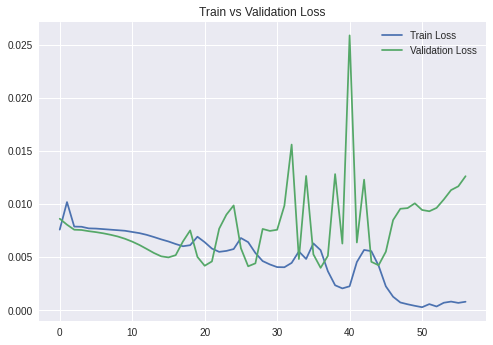

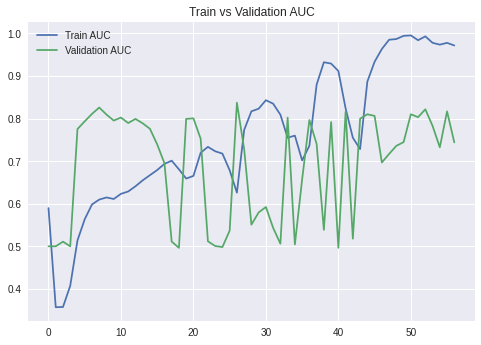

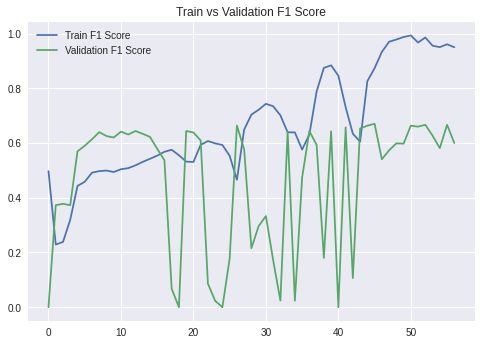


-------------------------------
Best metrics for validation set on Epoch 27:
Loss::      0.0041
AUC::       0.8373
Accuracy::  0.7821
F1::        0.6638
Precision:: 0.5133
Recall::    0.9390
Confusion Matrix:
 [[203  73]
 [  5  77]]
-------------------------------

Metrics for train set on Epoch 27:
Loss::      0.0064
AUC::       0.6260
Accuracy::  0.6975
F1::        0.4657
Precision:: 0.4748
Recall::    0.4569
Confusion Matrix:
 [[8823 2274]
 [2444 2056]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':2,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':30,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

Train with VGG19_BN is overfitting 

Configs:

('coronal',[95])
num_repeats = 1,
model='vgg19_bn',
classes=['MCI','CN'],
mri_config = {
'num_samples':0,
'num_rotations':4,
'sampling_range':3,

'lr':0.000002,
'batch_size':128,
'optimizer':'adam',
'max_epochs':200,
'early_stop':100,
'early_stop_metric':'auc',
'prediction_threshold':0.5,
'momentum':0.99},

training samples: 8665

val: 350

## Shallow CNN 

Data augmentation brings nice results


Best metrics for validation set on Epoch 135:
Loss::      0.0070
AUC::       0.8198
Accuracy::  0.8212
F1::        0.6768
Precision:: 0.5776
Recall::    0.8171
Confusion Matrix:
 [[227  49]
 [ 15  67]]

-------------------------------

Metrics for train set on Epoch 135:
Loss::      0.0043
AUC::       0.8369
Accuracy::  0.8099
F1::        0.7322
Precision:: 0.6168
Recall::    0.9008
Confusion Matrix:
 [[4766 1399]
 [ 248 2252]]

Params:


('coronal',[95])
'num_samples':0,
'num_rotations':4,
'sampling_range':3,
'lr':0.00001, OR lr=0.000007 (little worse)
'batch_size':128,
'optimizer':'sgd',
'max_epochs':200,
'early_stop':100,
'early_stop_metric':'auc',
'prediction_threshold':0.5,
'momentum':0.99},


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stri

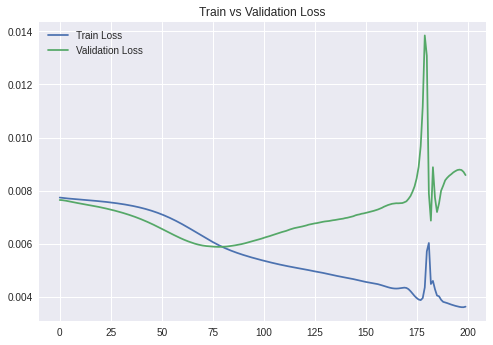

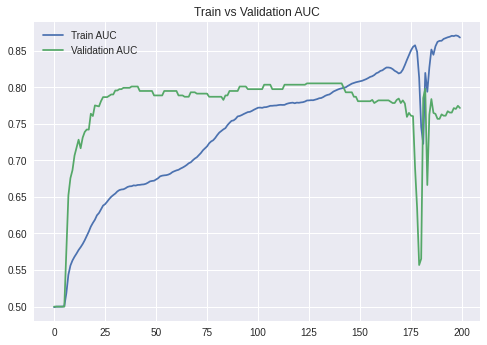

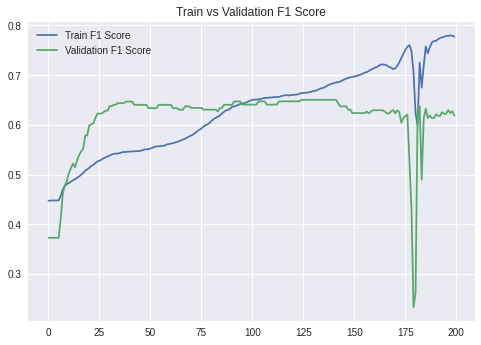


-------------------------------
Best metrics for validation set on Epoch 125:
Loss::      0.0068
AUC::       0.8053
Accuracy::  0.7989
F1::        0.6505
Precision:: 0.5403
Recall::    0.8171
Confusion Matrix:
 [[219  57]
 [ 15  67]]
-------------------------------

Metrics for train set on Epoch 125:
Loss::      0.0050
AUC::       0.7819
Accuracy::  0.7493
F1::        0.6641
Precision:: 0.5414
Recall::    0.8588
Confusion Matrix:
 [[4346 1819]
 [ 353 2147]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000007,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

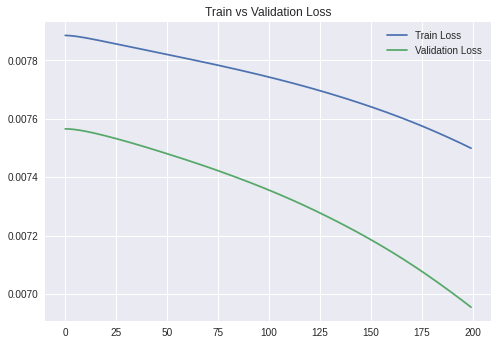

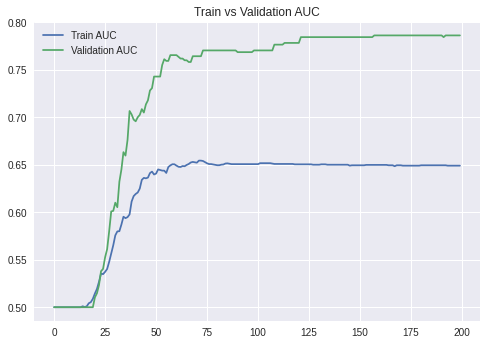

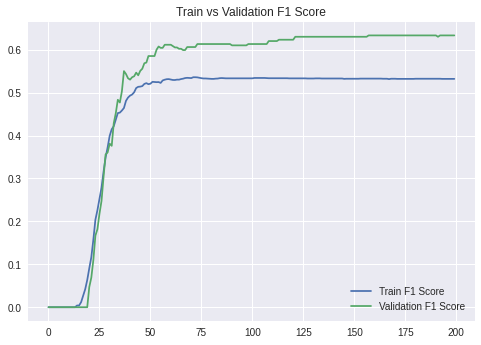


-------------------------------
Best metrics for validation set on Epoch 158:
Loss::      0.0072
AUC::       0.7863
Accuracy::  0.7961
F1::        0.6332
Precision:: 0.5385
Recall::    0.7683
Confusion Matrix:
 [[222  54]
 [ 19  63]]
-------------------------------

Metrics for train set on Epoch 158:
Loss::      0.0076
AUC::       0.6499
Accuracy::  0.5441
F1::        0.5325
Precision:: 0.3782
Recall::    0.9000
Confusion Matrix:
 [[493 740]
 [ 50 450]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stri

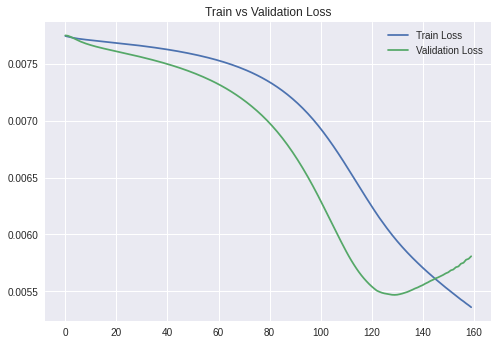

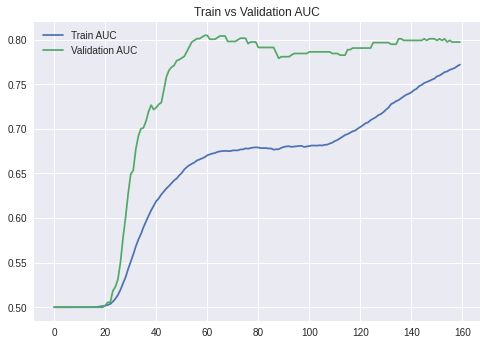

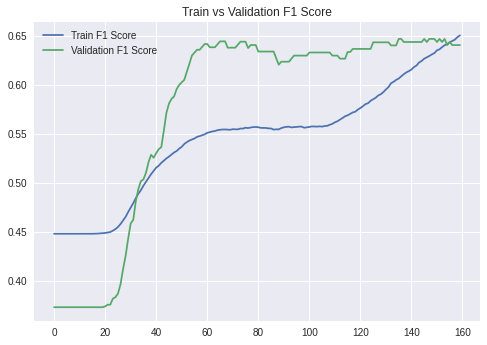


-------------------------------
Best metrics for validation set on Epoch 60:
Loss::      0.0073
AUC::       0.8048
Accuracy::  0.7849
F1::        0.6419
Precision:: 0.5188
Recall::    0.8415
Confusion Matrix:
 [[212  64]
 [ 13  69]]
-------------------------------

Metrics for train set on Epoch 60:
Loss::      0.0075
AUC::       0.6682
Accuracy::  0.5365
F1::        0.5495
Precision:: 0.3818
Recall::    0.9796
Confusion Matrix:
 [[2200 3965]
 [  51 2449]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stri

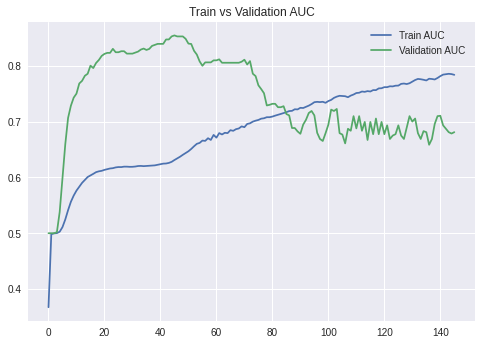

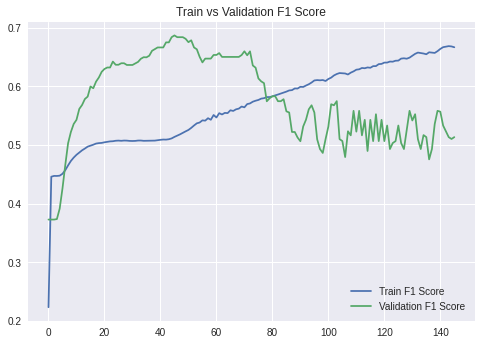


-------------------------------
Best metrics for validation set on Epoch 46:
Loss::      0.0058
AUC::       0.8542
Accuracy::  0.8017
F1::        0.6872
Precision:: 0.5379
Recall::    0.9512
Confusion Matrix:
 [[209  67]
 [  4  78]]
-------------------------------

Metrics for train set on Epoch 46:
Loss::      0.0072
AUC::       0.6311
Accuracy::  0.5460
F1::        0.5139
Precision:: 0.3717
Recall::    0.8322
Confusion Matrix:
 [[ 7953 10542]
 [ 1258  6237]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

## Running Shallow for all slices (Trying)


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

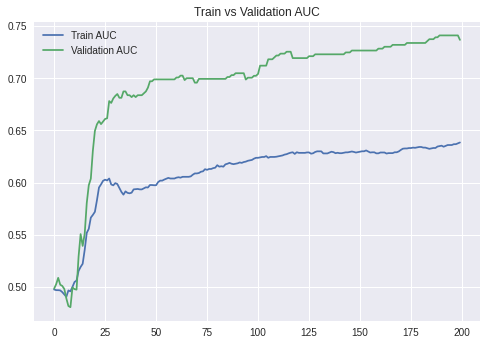

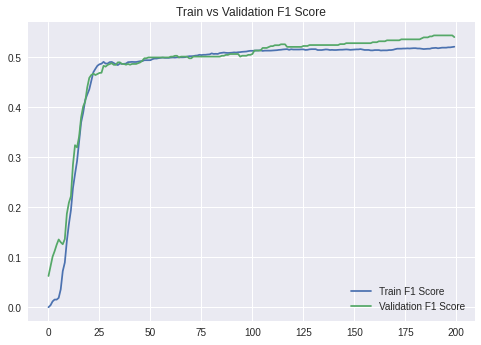


-------------------------------
Best metrics for validation set on Epoch 190:
Loss::      0.0070
AUC::       0.7411
Accuracy::  0.6536
F1::        0.5441
Precision:: 0.3895
Recall::    0.9024
Confusion Matrix:
 [[160 116]
 [  8  74]]
-------------------------------

Metrics for train set on Epoch 190:
Loss::      0.0075
AUC::       0.6350
Accuracy::  0.5381
F1::        0.5189
Precision:: 0.3708
Recall::    0.8640
Confusion Matrix:
 [[501 733]
 [ 68 432]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:2 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, ker

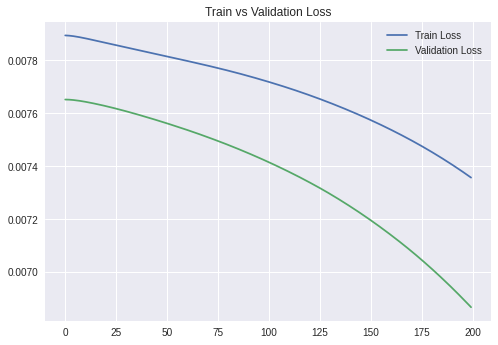

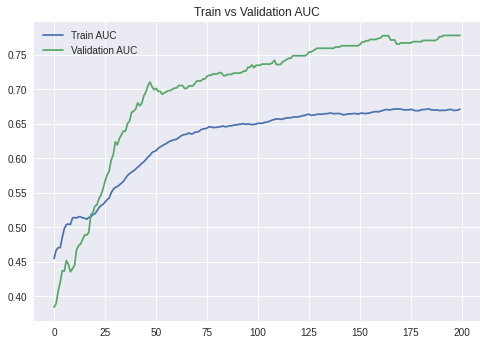

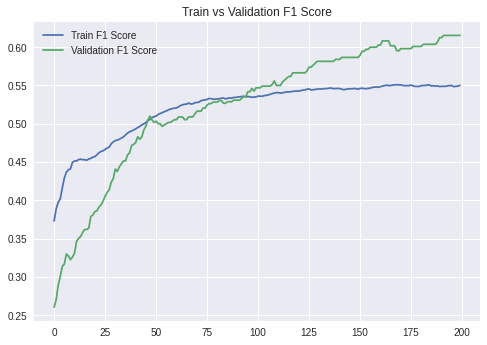


-------------------------------
Best metrics for validation set on Epoch 192:
Loss::      0.0069
AUC::       0.7779
Accuracy::  0.7765
F1::        0.6154
Precision:: 0.5079
Recall::    0.7805
Confusion Matrix:
 [[214  62]
 [ 18  64]]
-------------------------------

Metrics for train set on Epoch 192:
Loss::      0.0074
AUC::       0.6694
Accuracy::  0.5582
F1::        0.5489
Precision:: 0.3890
Recall::    0.9320
Confusion Matrix:
 [[502 732]
 [ 34 466]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:4 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, ker


-------------------------------
Best metrics for validation set on Epoch 104:
Loss::      0.0074
AUC::       0.7815
Accuracy::  0.7821
F1::        0.6214
Precision:: 0.5161
Recall::    0.7805
Confusion Matrix:
 [[216  60]
 [ 18  64]]
-------------------------------

Metrics for train set on Epoch 104:
Loss::      0.0077
AUC::       0.6620
Accuracy::  0.5409
F1::        0.5436
Precision:: 0.3810
Recall::    0.9480
Confusion Matrix:
 [[464 770]
 [ 26 474]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:6 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, ker

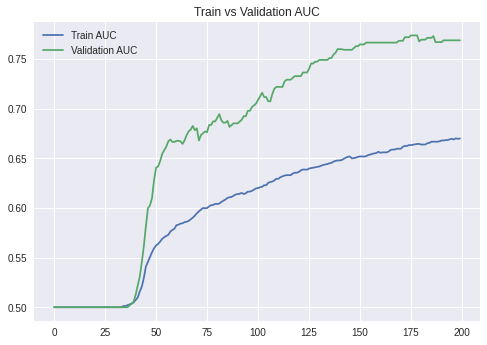

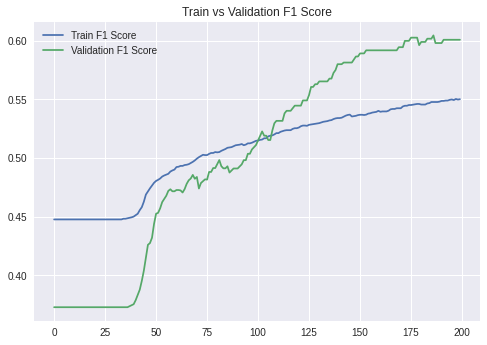


-------------------------------
Best metrics for validation set on Epoch 176:
Loss::      0.0073
AUC::       0.7738
Accuracy::  0.7570
F1::        0.6027
Precision:: 0.4818
Recall::    0.8049
Confusion Matrix:
 [[205  71]
 [ 16  66]]
-------------------------------

Metrics for train set on Epoch 176:
Loss::      0.0076
AUC::       0.6633
Accuracy::  0.5334
F1::        0.5453
Precision:: 0.3792
Recall::    0.9700
Confusion Matrix:
 [[440 794]
 [ 15 485]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:8 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, ker

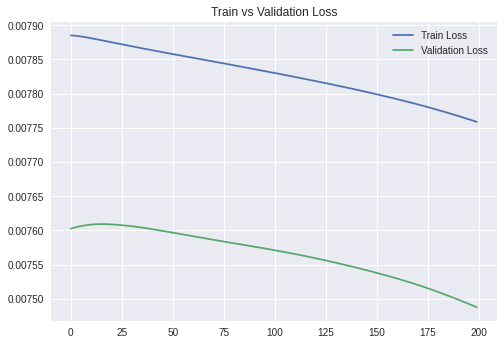

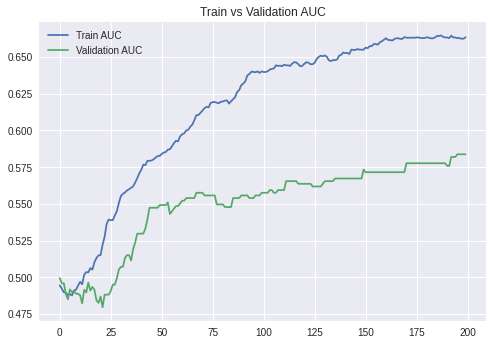


-------------------------------
Best metrics for validation set on Epoch 196:
Loss::      0.0075
AUC::       0.5838
Accuracy::  0.7151
F1::        0.3544
Precision:: 0.3684
Recall::    0.3415
Confusion Matrix:
 [[228  48]
 [ 54  28]]
-------------------------------

Metrics for train set on Epoch 196:
Loss::      0.0078
AUC::       0.6629
Accuracy::  0.6938
F1::        0.5263
Precision:: 0.4750
Recall::    0.5900
Confusion Matrix:
 [[908 326]
 [205 295]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:10 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, ke

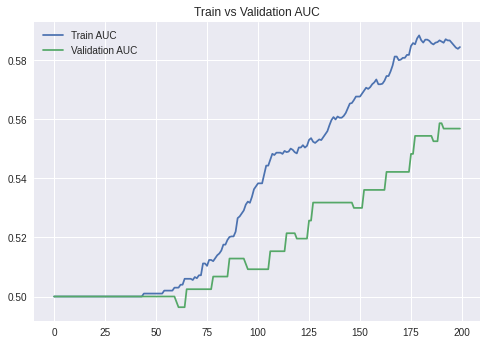

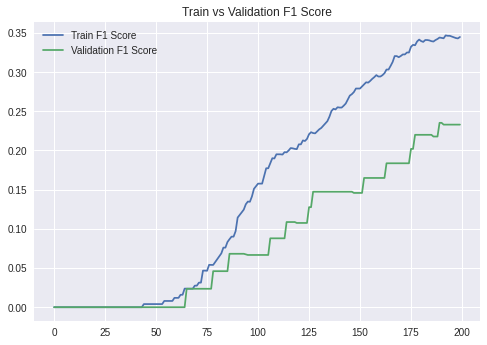


-------------------------------
Best metrics for validation set on Epoch 190:
Loss::      0.0075
AUC::       0.5587
Accuracy::  0.7821
F1::        0.2353
Precision:: 0.6000
Recall::    0.1463
Confusion Matrix:
 [[268   8]
 [ 70  12]]
-------------------------------

Metrics for train set on Epoch 190:
Loss::      0.0078
AUC::       0.5867
Accuracy::  0.7318
F1::        0.3441
Precision:: 0.5837
Recall::    0.2440
Confusion Matrix:
 [[1147   87]
 [ 378  122]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:12 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8

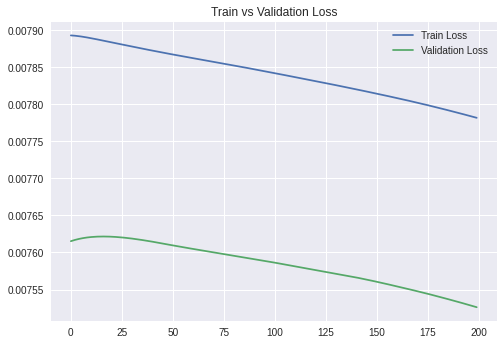

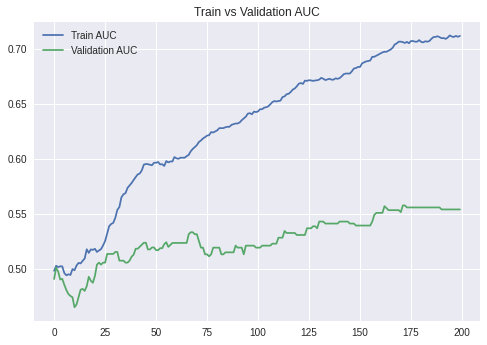


-------------------------------
Best metrics for validation set on Epoch 172:
Loss::      0.0075
AUC::       0.5574
Accuracy::  0.7207
F1::        0.2958
Precision:: 0.3500
Recall::    0.2561
Confusion Matrix:
 [[237  39]
 [ 61  21]]
-------------------------------

Metrics for train set on Epoch 172:
Loss::      0.0078
AUC::       0.7061
Accuracy::  0.7687
F1::        0.5819
Precision:: 0.6078
Recall::    0.5580
Confusion Matrix:
 [[1054  180]
 [ 221  279]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8

In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',list(range(0,100,2)))
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/EXPERIMENTS_MCI_SELECTED_SHALLOW_CNN_CORONAL_.csv')

In [ ]:
df_vgg19_1 = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/EXPERIMENTS_MCI_SELECTED_SHALLOW_CNN_CORONAL_.csv')

In [ ]:
df_vgg19_1

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0   0.634998        0.538062       0.518919         0.370815         0.864   
1   0.669404        0.558247       0.548881         0.388982         0.932   
2   0.662006        0.540946       0.543578         0.381029         0.948   
3   0.663282        0.533449       0.545250         0.379203         0.970   
4   0.662909        0.693772       0.526316         0.475040         0.590   
5   0.586749        0.731834       0.344147         0.583732         0.244   
6   0.706066        0.768743       0.581856         0.607843         0.558   

                train_conf_mat  validation_auc  validation_accuracy  \
0      [[501 733]\n [ 68 432]]        0.741075             0.653631   
1      [[502 732]\n [ 34 466]]        0.777925             0.776536   
2      [[464 770]\n [ 26 474]]        0.781548             0.782123   
3      [[440 794]\n [ 15 485]]        0.773816             0.756983   
4      [[908 326]\n [205 295]]        0.583775             0.715084   
5  [[1147   87]\n [ 378  122]]        0.558678             0.782123   
6  [[1054  180]\n [ 221  279]]        0.557397             0.720670   

   validation_f1score  validation_precision  validation_recall  \
0            0.544118              0.389474           0.902439   
1            0.615385              0.507937           0.780488   
2            0.621359              0.516129           0.780488   
3            0.602740              0.481752           0.804878   
4            0.354430              0.368421           0.341463   
5            0.235294              0.600000           0.146341   
6            0.295775              0.350000           0.256098   

       validation_conf_mat orientation  slice  run      RUN_ID  
0  [[160 116]\n [  8  74]]     coronal      0    1   coronal01  
1  [[214  62]\n [ 18  64]]     coronal      2    1   coronal21  
2  [[216  60]\n [ 18  64]]     coronal      4    1   coronal41  
3  [[205  71]\n [ 16  66]]     coronal      6    1   coronal61  
4  [[228  48]\n [ 54  28]]     coronal      8    1   coronal81  
5  [[268   8]\n [ 70  12]]     coronal     10    1  coronal101  
6  [[237  39]\n [ 61  21]]     coronal     12    1  coronal121

In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('axial',list(range(0,100,2)))
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/EXPERIMENTS_MCI_SELECTED_SHALLOW_CNN_AXIAL.csv')

In [ ]:
df_vgg19_1

In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('sagittal',list(range(0,100,2)))
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000005,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/EXPERIMENTS_MCI_SELECTED_SHALLOW_CNN_SAGITTAL.csv')

In [ ]:
df_vgg19_1


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

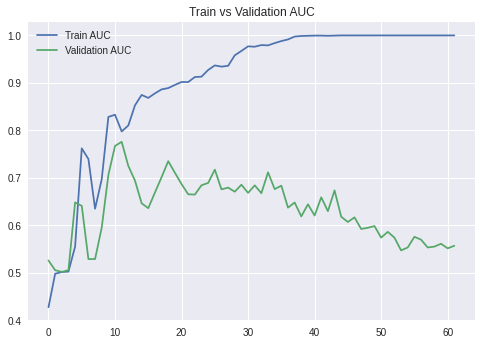

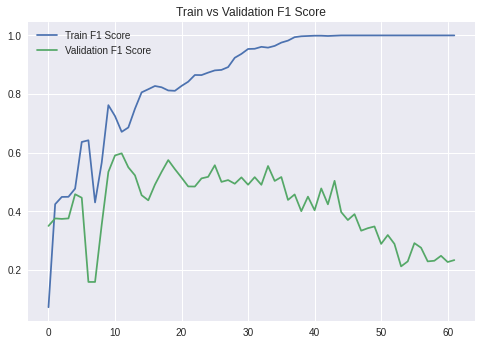


-------------------------------
Best metrics for validation set on Epoch 12:
Loss::      0.0072
AUC::       0.7758
Accuracy::  0.7402
F1::        0.5974
Precision:: 0.4631
Recall::    0.8415
Confusion Matrix:
 [[196  80]
 [ 13  69]]
-------------------------------

Metrics for train set on Epoch 12:
Loss::      0.0073
AUC::       0.7977
Accuracy::  0.7265
F1::        0.6708
Precision:: 0.5138
Recall::    0.9660
Confusion Matrix:
 [[776 457]
 [ 17 483]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':0,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':150,
              'early_stop':50,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stri

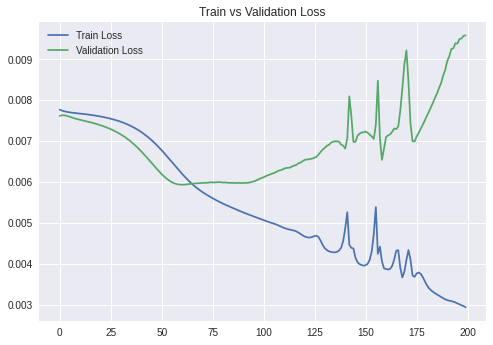

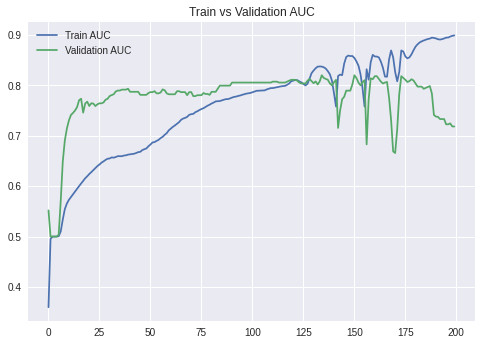


-------------------------------
Best metrics for validation set on Epoch 135:
Loss::      0.0070
AUC::       0.8198
Accuracy::  0.8212
F1::        0.6768
Precision:: 0.5776
Recall::    0.8171
Confusion Matrix:
 [[227  49]
 [ 15  67]]
-------------------------------

Metrics for train set on Epoch 135:
Loss::      0.0043
AUC::       0.8369
Accuracy::  0.8099
F1::        0.7322
Precision:: 0.6168
Recall::    0.9008
Confusion Matrix:
 [[4766 1399]
 [ 248 2252]]
-------------------------------



In [ ]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='shallow_cnn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':128,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':100,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')

## Try to optimize Soft-F1 Score

# Try to save model correctly

In [49]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)
                if save_path != '' and save_path is not None:
                    df_results = pd.concat(results)
                    df_results.to_csv(save_path,index=False)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results

def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions

def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'early_stop_metric':'auc',
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics,best_model_params = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        early_stopping_metric = additional_experiment_params['early_stop_metric'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        model = model.load_state_dict(best_model_params,strict=True)
        model.to(device)
        test_metrics,_,_ = evaluate(dataloader=prepared_data['test_dataloader'], model= model, loss_fn = criterion, optimizer=optimizer,predictions=False)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,loss_fn= criterion, optimizer=optimizer,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), 
                        lr=additional_experiment_params['lr'],
                        momentum=additional_experiment_params['momentum'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': True,
            'num_workers': 4,
            'pin_memory':False}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, shuffle=False,batch_size=1024)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, shuffle=False,batch_size=1024)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    df_train = df_mri_reference.query("DATASET not in ('validation','test')")

    neg_class = df_train.query("MACRO_GROUP == 0").shape[0]
    pos_class = df_train.query("MACRO_GROUP == 1").shape[0]

    if additional_experiment_params['loss'] == 'FocalLoss':
        alpha =  (pos_class/neg_class)
        criterion = WeightedFocalLoss(alpha=alpha,gamma=additional_experiment_params['loss_gamma'])
    else:
        pos_weight = torch.ones([1]) * (neg_class/pos_class)
        criterion = BCEWithLogitsLoss(pos_weight=pos_weight,reduction='mean')
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,loss_fn,optimizer,threshold=0.5,verbose=0):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    model.to(device)
    model.eval()
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        
        metrics,loss,predicted_probas = evaluate(dataloader = data_loader, model = model, loss_fn = loss_fn, optimizer=optimizer,predictions=True)
        if verbose > 0:
            print_metrics(metrics,loss)

        predicted_labels = predicted_probas >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predicted_probas

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)
    
    elif model_type == 'vgg13':
        vgg13_bn = adapt_vgg(models.vgg13())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)

    elif model_type == 'vgg19':
        vgg19 = adapt_vgg(models.vgg19())
        model = vgg19.to(device)


    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model
    
def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    # vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    vgg.classifier = Sequential(
    Linear(in_features=7*7*512, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=1, bias=True)
    )
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            early_stopping_metric = 'auc',
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    train_f1s = []
    validation_f1s = []
        
    best_epoch = 0
    best_validation_metric = 0
    early_stopping_marker = 0
    best_model_params = deepcopy(model.state_dict())
    best_validation_metrics = None
    best_validation_loss = None
    model.to(device)
    model.train()
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        train_metrics,_,_ = evaluate(train_dataloader, model, loss_fn, optimizer)
        validation_metrics, validation_loss,_ = evaluate(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])
        train_f1s.append(train_metrics['f1score'])
        validation_f1s.append(validation_metrics['f1score'])

        if best_validation_metric >= validation_metrics[early_stopping_metric]:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_metric = validation_metrics[early_stopping_metric]
            early_stopping_marker = 0
            best_model_params = deepcopy(model.state_dict())
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation '+ early_stopping_metric + ' so far: %1.4f' % best_validation_metrics[early_stopping_metric])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                
                if model_path != '':
                    print("Saving model at:",model_path)
                    torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            if model_path != '':
                print("Saving model at:",model_path)
                torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    print('')
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('')
    plot_metric(metric='F1 Score',train_metric=train_f1s,validation_metric= validation_f1s)    
    print('\n-------------------------------')
    
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    print(f"Metrics for train set on Epoch {best_epoch}:")
    print_metrics(best_train_metrics,best_train_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics,best_model_params

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 
        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)
    
    running_loss = running_loss/size
    return running_loss

def evaluate(dataloader, model, loss_fn, optimizer,predictions=False):
    '''
    Evaluate a model on a dataset. 
    
    Returns metrics, loss and predictions

    '''
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_logits = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_logits = torch.cat((predicted_logits,y_pred),0)
        predicted_probas = torch.sigmoid(predicted_logits)
        metrics = compute_metrics_binary(y_true = true_labels, y_pred_proba = predicted_probas, threshold = 0.5,verbose=0)
        running_loss = running_loss/size
                
        if predictions:
            predicted_probas = predicted_probas.cpu().detach().numpy().ravel()

        return metrics,running_loss,predicted_probas

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor = None , y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):

    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
        print("\nTrain Confusion Matrix:\n", train_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

from torch.nn.functional import binary_cross_entropy_with_logits
from torch.nn import Module

class WeightedFocalLoss(Module):
    "Weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

Using cuda device


In [30]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            # BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            # BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            # BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(8, 8))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=64*8*8, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=512, out_features=512, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())
        # flattenning 
        x = x.view(-1,64*8*8)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits


Modificações principais:

- Adicionar from copy import deepcopy
- fazer deecopy do state_dict()
- Fazer model.to(device) e model.eval() no inicio do método de teste.


In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# show_batch(train_dl)

In [31]:
mri_config = {
  'orientation':'coronal',
  'slice':95,
  'num_samples':0,
  'num_rotations':0,
  'sampling_range':3,
  'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
  'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
}

df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                    output_path = mri_config['output_path'],
                    orientation = mri_config['orientation'],
                    orientation_slice = mri_config['slice'],
                    num_sampled_images = mri_config['num_samples'],
                    sampling_range = mri_config['sampling_range'],
                    num_rotations = mri_config['num_rotations'],
                    save_reference_file = False)

Creating augmented samples...
Creating final reference file for prepared images...


In [53]:
additional_experiment_params = {'lr':0.0001,
'batch_size':32,
'loss':'FocalLoss',
'loss_gamma':2,
'optimizer':'adam',
'max_epochs':10,
'early_stop':3,
'early_stop_metric':'auc',
'prediction_threshold':0.5,
'nesterov':True,
'dampening':0,
'weight_decay':0.01,
'momentum':0.99}
df_mri_reference = df_ref
model_name = 'cnn_test'
classes=['MCI','CN']
model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/models/'


In [56]:
model='shallow_cnn'
if type(model) == str:
    model = load_model(model)
model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")

optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(8, 8))
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1, bias=


---------------------------------------------------------------------
Running Epoch 1 of  100
Loss::      Train 0.0023      Validation 0.0002
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.7115      Validation 0.7709
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[276   0]
 [ 82   0]]

Train Confusion Matrix:
 [[1233    0]
 [ 500    0]]

Epoch 1 took 4.25 seconds
---------------------------------------------------------------------
Best validation auc so far: 0.5000

---------------------------------------------------------------------
Running Epoch 2 of  100
Loss::      Train 0.0021      Validation 0.0001
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.7115      Validation 0.7709
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0

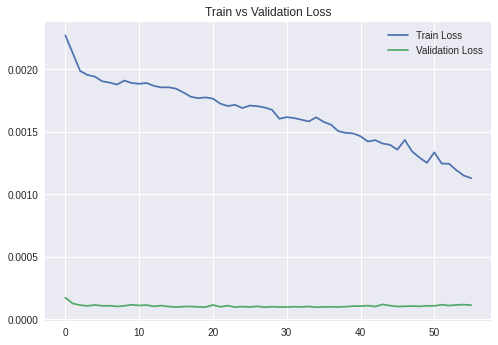

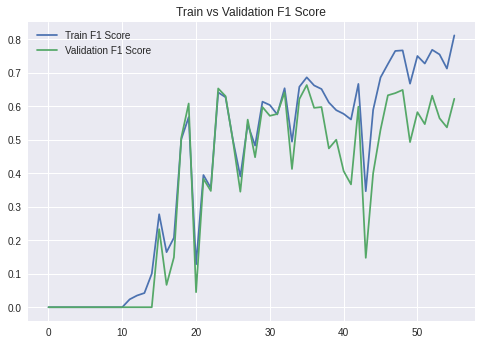


-------------------------------
Best metrics for validation set on Epoch 36:
Loss::      0.0001
AUC::       0.8100
Accuracy::  0.8128
F1::        0.6633
Precision:: 0.5641
Recall::    0.8049
Confusion Matrix:
 [[225  51]
 [ 16  66]]
-------------------------------

Metrics for train set on Epoch 36:
Loss::      0.0016
AUC::       0.7942
Accuracy::  0.7842
F1::        0.6862
Precision:: 0.5910
Recall::    0.8180
Confusion Matrix:
 [[950 283]
 [ 91 409]]
-------------------------------

Model saved at: /content/gdrive/MyDrive/Lucas_Thimoteo/models/cnn_test11102021_022111102021_0223.pth


In [57]:
train_metrics,validation_metrics,best_model_params = train(
train_dataloader=prepared_data['train_dataloader'],
validation_dataloader=prepared_data['validation_dataloader'],
model=model,
loss_fn=criterion,
optimizer=optimizer,
max_epochs=100,
early_stopping_epochs=20,
early_stopping_metric = additional_experiment_params['early_stop_metric'],
model_name = model_name,
model_path=model_path)
print("Model saved at:",model_path + model_name+'.pth')

cols = train_metrics.keys()
train_cols = ['train_'+x for x in cols]
df_results = pd.DataFrame([train_metrics])
df_results.columns = train_cols

validation_cols = ['validation_'+x for x in cols]
for col,value in zip(validation_cols,validation_metrics.values()):
    df_results[col] = [value]

In [58]:
model2 = load_model('shallow_cnn');
model2.load_state_dict(best_model_params,strict=True);
model2.to('cuda');
model2.eval();

Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(8, 8))
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1, bias=

In [59]:
df_preds2 = compute_predictions_for_dataset(prepared_data,model2,loss_fn=criterion,optimizer = optimizer,threshold = additional_experiment_params['prediction_threshold'],verbose=1)

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1733, 14)
Loss::      0.0016
AUC::       0.7942
Accuracy::  0.7842
F1::        0.6862
Precision:: 0.5910
Recall::    0.8180
Confusion Matrix:
 [[950 283]
 [ 91 409]]
Computing Predictions for validation set.
dataset size: (358, 14)
Loss::      0.0001
AUC::       0.8100
Accuracy::  0.8128
F1::        0.6633
Precision:: 0.5641
Recall::    0.8049
Confusion Matrix:
 [[225  51]
 [ 16  66]]
Computing Predictions for test set.
dataset size: (364, 14)
Loss::      0.0001
AUC::       0.8799
Accuracy::  0.8681
F1::        0.7526
Precision:: 0.6460
Recall::    0.9012
Confusion Matrix:
 [[243  40]
 [  8  73]]


In [ ]:
# Loading weights from pth file
model3 = load_model("vgg19_bn");
model3.load_state_dict(torch.load(model_path + model_name+'.pth'),strict=True);
model3.to('cuda');
model3.eval();

Loading untrained model...

Total number of trainable parameters: 139584193


In [ ]:
df_preds3 = compute_predictions_for_dataset(prepared_data,model3,criterion,threshold = additional_experiment_params['prediction_threshold'])

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1733, 16)
Performance for test set:
Loss::      0.0078
AUC::       0.6072
Accuracy::  0.5765
F1::        0.4809
Precision:: 0.3720
Recall::    0.6800
Confusion Matrix:
 [[659 574]
 [160 340]]
Computing Predictions for validation set.
dataset size: (358, 16)
Performance for test set:
Loss::      0.0075
AUC::       0.7512
Accuracy::  0.7486
F1::        0.5794
Precision:: 0.4697
Recall::    0.7561
Confusion Matrix:
 [[206  70]
 [ 20  62]]
Computing Predictions for test set.
dataset size: (364, 16)
Performance for test set:
Loss::      0.0073
AUC::       0.7070
Accuracy::  0.7500
F1::        0.5285
Precision:: 0.4554
Recall::    0.6296
Confusion Matrix:
 [[222  61]
 [ 30  51]]


In [ ]:
# for d1,d2 in zip(best_model_params.items(),model.state_dict().items()):
#   print(d1[0])
#   print(((d1[1] == d2[1]) == False).sum())

In [ ]:
df_preds = compute_predictions_for_dataset(prepared_data,model,criterion,threshold = additional_experiment_params['prediction_threshold'])

In [ ]:
df_results

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0    0.50017        0.311598       0.442263         0.288591         0.946   

            train_conf_mat  validation_auc  validation_accuracy  \
0  [[67, 1166], [27, 473]]        0.503623             0.234637   

   validation_f1score  validation_precision  validation_recall  \
0            0.374429              0.230337                1.0   

   validation_conf_mat  
0  [[2, 274], [0, 82]]

In [ ]:
test_metrics = test(dataloader=prepared_data['validation_dataloader'],
model=model3,
loss_fn=criterion,
return_predictions=False,
compute_metrics=True)

Performance for test set:
Loss::      0.0078
AUC::       0.5036
Accuracy::  0.2346
F1::        0.3744
Precision:: 0.2303
Recall::    1.0000
Confusion Matrix:
 [[  2 274]
 [  0  82]]


In [ ]:
test_metrics = test(dataloader=prepared_data['train_dataloader'],
model=model3,
loss_fn=criterion,
return_predictions=False,
compute_metrics=True)

Performance for test set:
Loss::      0.0079
AUC::       0.4964
Accuracy::  0.2868
F1::        0.4452
Precision:: 0.2870
Recall::    0.9920
Confusion Matrix:
 [[   1 1232]
 [   4  496]]


In [ ]:
df_results

train_auc  train_accuracy  train_f1score  train_precision  train_recall  \
0    0.50017        0.311598       0.442263         0.288591         0.946   

            train_conf_mat  validation_auc  validation_accuracy  \
0  [[67, 1166], [27, 473]]        0.503623             0.234637   

   validation_f1score  validation_precision  validation_recall  \
0            0.374429              0.230337                1.0   

   validation_conf_mat  
0  [[2, 274], [0, 82]]

# Trying more experiments with FocalLoss

In [60]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)
                if save_path != '' and save_path is not None:
                    df_results = pd.concat(results)
                    df_results.to_csv(save_path,index=False)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results

def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions

def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'early_stop_metric':'auc',
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics,best_model_params = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        early_stopping_metric = additional_experiment_params['early_stop_metric'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        model = model.load_state_dict(best_model_params,strict=True)
        model.to(device)
        test_metrics,_,_ = evaluate(dataloader=prepared_data['test_dataloader'], model= model, loss_fn = criterion, optimizer=optimizer,predictions=False)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,loss_fn= criterion, optimizer=optimizer,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), 
                        lr=additional_experiment_params['lr'],
                        momentum=additional_experiment_params['momentum'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': True,
            'num_workers': 4,
            'pin_memory':False}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, shuffle=False,batch_size=1024)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, shuffle=False,batch_size=1024)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    df_train = df_mri_reference.query("DATASET not in ('validation','test')")

    neg_class = df_train.query("MACRO_GROUP == 0").shape[0]
    pos_class = df_train.query("MACRO_GROUP == 1").shape[0]

    if additional_experiment_params['loss'] == 'FocalLoss':
        alpha =  (pos_class/neg_class)
        criterion = WeightedFocalLoss(alpha=alpha,gamma=additional_experiment_params['loss_gamma'])
    else:
        pos_weight = torch.ones([1]) * (neg_class/pos_class)
        criterion = BCEWithLogitsLoss(pos_weight=pos_weight,reduction='mean')
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,loss_fn,optimizer,threshold=0.5,verbose=0):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    model.to(device)
    model.eval()
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        
        metrics,loss,predicted_probas = evaluate(dataloader = data_loader, model = model, loss_fn = loss_fn, optimizer=optimizer,predictions=True)
        if verbose > 0:
            print_metrics(metrics,loss)

        predicted_labels = predicted_probas >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predicted_probas

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)
    
    elif model_type == 'vgg13':
        vgg13_bn = adapt_vgg(models.vgg13())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)

    elif model_type == 'vgg19':
        vgg19 = adapt_vgg(models.vgg19())
        model = vgg19.to(device)


    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model
    
def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    # vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    vgg.classifier = Sequential(
    Linear(in_features=7*7*512, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=4096, bias=True),
    ReLU(inplace=True),
    Linear(in_features=4096, out_features=1, bias=True)
    )
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            early_stopping_metric = 'auc',
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    train_f1s = []
    validation_f1s = []
        
    best_epoch = 0
    best_validation_metric = 0
    early_stopping_marker = 0
    best_model_params = deepcopy(model.state_dict())
    best_validation_metrics = None
    best_validation_loss = None
    model.to(device)
    model.train()
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        train_metrics,_,_ = evaluate(train_dataloader, model, loss_fn, optimizer)
        validation_metrics, validation_loss,_ = evaluate(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])
        train_f1s.append(train_metrics['f1score'])
        validation_f1s.append(validation_metrics['f1score'])

        if best_validation_metric >= validation_metrics[early_stopping_metric]:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_metric = validation_metrics[early_stopping_metric]
            early_stopping_marker = 0
            best_model_params = deepcopy(model.state_dict())
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation '+ early_stopping_metric + ' so far: %1.4f' % best_validation_metrics[early_stopping_metric])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                
                if model_path != '':
                    print("Saving model at:",model_path)
                    torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            if model_path != '':
                print("Saving model at:",model_path)
                torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    print('')
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('')
    plot_metric(metric='F1 Score',train_metric=train_f1s,validation_metric= validation_f1s)    
    print('\n-------------------------------')
    
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    print(f"Metrics for train set on Epoch {best_epoch}:")
    print_metrics(best_train_metrics,best_train_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics,best_model_params

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 
        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)
    
    running_loss = running_loss/size
    return running_loss

def evaluate(dataloader, model, loss_fn, optimizer,predictions=False):
    '''
    Evaluate a model on a dataset. 
    
    Returns metrics, loss and predictions

    '''
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_logits = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_logits = torch.cat((predicted_logits,y_pred),0)
        predicted_probas = torch.sigmoid(predicted_logits)
        metrics = compute_metrics_binary(y_true = true_labels, y_pred_proba = predicted_probas, threshold = 0.5,verbose=0)
        running_loss = running_loss/size
                
        if predictions:
            predicted_probas = predicted_probas.cpu().detach().numpy().ravel()

        return metrics,running_loss,predicted_probas

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor = None , y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):

    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
        print("\nTrain Confusion Matrix:\n", train_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

from torch.nn.functional import binary_cross_entropy_with_logits
from torch.nn import Module

class WeightedFocalLoss(Module):
    "Weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

Using cuda device


In [61]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.0001,
              'batch_size':32,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

KeyboardInterrupt: ignored


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

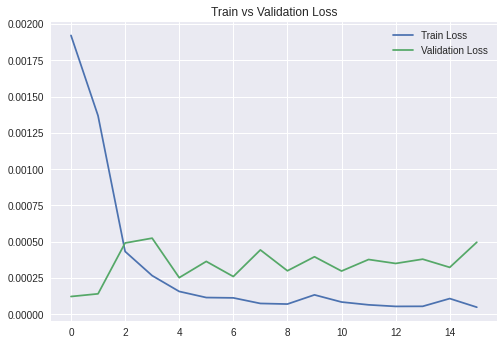

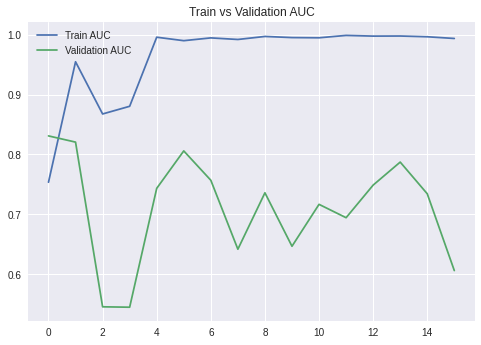

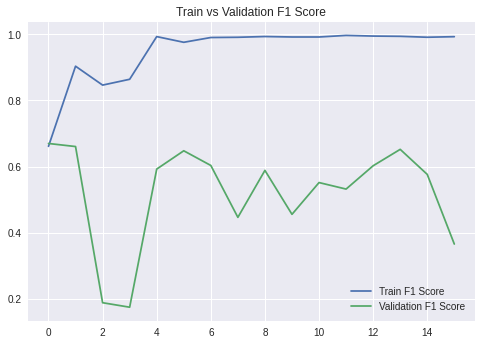


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0001
AUC::       0.8310
Accuracy::  0.7989
F1::        0.6697
Precision:: 0.5368
Recall::    0.8902
Confusion Matrix:
 [[213  63]
 [  9  73]]
-------------------------------

Metrics for train set on Epoch 1:
Loss::      0.0019
AUC::       0.7537
Accuracy::  0.8314
F1::        0.6611
Precision:: 0.7869
Recall::    0.5700
Confusion Matrix:
 [[5779  386]
 [1075 1425]]
-------------------------------



In [62]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='vgg19_bn',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':32,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':15,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

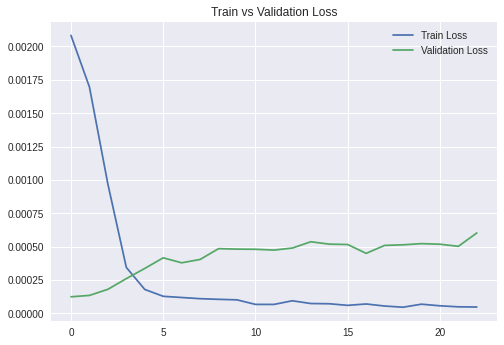

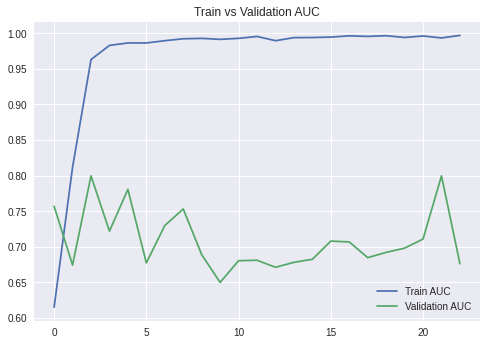


-------------------------------
Best metrics for validation set on Epoch 3:
Loss::      0.0002
AUC::       0.7997
Accuracy::  0.8101
F1::        0.6531
Precision:: 0.5614
Recall::    0.7805
Confusion Matrix:
 [[226  50]
 [ 18  64]]
-------------------------------

Metrics for train set on Epoch 3:
Loss::      0.0010
AUC::       0.9630
Accuracy::  0.9631
F1::        0.9377
Precision:: 0.9138
Recall::    0.9628
Confusion Matrix:
 [[5938  227]
 [  93 2407]]
-------------------------------



In [63]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.00001,
              'batch_size':32,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

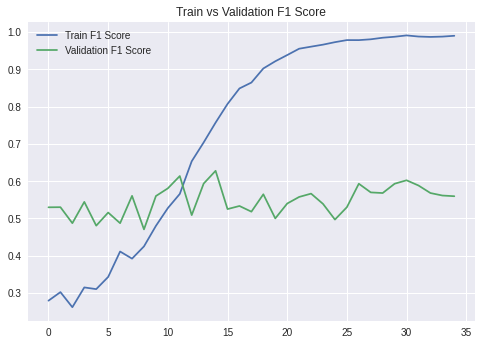


-------------------------------
Best metrics for validation set on Epoch 15:
Loss::      0.0001
AUC::       0.7746
Accuracy::  0.8045
F1::        0.6277
Precision:: 0.5566
Recall::    0.7195
Confusion Matrix:
 [[229  47]
 [ 23  59]]
-------------------------------

Metrics for train set on Epoch 15:
Loss::      0.0013
AUC::       0.8213
Accuracy::  0.8684
F1::        0.7569
Precision:: 0.8105
Recall::    0.7100
Confusion Matrix:
 [[5750  415]
 [ 725 1775]]
-------------------------------



In [67]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':32,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

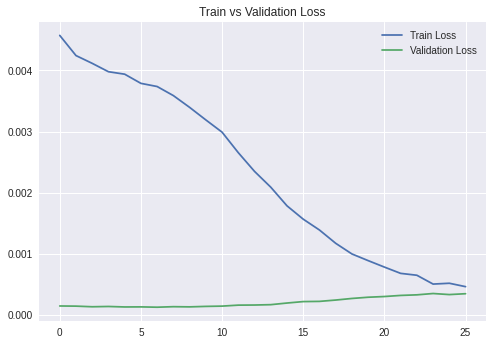

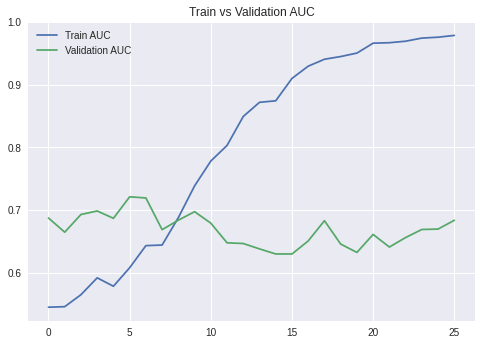

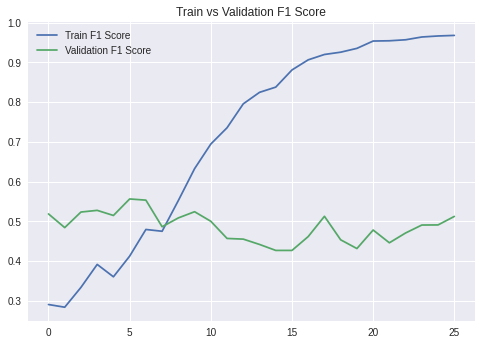


-------------------------------
Best metrics for validation set on Epoch 6:
Loss::      0.0001
AUC::       0.7211
Accuracy::  0.7682
F1::        0.5561
Precision:: 0.4952
Recall::    0.6341
Confusion Matrix:
 [[223  53]
 [ 30  52]]
-------------------------------

Metrics for train set on Epoch 6:
Loss::      0.0038
AUC::       0.6080
Accuracy::  0.7223
F1::        0.4123
Precision:: 0.5295
Recall::    0.3376
Confusion Matrix:
 [[5415  750]
 [1656  844]]
-------------------------------



In [68]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':0,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':16,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

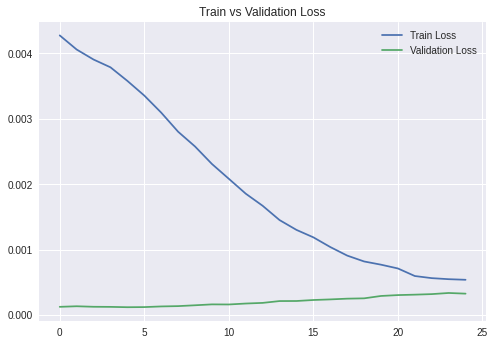

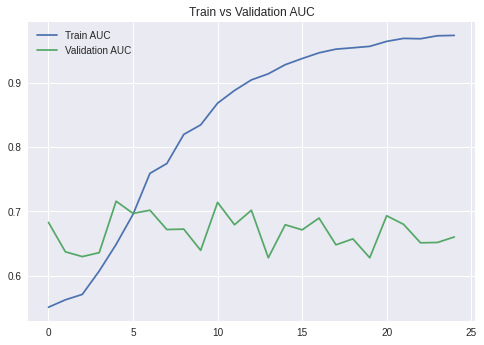

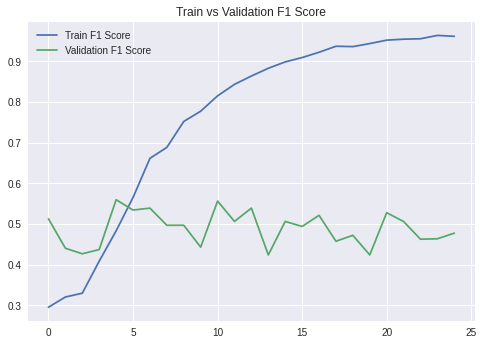


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      0.0001
AUC::       0.7159
Accuracy::  0.7933
F1::        0.5595
Precision:: 0.5465
Recall::    0.5732
Confusion Matrix:
 [[237  39]
 [ 35  47]]
-------------------------------

Metrics for train set on Epoch 5:
Loss::      0.0036
AUC::       0.6489
Accuracy::  0.7567
F1::        0.4830
Precision:: 0.6239
Recall::    0.3940
Confusion Matrix:
 [[16719  1781]
 [ 4545  2955]]
-------------------------------



In [69]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':16,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

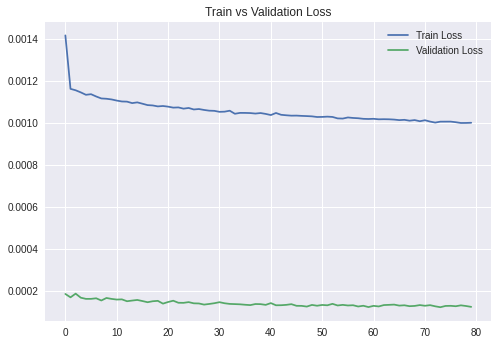

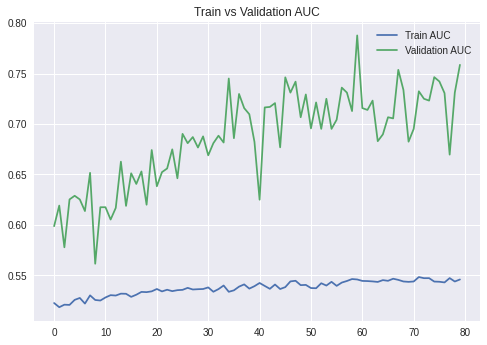

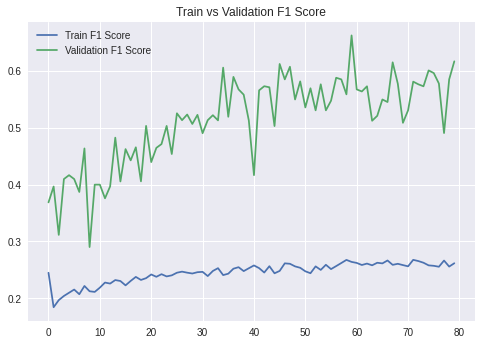


-------------------------------
Best metrics for validation set on Epoch 60:
Loss::      0.0001
AUC::       0.7878
Accuracy::  0.8380
F1::        0.6628
Precision:: 0.6333
Recall::    0.6951
Confusion Matrix:
 [[243  33]
 [ 25  57]]
-------------------------------

Metrics for train set on Epoch 60:
Loss::      0.0010
AUC::       0.5460
Accuracy::  0.6973
F1::        0.2640
Precision:: 0.4422
Recall::    0.1881
Confusion Matrix:
 [[16720  1780]
 [ 6089  1411]]
-------------------------------



In [70]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':2,
              'momentum':0.99,
              'weight_decay':0.1,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

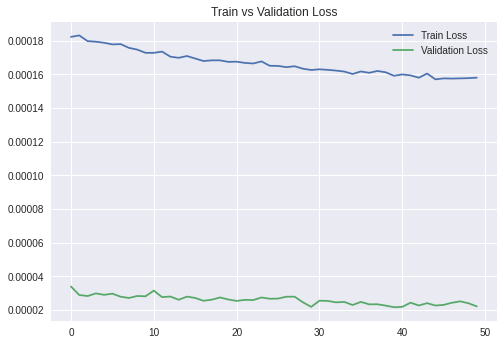

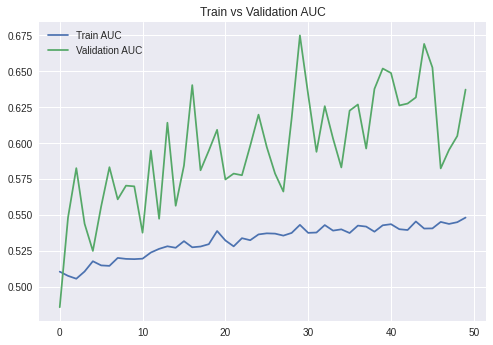


-------------------------------
Best metrics for validation set on Epoch 30:
Loss::      0.0000
AUC::       0.6751
Accuracy::  0.7765
F1::        0.5000
Precision:: 0.5128
Recall::    0.4878
Confusion Matrix:
 [[238  38]
 [ 42  40]]
-------------------------------

Metrics for train set on Epoch 30:
Loss::      0.0002
AUC::       0.5431
Accuracy::  0.6523
F1::        0.3212
Precision:: 0.3674
Recall::    0.2853
Confusion Matrix:
 [[14814  3681]
 [ 5357  2138]]
-------------------------------



In [71]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':5,
              'momentum':0.99,
              'weight_decay':0.1,
              'dampening':0,
              'nesterov':True},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

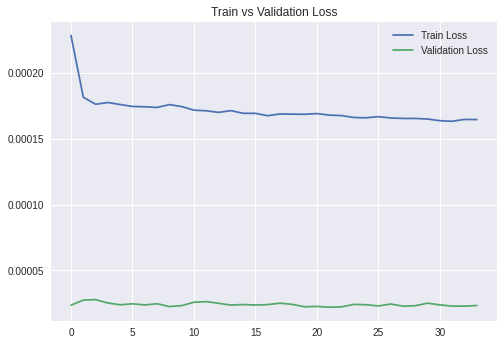

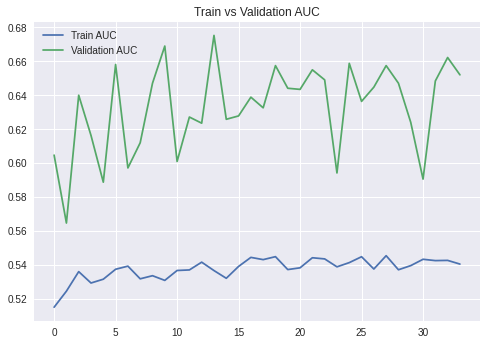

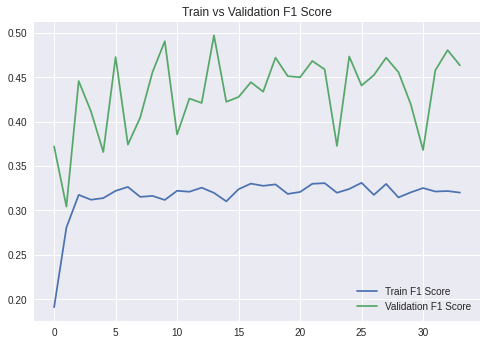


-------------------------------
Best metrics for validation set on Epoch 14:
Loss::      0.0000
AUC::       0.6752
Accuracy::  0.7570
F1::        0.4971
Precision:: 0.4725
Recall::    0.5244
Confusion Matrix:
 [[228  48]
 [ 39  43]]
-------------------------------

Metrics for train set on Epoch 14:
Loss::      0.0002
AUC::       0.5366
Accuracy::  0.6393
F1::        0.3198
Precision:: 0.3506
Recall::    0.2940
Confusion Matrix:
 [[14416  4084]
 [ 5295  2205]]
-------------------------------



In [72]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':2,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.000001,
              'batch_size':64,
              'optimizer':'sgd',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':5,
              'momentum':0.99,
              'weight_decay':0.1,
              'dampening':0,
              'nesterov':False},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:95 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

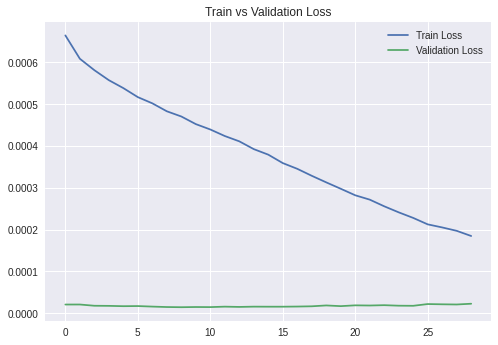

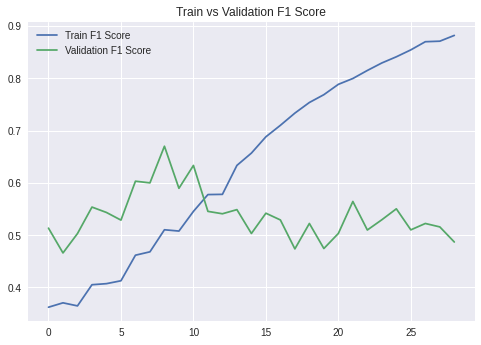


-------------------------------
Best metrics for validation set on Epoch 9:
Loss::      0.0000
AUC::       0.8112
Accuracy::  0.8212
F1::        0.6701
Precision:: 0.5804
Recall::    0.7927
Confusion Matrix:
 [[229  47]
 [ 17  65]]
-------------------------------

Metrics for train set on Epoch 9:
Loss::      0.0005
AUC::       0.6585
Accuracy::  0.7336
F1::        0.5103
Precision:: 0.5433
Recall::    0.4810
Confusion Matrix:
 [[20617  4043]
 [ 5190  4810]]
-------------------------------



In [73]:
df_vgg19_1 = run_mris_experiments(
            orientation_and_slices = [
                            ('coronal',[95])
                            ],
            num_repeats = 1,
            model='resnet34',
            classes=['MCI','CN'],
            mri_config = {
              'num_samples':3,
              'num_rotations':4,
              'sampling_range':3,
              'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211106_SELECTED_MRIS_RESHUFFLE.csv',
              'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
            },
            additional_experiment_params = {'lr':0.0000005,
              'batch_size':16,
              'optimizer':'adam',
              'max_epochs':200,
              'early_stop':20,
              'early_stop_metric':'auc',
              'prediction_threshold':0.5,
              'loss':'FocalLoss',
              'loss_gamma':5,
              'momentum':0.99},
            save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/TEST_MCI_SELECTED.csv')